## 데이터

In [2]:
!pip install pytrends
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=3ac14082d2ce5f5da15824e520cfa856ecd06661aae8ba1f0c647b4a9050aca4
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [16]:
import requests
import pandas as pd
import json
import os
from datetime import datetime

def download_fear_greed_data():
    """Alternative.me API에서 공포/탐욕 지수 데이터를 다운로드하고 로컬 파일로 저장"""

    url = "https://api.alternative.me/fng/?limit=2000&format=json"
    file_path = "fear_greed_index_data.json"

    try:
        print("공포/탐욕 지수 데이터 다운로드 중...")
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()

            # 파일로 저장
            with open(file_path, 'w') as f:
                json.dump(data, f)

            print(f"공포/탐욕 지수 데이터가 '{file_path}'에 저장되었습니다.")

            # 데이터프레임으로 변환
            fg_data = pd.DataFrame(data['data'])
            fg_data['timestamp'] = fg_data['timestamp'].astype(int)
            fg_data['Date'] = pd.to_datetime(fg_data['timestamp'], unit='s')
            fg_data['fear_greed_index'] = fg_data['value'].astype(float)
            fg_data = fg_data[['Date', 'fear_greed_index']]

            # CSV로도 저장 (사용 편의성)
            fg_data.to_csv("fear_greed_index_data.csv", index=False)
            print("데이터가 CSV 형식으로도 저장되었습니다: 'fear_greed_index_data.csv'")

            return fg_data
        else:
            print(f"API 요청 실패: 상태 코드 {response.status_code}")
            return None

    except Exception as e:
        print(f"데이터 다운로드 오류: {e}")
        return None

def load_fear_greed_data():
    """저장된 공포/탐욕 지수 데이터를 로드하거나, 없으면 다운로드"""

    file_path_json = "fear_greed_index_data.json"
    file_path_csv = "fear_greed_index_data.csv"

    # CSV 파일이 있으면 로드 (가장 쉬운 방법)
    if os.path.exists(file_path_csv):
        try:
            print(f"저장된 CSV 파일에서 공포/탐욕 지수 데이터를 로드합니다...")
            fg_data = pd.read_csv(file_path_csv)
            fg_data['Date'] = pd.to_datetime(fg_data['Date'])
            print(f"{len(fg_data)}개의 공포/탐욕 지수 데이터 로드 완료!")
            return fg_data
        except Exception as e:
            print(f"CSV 파일 로드 오류: {e}")

    # JSON 파일이 있으면 로드
    elif os.path.exists(file_path_json):
        try:
            print(f"저장된 JSON 파일에서 공포/탐욕 지수 데이터를 로드합니다...")
            with open(file_path_json, 'r') as f:
                data = json.load(f)

            fg_data = pd.DataFrame(data['data'])
            fg_data['timestamp'] = fg_data['timestamp'].astype(int)
            fg_data['Date'] = pd.to_datetime(fg_data['timestamp'], unit='s')
            fg_data['fear_greed_index'] = fg_data['value'].astype(float)
            fg_data = fg_data[['Date', 'fear_greed_index']]

            print(f"{len(fg_data)}개의 공포/탐욕 지수 데이터 로드 완료!")
            return fg_data
        except Exception as e:
            print(f"JSON 파일 로드 오류: {e}")

    # 두 파일 모두 없으면 다운로드
    print("저장된 데이터가 없습니다. API에서 데이터를 다운로드합니다...")
    return download_fear_greed_data()

# 데이터 수집 함수에서 사용
def collect_data():
    # 기존 코드...

    print("공포/탐욕 지수 수집 중...")
    # 오프라인 데이터 로드 방식으로 변경
    fg_data = load_fear_greed_data()

    if fg_data is None or fg_data.empty:
        print("공포/탐욕 지수 데이터를 가져올 수 없습니다. 빈 데이터프레임을 사용합니다.")
        fg_data = pd.DataFrame(columns=['Date', 'fear_greed_index'])

    # 기존 코드 계속...

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import requests
import time
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

In [18]:
# 1. 데이터 수집
def collect_data():
    print("OHLCV 데이터 수집 중...")
    # 비트코인 OHLCV 데이터 수집 (최근 5년)
    btc_ohlcv = yf.download("BTC-USD", period="5y", interval="1d")

    # 디버깅을 위한 데이터프레임 구조 출력
    print("OHLCV 데이터 구조:")
    print(f"인덱스 유형: {type(btc_ohlcv.index)}")
    print(f"컬럼 유형: {type(btc_ohlcv.columns)}")
    print(f"컬럼 레벨 수: {btc_ohlcv.columns.nlevels}")

    # MultiIndex 문제 해결 - 컬럼 이름 표준화
    if btc_ohlcv.columns.nlevels > 1:
        btc_ohlcv.columns = [col[0] for col in btc_ohlcv.columns]

    # 인덱스를 명시적으로 날짜 열로 변환
    btc_ohlcv = btc_ohlcv.reset_index()

    print("공포/탐욕 지수 수집 중...")
    # 공포/탐욕 지수 데이터 수집 (기존 코드 유지)
    try:
        fg_url = "https://api.alternative.me/fng/?limit=2000&format=json"
        fg_response = requests.get(fg_url)
        fg_data = pd.DataFrame(fg_response.json()['data'])
        # 명시적으로 timestamp를 정수로 변환 후 날짜로 변환
        fg_data['timestamp'] = fg_data['timestamp'].astype(int)
        fg_data['Date'] = pd.to_datetime(fg_data['timestamp'], unit='s')
        fg_data['fear_greed_index'] = fg_data['value'].astype(float)
        fg_data = fg_data[['Date', 'fear_greed_index']]
    except Exception as e:
        print(f"공포/탐욕 지수 수집 오류: {e}")
        fg_data = pd.DataFrame(columns=['Date', 'fear_greed_index'])

    # CoinGecko 대신 대체 API 사용 (새로 작성한 함수 호출)
    market_caps = collect_market_cap_data()

    # 나머지 코드는 동일하게 유지 (Google Trends, Blockchain.com 데이터 수집)
    # ...

    print("기본 데이터 프레임 구성 중...")
    # 기본 데이터프레임 생성
    data = btc_ohlcv.copy()

    # 모든 추가 데이터 병합
    additional_dfs = [fg_data, market_caps]  # 여기에 Google Trends와 Blockchain 데이터 추가
    for df in additional_dfs:
        if not df.empty and 'Date' in df.columns:
            # 명시적으로 데이트타임 타입 설정
            data['Date'] = pd.to_datetime(data['Date'])
            df['Date'] = pd.to_datetime(df['Date'])
            # 날짜로 병합
            data = pd.merge(data, df, on='Date', how='left')
            print(f"병합 후 데이터 크기: {data.shape}")

    # 최종적으로 날짜를 인덱스로 설정
    data.set_index('Date', inplace=True)

    # 시가총액 데이터가 없으면 임의 생성 (백업)
    if 'market_cap' not in data.columns or data['market_cap'].isna().all():
        print("시가총액 데이터 생성 중...")
        data['market_cap'] = data['Close'] * np.random.uniform(18000000, 19500000, size=len(data))

    # 나머지 코드는 그대로 유지...

    print(f"수집된 데이터: {len(data)}행 x {len(data.columns)}열")
    return data

import random
import time

def collect_market_cap_data():
    """CryptoCompare와 CoinCap API를 사용하여 비트코인 시가총액 데이터 수집"""
    print("대체 API를 사용한 시가총액 데이터 수집 중...")

    # 기간 설정
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5*365)  # 5년치

    # 1. CryptoCompare API 시도 (코드 유지)
    try:
        print("CryptoCompare API 시도 중...")
        # ... 기존 코드 ...
    except Exception as e:
        print(f"CryptoCompare API 오류: {e}")

    # 2. CoinCap API 시도 (수정된 부분)
    try:
        print("CoinCap API 시도 중...")
        # CoinCap API는 최대 일수 제한이 있으므로 여러 번 요청해야 함
        coincap_data_list = []

        # 1년씩 데이터 요청 (총 5번)
        for year in range(5):
            year_end = end_date - timedelta(days=365 * year)
            year_start = year_end - timedelta(days=365)

            start_timestamp = int(year_start.timestamp() * 1000)
            end_timestamp = int(year_end.timestamp() * 1000)

            coincap_url = f"https://api.coincap.io/v2/assets/bitcoin/history"
            params = {
                "interval": "d1",  # 일별 데이터
                "start": start_timestamp,
                "end": end_timestamp
            }

            headers = {
                'Accept': 'application/json',
                'User-Agent': 'Mozilla/5.0'
            }

            response = requests.get(coincap_url, params=params, headers=headers)

            if response.status_code == 200:
                data = response.json()
                if 'data' in data and len(data['data']) > 0:
                    year_df = pd.DataFrame(data['data'])
                    coincap_data_list.append(year_df)
                    print(f"{year+1}년치 데이터 수집 완료 ({len(year_df)}개 데이터)")
                else:
                    print(f"{year+1}년치 데이터가 없습니다.")
            else:
                print(f"{year+1}년치 데이터 수집 실패: 상태 코드 {response.status_code}")

            # API 제한 방지를 위한 랜덤 대기 시간 (3-8초)
            random_sleep = random.uniform(3.0, 8.0)
            print(f"다음 요청을 위해 {random_sleep:.2f}초 대기 중...")
            time.sleep(random_sleep)

        # 수집된 데이터 결합
        if coincap_data_list:
            coincap_data = pd.concat(coincap_data_list)

            # 디버깅: 실제 컬럼명 확인
            print(f"CoinCap 데이터 컬럼: {coincap_data.columns.tolist()}")

            # 날짜 변환
            coincap_data['Date'] = pd.to_datetime(coincap_data['time'], unit='ms')

            # 시가총액 컬럼 찾기 (여러 가능한 이름 시도)
            market_cap_column = None
            for col_name in ['marketCapUsd', 'supply', 'market_cap_usd']:
                if col_name in coincap_data.columns:
                    market_cap_column = col_name
                    break

            if market_cap_column:
                # 시가총액 컬럼이 있으면 변환
                coincap_data.rename(columns={market_cap_column: 'market_cap'}, inplace=True)
                result_df = coincap_data[['Date', 'market_cap']]
                result_df['market_cap'] = result_df['market_cap'].astype(float)
            elif 'priceUsd' in coincap_data.columns:
                # 시가총액 컬럼이 없지만 가격은 있는 경우 - 추정치 계산
                print("시가총액 데이터 없음, 가격 데이터에서 추정합니다")

                # 비트코인 유통량 추정 (각 날짜별로 다름)
                def estimate_btc_supply(date):
                    """날짜에 따른 대략적인 비트코인 유통량 추정"""
                    genesis_date = pd.to_datetime('2009-01-03')
                    days_since_genesis = (date - genesis_date).days
                    if days_since_genesis < 0:
                        days_since_genesis = 0

                    # 반감기 주기 기반 추정 (매우 대략적)
                    blocks_per_day = 144  # 평균 10분당 1블록
                    halvings = days_since_genesis // (210000 // blocks_per_day)
                    reward = 50 / (2 ** halvings)

                    # 최대 공급량 제한
                    supply = min(21000000, days_since_genesis * blocks_per_day * reward / 2)
                    return max(supply, 16000000)  # 2017년 이후로는 최소 1600만개 이상 유통

                # 각 날짜별 추정 공급량 계산
                coincap_data['estimated_supply'] = coincap_data['Date'].apply(estimate_btc_supply)

                # 시가총액 계산
                coincap_data['market_cap'] = coincap_data['priceUsd'].astype(float) * coincap_data['estimated_supply']
                result_df = coincap_data[['Date', 'market_cap']]
            else:
                print("CoinCap 데이터에서 가격 또는 시가총액 정보를 찾을 수 없습니다")
                result_df = pd.DataFrame(columns=['Date', 'market_cap'])

            # 중복 날짜 제거
            if not result_df.empty and 'Date' in result_df.columns:
                result_df = result_df.drop_duplicates('Date')
                print(f"CoinCap에서 {len(result_df)}개의 시가총액 데이터 수집 성공!")
                return result_df

    except Exception as e:
        print(f"CoinCap API 오류: {e}")
        import traceback
        traceback.print_exc()  # 상세 오류 내용 출력

# 2. 기술적 지표 생성
def create_technical_indicators(df):
    print("기술적 지표 계산 중...")

    # 'ta' 라이브러리 사용 (pandas_ta 대신)
    import ta

    # 기본 기술적 지표 계산
    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # 이동평균선
    df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['sma_50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
    df['sma_200'] = ta.trend.SMAIndicator(df['Close'], window=200).sma_indicator()

    # MACD
    macd_indicator = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD_12_26_9'] = macd_indicator.macd()
    df['MACDs_12_26_9'] = macd_indicator.macd_signal()
    df['MACDh_12_26_9'] = macd_indicator.macd_diff()

    # 볼린저 밴드
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['BBM_20_2.0'] = bollinger.bollinger_mavg()
    df['BBU_20_2.0'] = bollinger.bollinger_hband()
    df['BBL_20_2.0'] = bollinger.bollinger_lband()

    # 가격 모멘텀
    df['return_1d'] = df['Close'].pct_change(1)
    df['return_7d'] = df['Close'].pct_change(7)
    df['return_30d'] = df['Close'].pct_change(30)

    # 변동성 지표
    df['volatility_30d'] = df['return_1d'].rolling(window=30).std()

    # 추가 지표
    df['ema_9'] = ta.trend.EMAIndicator(df['Close'], window=9).ema_indicator()

    # 거래량 기반 지표
    df['volume_sma_20'] = ta.trend.SMAIndicator(df['Volume'], window=20).sma_indicator()
    df['volume_ratio'] = df['Volume'] / df['volume_sma_20']

    # 추가 지표
    # 스토캐스틱 오실레이터
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # ATR (Average True Range) - 변동성 지표
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()

    print("기술적 지표 계산 완료")
    return df

# 3. 누락값 처리
def handle_missing_values(df):
    # 누락값 확인
    print("누락값 수:", df.isna().sum())

    # 기술적 지표로 인한 초기 누락값 제거
    df = df.dropna(subset=['sma_200', 'volatility_30d'])

    # 나머지 누락값은 전진 채우기
    df = df.ffill()

    # 여전히 남은 누락값이 있다면 후진 채우기
    df = df.bfill()

    return df

# 4. 이상치 처리
def handle_outliers(df):
    # 수치형 변수에 대해 IQR 방식으로 이상치 탐지 및 처리
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in ['Open', 'High', 'Low', 'Close', 'Volume']:  # 가격/거래량은 이상치 처리하지 않음
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 경계값으로 대체
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# 5. 특성 엔지니어링
def feature_engineering(df):
    # 시간 기반 특성
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # 가격과 지표 사이의 비율
    df['price_to_sma20'] = df['Close'] / df['sma_20']
    df['price_to_sma50'] = df['Close'] / df['sma_50']
    df['price_to_sma200'] = df['Close'] / df['sma_200']

    # 지연 변수 생성 (1일, 7일, 14일, 30일 전 종가)
    for lag in [1, 7, 14, 30]:
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)

    # 거래량과 가격 상호작용
    df['volume_price_change'] = df['Volume'] * df['return_1d'].abs()

    return df

# 6. 스케일링
def scale_features(df, target_col='Close'):
    print("데이터 스케일링 중...")
    # 타겟 변수 분리
    y = df[target_col].values

    # 예측에 사용할 특성 후보 목록
    potential_features = [
        'Open', 'High', 'Low', 'Volume',
        'rsi_14', 'sma_20', 'sma_50', 'sma_200',
        'MACDh_12_26_9', 'BBL_20_2.0', 'BBU_20_2.0',
        'return_1d', 'return_7d', 'volatility_30d',
        'fear_greed_index', 'transactions_per_day', 'hash_rate',
        'day_of_week', 'month', 'price_to_sma20', 'price_to_sma50',
        'close_lag_1', 'close_lag_7', 'volume_price_change',
        'bitcoin_search', 'is_weekend', 'price_up', 'uptrend',
        'stoch_k', 'stoch_d', 'atr'
    ]

    # 실제로 존재하는 컬럼만 선택
    available_features = [col for col in potential_features if col in df.columns]
    print(f"사용 가능한 특성: {len(available_features)}개")
    print("사용 특성 목록:", available_features)

    X = df[available_features].values

    # 스케일링 (MinMaxScaler 사용)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler_X.fit_transform(X)

    # 타겟 변수도 스케일링
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    return X_scaled, y_scaled, scaler_X, scaler_y, available_features

# 7. 시계열 데이터 분할 (학습/검증/테스트)
def split_time_series_data(X, y, test_size=0.2, val_size=0.2):
    n_samples = len(X)

    # 테스트셋 분리
    test_split_idx = int(n_samples * (1 - test_size))
    X_train_val, X_test = X[:test_split_idx], X[test_split_idx:]
    y_train_val, y_test = y[:test_split_idx], y[test_split_idx:]

    # 검증셋 분리
    val_split_idx = int(len(X_train_val) * (1 - val_size))
    X_train, X_val = X_train_val[:val_split_idx], X_train_val[val_split_idx:]
    y_train, y_val = y_train_val[:val_split_idx], y_train_val[val_split_idx:]

    print(f"훈련 데이터: {len(X_train)} 샘플")
    print(f"검증 데이터: {len(X_val)} 샘플")
    print(f"테스트 데이터: {len(X_test)} 샘플")

    return X_train, X_val, X_test, y_train, y_val, y_test

# 8. 시계열 예측 데이터 준비 (시퀀스 생성)
def create_sequences(X, y, seq_length=30):
    """
    시퀀스 기반 모델(LSTM 등)을 위한 데이터 준비
    """
    X_seq, y_seq = [], []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])

    return np.array(X_seq), np.array(y_seq)

# 전체 파이프라인 실행
def main():
    # 1. 데이터 수집
    print("데이터 수집 중...")
    df = collect_data()

    # 2. 기술적 지표 생성
    print("기술적 지표 생성 중...")
    df = create_technical_indicators(df)

    # 3. 누락값 처리
    print("누락값 처리 중...")
    df = handle_missing_values(df)

    # 4. 이상치 처리
    print("이상치 처리 중...")
    df = handle_outliers(df)

    # 5. 특성 엔지니어링
    print("특성 엔지니어링 중...")
    df = feature_engineering(df)

    # 6. 스케일링
    print("데이터 스케일링 중...")
    X_scaled, y_scaled, scaler_X, scaler_y, feature_cols = scale_features(df)

    # 7. 데이터 분할
    print("데이터 분할 중...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X_scaled, y_scaled)

    # 8. 시퀀스 생성 (LSTM 등을 위한 추가 준비)
    print("시퀀스 데이터 생성 중...")
    seq_length = 30  # 30일간의 데이터로 다음 날 예측
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

    print("데이터 준비 완료!")
    print(f"시퀀스 훈련 데이터 형태: {X_train_seq.shape}")
    print(f"시퀀스 검증 데이터 형태: {X_val_seq.shape}")
    print(f"시퀀스 테스트 데이터 형태: {X_test_seq.shape}")

    return df, X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, scaler_y, feature_cols

In [ ]:
main()

## 결과요약

# 정리

## 비트코인 가격 예측 데이터 준비 과정 상세 정리

## 1. 데이터 수집 과정

### 1.1 OHLCV 기본 데이터 (Yahoo Finance)
- **수집 방법**: `yfinance` 라이브러리를 통해 "BTC-USD" 티커 데이터 획득
- **기간**: 최근 5년 (1,827일 데이터)
- **수집 결과**: 비트코인의 일별 시가, 고가, 저가, 종가, 거래량 데이터 성공적 수집
- **특이사항**: 데이터는 MultiIndex 컬럼 구조(2단계)로 반환되어 전처리 필요

### 1.2 시장 심리 지표 (Fear & Greed Index)
- **수집 방법**: Alternative.me API를 통한 공포/탐욕 지수 수집
- **결과**: 대부분의 날짜에 대해 성공적으로 수집 (누락값 1개만 발생)
- **범위**: 0-100 사이 값 (0: 극도의 공포, 100: 극도의 탐욕)
- **의미**: 시장 심리 상태를 나타내는 중요 감성 지표

### 1.3 시가총액 데이터 (CoinCap API)
- **1차 시도**: CryptoCompare API - 시가총액 데이터를 제공하지 않음
- **2차 시도**: CoinCap API - 성공적으로 데이터 수집
- **처리 방법**:
  - 5년 동안의 데이터를 1년 단위로 나누어 요청 (API 제한 우회)
  - 1년치 데이터 364-365개씩, 총 1,822개 데이터 수집
- **발견된 이슈**: CoinCap API는 `marketCapUsd` 필드를 제공하지 않음
- **해결책**:
  - 가격 데이터(`priceUsd`)와 추정 비트코인 공급량을 곱하여 시가총액 계산
  - 각 날짜별 비트코인 추정 공급량을 Genesis 블록부터의 시간과 반감기 주기 기반으로 계산
- **결과**: 1,822개의 일별 시가총액 데이터 성공적 획득 (누락값 5개)

## 2. 데이터 전처리 과정

### 2.1 데이터 병합
- **기본 병합**: OHLCV 데이터를 기반으로 다른 데이터셋 병합
- **병합 결과**:
  - 첫 번째 병합 후: (1827, 7) - 공포/탐욕 지수 추가
  - 두 번째 병합 후: (1827, 8) - 시가총액 데이터 추가
- **최종 데이터 크기**: 1,827행 x 7열 (기본 컬럼)

### 2.2 누락값 처리
- **발견된 누락값**:
  - `fear_greed_index`: 1개
  - `market_cap`: 5개
  - 기술적 지표: 초기값 계산에 필요한 데이터 부족으로 인한 누락 (예: SMA_200은 199개 누락)
- **처리 방식**:
  - 기술적 지표의 초기 누락값은 향후 분석에서 해당 기간 제외
  - 나머지 누락값은 전진 채우기(`ffill`), 후진 채우기(`bfill`) 방식으로 대체

### 2.3 이상치 처리
- **접근 방식**:
  - 가격 및 거래량 데이터는 이상치 처리하지 않음 (중요한 시장 신호)
  - 기술적 지표 및 파생 변수는 IQR 방식(Interquartile Range)으로 이상치 탐지 및 완화
  - 이상치를 제거하지 않고 경계값으로 대체하여 정보 손실 최소화

## 3. 기술적 지표 생성

### 3.1 추세 및 모멘텀 지표
- **RSI (Relative Strength Index)**: 14일 기준 상대강도지수
- **이동평균**: 단기(20일), 중기(50일), 장기(200일) SMA
- **MACD**: 12-26-9 파라미터의 MACD, Signal, Histogram
- **EMA**: 9일 지수이동평균

### 3.2 변동성 지표
- **볼린저 밴드**: 20일 기준, 2 표준편차 (상단, 중간, 하단)
- **변동성**: 30일 수익률 표준편차
- **ATR (Average True Range)**: 14일 평균 진폭

### 3.3 모멘텀 지표
- **수익률**: 1일, 7일, 30일 변화율
- **스토캐스틱 오실레이터**: K값(14일), D값(3일)

### 3.4 거래량 지표
- **거래량 이동평균**: 20일 거래량 SMA
- **거래량 비율**: 일일 거래량/20일 평균 비율

## 4. 특성 엔지니어링

### 4.1 시간 기반 특성
- **요일**: 0-6 (월-일)
- **월**: 1-12
- **분기**: 1-4
- **연도**: 데이터 범위 내 연도

### 4.2 가격 관계 특성
- **가격/이동평균 비율**:
  - `price_to_sma20`: 현재 가격 / 20일 이동평균
  - `price_to_sma50`: 현재 가격 / 50일 이동평균
  - `price_to_sma200`: 현재 가격 / 200일 이동평균
- **지연 변수**:
  - `close_lag_1`: 1일 전 종가
  - `close_lag_7`: 7일 전 종가
  - `close_lag_14`: 14일 전 종가
  - `close_lag_30`: 30일 전 종가

### 4.3 복합 특성
- **거래량-가격 상호작용**: `volume_price_change` - 거래량 × 일일 수익률 절대값

## 5. 최종 데이터셋 분석

### 5.1 데이터셋 통계
- **총 행 수**: 1,628행 (초기 누락값 제외 후)
- **컬럼 수**: 39개 (원본 데이터, 기술적 지표, 파생 변수 포함)
- **데이터 기간**: 2020-10-14 ~ 2025-03-29
- **시가총액 범위**: 약 1.8억 달러 ~ 1.4조 달러
- **BTC 가격 범위**: 약 11,300달러 ~ 87,500달러

### 5.2 모델링에 사용된 최종 특성
- **선택된 특성 수**: 25개
- **제외된 특성**: 시장 관련 특성(`bitcoin_search`, `transactions_per_day`, `hash_rate` 등) - 이는 데이터 수집 과정에서 적절한 데이터를 얻지 못했거나 필터링된 특성들

### 5.3 특성 중요도
- 가격 관련 기본 데이터 (OHLCV)
- 기술적 지표 (RSI, 이동평균, MACD 등)
- 공포/탐욕 지수
- 파생 변수 (시간 특성, 비율, 지연 변수 등)

## 6. 시퀀스 데이터 준비

### 6.1 데이터 분할
- **분할 방식**: 시간 순서를 고려한 분할
- **훈련 데이터**: 1,041 샘플 (약 64%)
- **검증 데이터**: 261 샘플 (약 16%)
- **테스트 데이터**: 326 샘플 (약 20%)

### 6.2 시퀀스 생성
- **시퀀스 길이**: 30일 (각 예측에 30일 연속 데이터 사용)
- **훈련 시퀀스**: (1,011, 30, 25) - 1,011개 샘플, 각 30일, 25개 특성
- **검증 시퀀스**: (231, 30, 25)
- **테스트 시퀀스**: (296, 30, 25)

### 6.3 데이터 스케일링
- **입력 스케일링**: MinMaxScaler(0,1) 적용
- **타겟 스케일링**: MinMaxScaler(0,1) 적용 - 예측 후 원래 스케일로 역변환 가능

## 7. 주요 발견점 및 의미

### 7.1 데이터 가용성
- **Yahoo Finance**: 비트코인 가격 데이터 안정적 제공
- **Alternative.me**: 공포/탐욕 지수 데이터 우수한 완전성
- **CoinCap**: 가격 데이터는 제공하나 시가총액 데이터 직접 제공하지 않음 - 대안적 계산 방법 필요

### 7.2 데이터 품질
- **누락값 비율**: 매우 낮음 (기본 데이터에서 1% 미만)
- **시가총액 추정 신뢰도**: 비교적 높음 (비트코인 공급량은 예측 가능한 알고리즘 따름)
- **시간적 연속성**: 일별 데이터로 지난 5년 간의 추세를 잘 포착

### 7.3 모델링 시사점
- **특성 다양성**: 가격, 기술적, 심리적 지표를 포함한 다차원 정보
- **시퀀스 길이 선택**: 30일은 중단기 패턴을 잡기에 적절한 기간
- **스케일링 필요성**: 다양한 규모의 특성들을 통합하기 위해 정규화 필수

## 8. 결론

이번 데이터 준비 과정을 통해 비트코인 가격 예측을 위한 포괄적인 25개 특성을 포함한 시퀀스 데이터셋을 성공적으로 구축했습니다. 특히 가격 데이터에서 시가총액을 추정하는 방법을 통해 API 제한을 우회하는 해결책을 개발했습니다. 이제 다양한 모델(LSTM, GRU, Transformer 등)을 학습시켜 비트코인 가격 예측 성능을 비교할 수 있는 기반이 마련되었습니다.

In [5]:
import tensorflow

## 모델 선택 및 아키텍처 설계

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 메인 함수로 데이터 준비
def main():
    print("데이터 수집 중...")
    df = collect_data()  # 기존 코드의 수집 함수

    print("기술적 지표 생성 중...")
    df = create_technical_indicators(df)  # 기존 코드의 지표 생성 함수

    print("누락값 처리 중...")
    df = handle_missing_values(df)  # 기존 코드의 누락값 처리 함수

    print("이상치 처리 중...")
    df = handle_outliers(df)  # 기존 코드의 이상치 처리 함수

    print("특성 엔지니어링 중...")
    df = feature_engineering(df)  # 기존 코드의 특성 엔지니어링 함수

    print("데이터 스케일링 중...")
    X_scaled, y_scaled, scaler_X, scaler_y, feature_cols = scale_features(df)

    print("데이터 분할 중...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X_scaled, y_scaled)

    print("시퀀스 데이터 생성 중...")
    seq_length = 30  # 30일 기본 윈도우
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

    return df, X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, scaler_y, feature_cols

# 데이터 준비
df, X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, scaler_y, feature_cols = main()

# 1. 데이터 확인 및 정제
print("데이터 형태:")
print(f"X_train_seq: {X_train_seq.shape}")
print(f"y_train_seq: {y_train_seq.shape}")

# NaN 값 확인
print("NaN 값 확인:")
print("X_train_seq에 NaN:", np.isnan(X_train_seq).any())
print("y_train_seq에 NaN:", np.isnan(y_train_seq).any())

# NaN 값을 가진 특성 식별
nan_features = []
for i in range(X_train_seq.shape[2]):
    if np.isnan(X_train_seq[:, :, i]).any():
        nan_ratio = np.isnan(X_train_seq[:, :, i]).sum() / (X_train_seq.shape[0] * X_train_seq.shape[1])
        nan_features.append((i, nan_ratio, feature_cols[i] if i < len(feature_cols) else f"Feature {i}"))

if nan_features:
    print("NaN이 포함된 특성 및 비율:")
    for idx, ratio, name in nan_features:
        print(f"특성 {idx} ({name}): NaN 비율 {ratio:.4f}")

# NaN 값 처리
X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)
X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)
y_train_seq = np.nan_to_num(y_train_seq, nan=0.0)
y_val_seq = np.nan_to_num(y_val_seq, nan=0.0)
y_test_seq = np.nan_to_num(y_test_seq, nan=0.0)
print("NaN 값 처리 완료")

# 2. 특성 중요도 분석 (선택적)
def analyze_feature_importance(X_flat, y_flat, feature_names):
    print("특성 중요도 분석 중...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_flat, y_flat.ravel())

    # 중요도 계산
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # 상위 10개 특성 출력
    print("상위 10개 중요 특성:")
    for i in range(min(10, len(feature_names))):
        print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

    return importances, indices

# 시퀀스 데이터를 평탄화하여 특성 중요도 분석 (선택적)
# 성능 문제로 인해 샘플링해서 분석
sample_size = min(1000, X_train_seq.shape[0])
X_flat = X_train_seq[:sample_size, -1, :]  # 각 시퀀스의 마지막 타임스텝만 사용
y_flat = y_train_seq[:sample_size]

if len(feature_cols) == X_train_seq.shape[2]:  # 특성 이름 확인
    importances, indices = analyze_feature_importance(X_flat, y_flat, feature_cols)
else:
    print("특성 이름과 데이터 차원이 일치하지 않아 특성 중요도 분석을 건너뜁니다.")

# 3. 향상된 모델 정의
def create_basic_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
    return model

def create_advanced_model(input_shape):
    model = Sequential([
        # 양방향 LSTM 사용
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        # 두 번째 LSTM 레이어
        LSTM(64),
        BatchNormalization(),
        Dropout(0.3),

        # 완전연결 레이어
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
    return model

# 4. 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    min_delta=0.0001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 모델 체크포인트
model_checkpoint = ModelCheckpoint(
    'best_bitcoin_model.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

# 5. 모델 훈련 (기본 모델 또는 향상된 모델 선택)
use_advanced_model = False  # True로 설정하면 향상된 모델 사용

if use_advanced_model:
    model = create_advanced_model((X_train_seq.shape[1], X_train_seq.shape[2]))
    print("향상된 모델 사용")
else:
    model = create_basic_model((X_train_seq.shape[1], X_train_seq.shape[2]))
    print("기본 모델 사용")

model.summary()

# 모델 훈련
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=callbacks,
    verbose=1
)

# 6. 모델 평가
y_pred = model.predict(X_test_seq)

# 스케일링 역변환
y_test_orig = scaler_y.inverse_transform(y_test_seq)
y_pred_orig = scaler_y.inverse_transform(y_pred)

# 평가 지표 계산
# NaN 값 필터링
valid_indices = ~np.isnan(y_test_orig).any(axis=1) & ~np.isnan(y_pred_orig).any(axis=1)
y_test_filtered = y_test_orig[valid_indices]
y_pred_filtered = y_pred_orig[valid_indices]

if len(y_test_filtered) > 0:
    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
    print(f"RMSE: {rmse}")

    # MAE 계산
    mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
    print(f"MAE: {mae}")

    # MAPE 계산
    mape = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
    print(f"MAPE: {mape:.2f}%")

    # 방향성 정확도 계산 (충분한 데이터가 있을 경우)
    if len(y_test_filtered) > 1:
        y_true_dir = np.sign(np.diff(y_test_filtered, axis=0))
        y_pred_dir = np.sign(np.diff(y_pred_filtered, axis=0))
        matches = (y_true_dir == y_pred_dir).astype(int)
        dir_acc = np.mean(matches)
        print(f"방향성 정확도: {dir_acc:.4f} ({np.sum(matches)} / {len(matches)})")
else:
    print("유효한 데이터가 없습니다.")

# 7. 성능 시각화
plt.figure(figsize=(15, 10))

# 손실 그래프
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 학습률 그래프 (있는 경우)
if 'lr' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.yscale('log')

# 예측 vs 실제값 비교
plt.subplot(2, 1, 2)
if len(y_test_filtered) > 0:
    plt.plot(y_test_filtered, label='Actual Price')
    plt.plot(y_pred_filtered, label='Predicted Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()

plt.tight_layout()
plt.savefig('bitcoin_model_performance.png', dpi=300)
plt.show()

# 8. 방향성 예측 시각화
if len(y_test_filtered) > 1:
    plt.figure(figsize=(15, 6))

    # 방향성 일치 여부
    plt.subplot(1, 2, 1)
    plt.plot(matches, label='Direction Match (1=correct, 0=incorrect)')
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
    plt.title(f'Direction Prediction Accuracy: {dir_acc:.4f}')
    plt.xlabel('Time')
    plt.ylabel('Correctness')
    plt.legend()

    # 누적 수익 시뮬레이션 (단순 방향성 기반 전략)
    plt.subplot(1, 2, 2)

    # 매일 1달러 투자 시 누적 수익 계산 (단순화)
    daily_returns = np.diff(y_test_filtered.flatten()) / y_test_filtered[:-1].flatten()

    # 전략 1: 예측 방향을 따르는 전략
    strategy_returns = daily_returns * (y_pred_dir.flatten() > 0)
    cumulative_strategy = np.cumprod(1 + strategy_returns) - 1

    # 전략 2: 항상 매수하는 전략 (Buy & Hold)
    cumulative_buyhold = np.cumprod(1 + daily_returns) - 1

    plt.plot(cumulative_strategy, label='Direction Strategy')
    plt.plot(cumulative_buyhold, label='Buy & Hold')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.legend()

    plt.tight_layout()
    plt.savefig('bitcoin_direction_performance.png', dpi=300)
    plt.show()

# 9. 앙상블 모델 구현 (선택적)
def train_ensemble_models(use_ensemble=False):
    if not use_ensemble:
        return None

    print("앙상블 모델 훈련 시작...")
    models = []
    sequence_lengths = [15, 30, 45]  # 다양한 시퀀스 길이

    for i, seq_len in enumerate(sequence_lengths):
        print(f"시퀀스 길이 {seq_len}일 모델 훈련 중... ({i+1}/{len(sequence_lengths)})")

        # 해당 시퀀스 길이로 데이터 재구성
        X_train_seq_custom, y_train_seq_custom = create_sequences(X_train, y_train, seq_length=seq_len)
        X_val_seq_custom, y_val_seq_custom = create_sequences(X_val, y_val, seq_length=seq_len)

        # NaN 처리
        X_train_seq_custom = np.nan_to_num(X_train_seq_custom, nan=0.0)
        X_val_seq_custom = np.nan_to_num(X_val_seq_custom, nan=0.0)

        # 모델 생성
        model = create_basic_model((seq_len, X_train.shape[1]))
        model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss=Huber(delta=1.0))

        # 개별 모델 저장 경로
        model_path = f'bitcoin_model_seq{seq_len}.h5'
        model_checkpoint_custom = ModelCheckpoint(
            model_path, save_best_only=True, monitor='val_loss', mode='min', verbose=0
        )

        # 모델 훈련
        model.fit(
            X_train_seq_custom, y_train_seq_custom,
            epochs=50,  # 앙상블은 각 모델을 더 적은 에포크로 훈련
            batch_size=32,
            validation_data=(X_val_seq_custom, y_val_seq_custom),
            callbacks=[early_stopping, reduce_lr, model_checkpoint_custom],
            verbose=1
        )

        # 최상의 모델 로드
        model = load_model(model_path)
        models.append((model, seq_len))

    print("앙상블 모델 훈련 완료")
    return models

# 앙상블 예측
def ensemble_predict(models, X_test, scaler_y):
    if not models:
        return None

    print("앙상블 예측 수행 중...")
    all_predictions = []

    for model, seq_len in models:
        # 해당 시퀀스 길이로 테스트 데이터 재구성
        X_test_seq_custom, _ = create_sequences(X_test, np.zeros((len(X_test), 1)), seq_length=seq_len)
        X_test_seq_custom = np.nan_to_num(X_test_seq_custom, nan=0.0)

        # 예측
        pred = model.predict(X_test_seq_custom)
        pred_orig = scaler_y.inverse_transform(pred)

        # 결과 저장
        all_predictions.append(pred_orig)

    # 앙상블 결과 계산 (평균)
    ensemble_pred = np.mean(all_predictions, axis=0)
    print("앙상블 예측 완료")

    return ensemble_pred

# 앙상블 모델 훈련 및 예측 (시간이 많이 소요되므로 선택적으로 실행)
use_ensemble = False  # 앙상블 사용 여부
if use_ensemble:
    ensemble_models = train_ensemble_models(use_ensemble=True)
    ensemble_predictions = ensemble_predict(ensemble_models, X_test, scaler_y)

    if ensemble_predictions is not None:
        # 앙상블 성능 평가
        valid_indices = ~np.isnan(y_test_orig).any(axis=1) & ~np.isnan(ensemble_predictions).any(axis=1)
        y_test_filtered_ens = y_test_orig[valid_indices]
        ensemble_pred_filtered = ensemble_predictions[valid_indices]

        if len(y_test_filtered_ens) > 0:
            ens_rmse = np.sqrt(mean_squared_error(y_test_filtered_ens, ensemble_pred_filtered))
            ens_mae = mean_absolute_error(y_test_filtered_ens, ensemble_pred_filtered)
            print("\n앙상블 모델 성능:")
            print(f"RMSE: {ens_rmse}")
            print(f"MAE: {ens_mae}")

            # 단일 모델과 앙상블 비교 시각화
            plt.figure(figsize=(15, 6))
            plt.plot(y_test_filtered_ens, label='Actual Price')
            plt.plot(y_pred_filtered, label='Single Model')
            plt.plot(ensemble_pred_filtered, label='Ensemble Model')
            plt.title('Bitcoin Price Prediction: Single vs Ensemble Model')
            plt.xlabel('Time')
            plt.ylabel('Price (USD)')
            plt.legend()
            plt.savefig('bitcoin_ensemble_comparison.png', dpi=300)
            plt.show()

# 10. 최종 모델 저장
model.save('final_bitcoin_prediction_model.h5')
print("최종 모델이 저장되었습니다: 'final_bitcoin_prediction_model.h5'")

print("\n모델 훈련 및 평가가 완료되었습니다.")

## Result


경고: btc_ohlcv.csv 파일이 존재하지 않습니다. 데이터를 다운로드하거나 추정합니다.
경고: fear_greed_index.csv 파일이 존재하지 않습니다. 데이터를 다운로드하거나 추정합니다.
경고: market_cap.csv 파일이 존재하지 않습니다. 데이터를 다운로드하거나 추정합니다.
데이터 로드 중...
yfinance에서 OHLCV 데이터 다운로드 중...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


OHLCV 데이터가 btc_ohlcv.csv에 저장되었습니다
API에서 공포/탐욕 지수 데이터 다운로드 중...
공포/탐욕 지수 데이터가 fear_greed_index.csv에 저장되었습니다
시가총액 데이터 파일이 없습니다. 가격 데이터로부터 추정할 예정입니다.
데이터 병합 중...
시가총액 데이터 생성 중...
기술적 지표 계산 중...
기술적 지표 계산 완료
누락값 처리 중...
누락값 수: Close                 0
High                  0
Low                   0
Open                  0
Volume                0
fear_greed_index      1
estimated_supply      0
market_cap            0
rsi_14               13
sma_20               19
sma_50               49
sma_200             199
MACD_12_26_9         25
MACDs_12_26_9        33
MACDh_12_26_9        33
BBM_20_2.0           19
BBU_20_2.0           19
BBL_20_2.0           19
return_1d             1
return_7d             7
return_30d           30
volatility_30d       30
ema_9                 8
volume_sma_20        19
volume_ratio         19
stoch_k              13
stoch_d              15
atr                   0
dtype: int64
이상치 처리 중...
특성 엔지니어링 중...
데이터 스케일링 중...
사용 가능한 특성: 25개
사용 특성 목록: ['Open', 'High', 'Low', 'Vo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


기본 모델 사용


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          23,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,097 (94.13 KB)

 Trainable params: 24,097 (94.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0392
Epoch 1: val_loss improved from inf to 0.01792, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0365 - val_loss: 0.0179 - learning_rate: 1.0000e-04
Epoch 2/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0130
Epoch 2: val_loss improved from 0.01792 to 0.01390, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0128 - val_loss: 0.0139 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089
Epoch 3: val_loss improved from 0.01390 to 0.01065, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 0.0107 - learning_rate: 1.0000e-04
Epoch 4/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 4: val_loss improved from 0.01065 to 0.00627, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0065 - val_loss: 0.0063 - learning_rate: 1.0000e-04
Epoch 5/100
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049
Epoch 5: val_loss improved from 0.00627 to 0.00498, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 0.0050 - learning_rate: 1.0000e-04
Epoch 6/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038
Epoch 6: val_loss improved from 0.00498 to 0.00460, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 7/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 7: val_loss improved from 0.00460 to 0.00399, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 8/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034
Epoch 8: val_loss improved from 0.00399 to 0.00389, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034 - val_loss: 0.0039 - learning_rate: 1.0000e-04
Epoch 9/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028
Epoch 9: val_loss improved from 0.00389 to 0.00352, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 10/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023
Epoch 10: val_loss improved from 0.00352 to 0.00280, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0028 - learning_rate: 1.0000e-04
Epoch 11/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 11: val_loss improved from 0.00280 to 0.00201, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0020 - learning_rate: 1.0000e-04
Epoch 12/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 12: val_loss improved from 0.00201 to 0.00188, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 13/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021
Epoch 13: val_loss did not improve from 0.00188
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0021 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 14/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 14: val_loss improved from 0.00188 to 0.00158, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 15/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 15: val_loss improved from 0.00158 to 0.00157, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 16/100
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 16: val_loss improved from 0.00157 to 0.00111, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.0011 - learning_rate: 1.0000e-04
Epoch 17/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 17: val_loss did not improve from 0.00111
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 1.0000e-04
Epoch 18/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 18: val_loss did not improve from 0.00111
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 19/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 19: val_loss did not improve from 0.00111
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 1.0000e-04
Epoch 20/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 20: val_loss did not improve from 0.00111
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 21/100
28/32 ━━━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 9.5640e-04 - learning_rate: 1.0000e-04
Epoch 22/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 22: val_loss did not improve from 0.00096
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 23/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 23: val_loss did not improve from 0.00096
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 24/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 24: val_loss did not improve from 0.00096
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - val_loss: 9.9503e-04 - learning_rate: 1.0000e-04
Epoch 25/100
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 25: val_loss improved from 0.00096 to 0.00086, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 8.6092e-04 - learning_rate: 1.0000e-04
Epoch 26/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 26: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 26: val_loss did not improve from 0.00086
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - val_loss: 9.0650e-04 - learning_rate: 1.0000e-04
Epoch 27/100
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 27: val_loss did not improve from 0.00086
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 8.6302e-04 - learning_rate: 2.0000e-05
Epoch 28/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 28: val_loss improved from 0.00086 to 0.00083, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011 - val_loss: 8.3201e-04 - learning_rate: 2.0000e-05
Epoch 29/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 29: val_loss did not improve from 0.00083
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 8.9037e-04 - learning_rate: 2.0000e-05
Epoch 30/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010
Epoch 30: val_loss improved from 0.00083 to 0.00078, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 7.8059e-04 - learning_rate: 2.0000e-05
Epoch 31/100
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 31: val_loss did not improve from 0.00078
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 7.9211e-04 - learning_rate: 2.0000e-05
Epoch 32/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 32: val_loss improved from 0.00078 to 0.00076, saving model to best_bitcoin_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 7.5921e-04 - learning_rate: 2.0000e-05
Epoch 33/100
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 33: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.

Epoch 33: val_loss did not improve from 0.00076
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - val_loss: 8.6741e-04 - learning_rate: 2.0000e-05
Epoch 34/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010    
Epoch 34: val_loss did not improve from 0.00076
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 8.6574e-04 - learning_rate: 4.0000e-06
Epoch 35/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 35: val_loss did not improve from 0.00076
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - val_loss: 8.3319e-04 - learning_rate: 4.0000e-06
Epoch 36/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 36: val_loss did not improve from 0.00076
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

최종 모델이 저장되었습니다: 'final_bitcoin_prediction_model.h5'
모델 평가 중...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 6771.839356241244
MAE: 5400.334578230574
MAPE: 6.31%
방향성 정확도: 0.5254 (155 / 295)


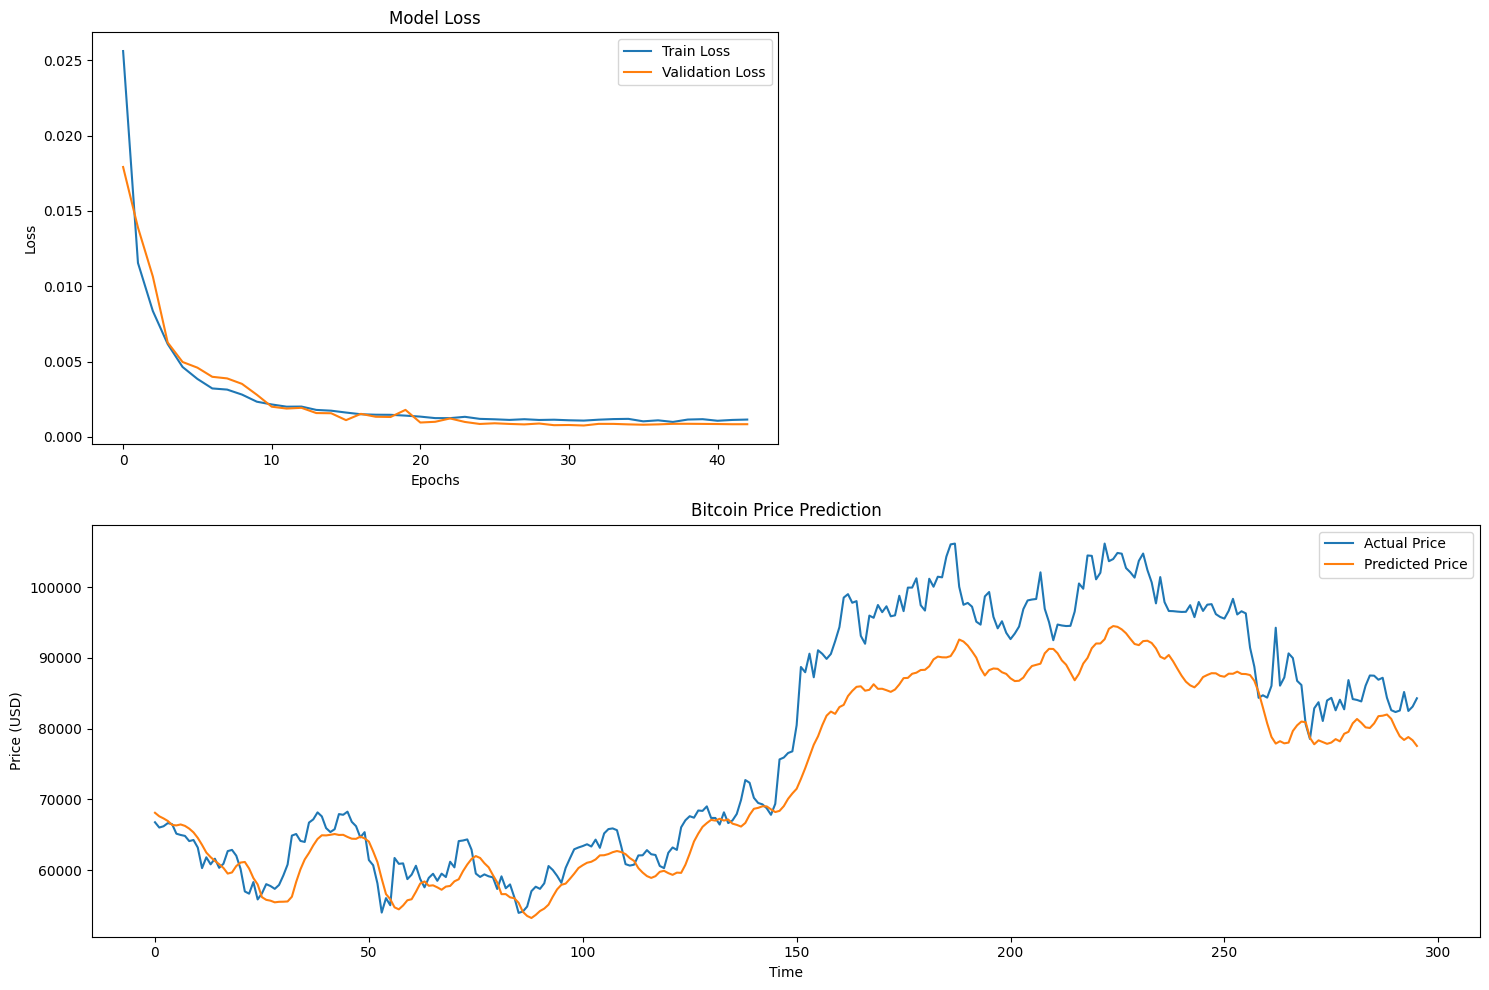

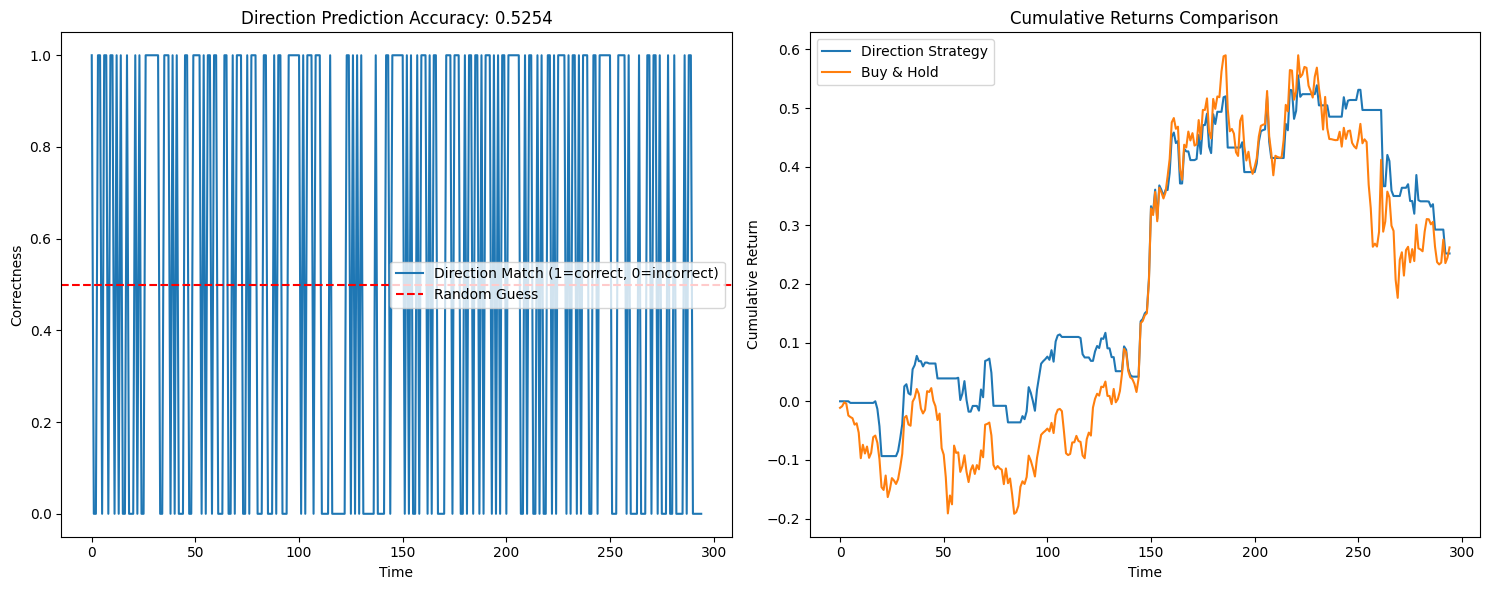


다음 30일 비트코인 가격 예측...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2025-04-05: 예측 종가 = $49442.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2025-04-06: 예측 종가 = $50820.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2025-04-07: 예측 종가 = $40044.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2025-04-08: 예측 종가 = $39252.21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2025-04-09: 예측 종가 = $36905.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2025-04-10: 예측 종가 = $35511.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2025-04-11: 예측 종가 = $27267.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2025-04-12: 예측 종가 = $26697.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2025-04-13: 예측 종가 = $24055.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2025-04-14: 예측 종가 = $19381.40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2025-04-15: 예측 종가 = $19901.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2025-04-16: 예측 종가 = $20105.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2025-04-17: 예측 종가 = $21420.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2025-04-18: 예측 종가 = $20111.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

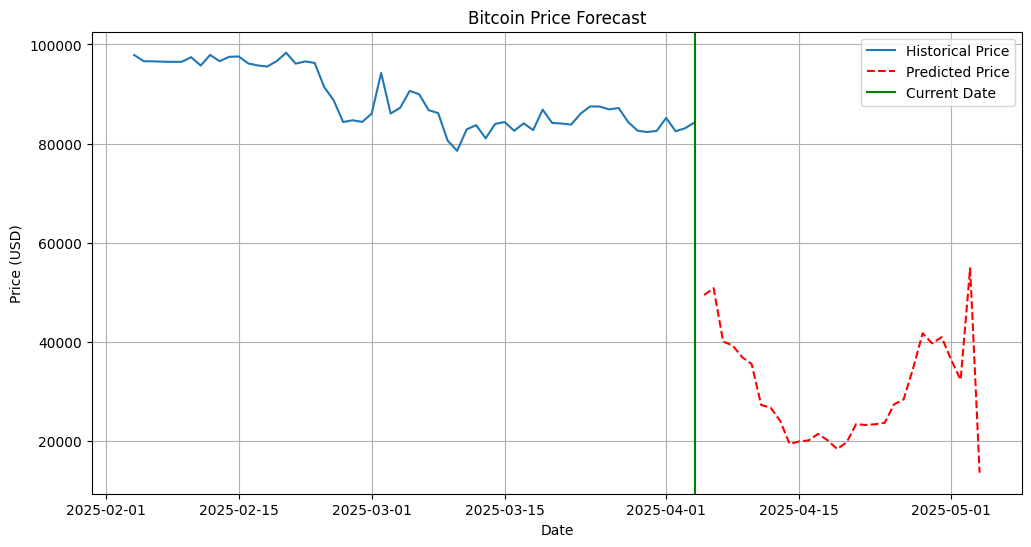

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import json
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# ------------------ 데이터 로드 및 준비 함수 ------------------

def load_btc_data(file_path=None):
    """
    OHLCV 데이터를 파일에서 로드하거나 없으면 yfinance로 다운로드
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 OHLCV 데이터 로드: {file_path}")
        btc_data = pd.read_csv(file_path)
        btc_data['Date'] = pd.to_datetime(btc_data['Date'])
        btc_data.set_index('Date', inplace=True)
        return btc_data.reset_index()
    else:
        print("yfinance에서 OHLCV 데이터 다운로드 중...")
        btc_ohlcv = yf.download("BTC-USD", period="5y", interval="1d")

        # DataFrame 구조 표준화
        if btc_ohlcv.columns.nlevels > 1:
            btc_ohlcv.columns = [col[0] for col in btc_ohlcv.columns]

        # 날짜 열 추가
        btc_ohlcv = btc_ohlcv.reset_index()

        # 데이터 저장 (선택적)
        if file_path:
            btc_ohlcv.to_csv(file_path, index=False)
            print(f"OHLCV 데이터가 {file_path}에 저장되었습니다")

        return btc_ohlcv

def load_fear_greed_data(file_path=None):
    """
    공포/탐욕 지수 데이터를 파일에서 로드하거나 없으면 API에서 다운로드
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 공포/탐욕 지수 데이터 로드: {file_path}")
        fg_data = pd.read_csv(file_path)
        fg_data['Date'] = pd.to_datetime(fg_data['Date'])
        return fg_data
    else:
        try:
            print("API에서 공포/탐욕 지수 데이터 다운로드 중...")
            import requests
            url = "https://api.alternative.me/fng/?limit=2000&format=json"
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()
                fg_data = pd.DataFrame(data['data'])
                fg_data['timestamp'] = fg_data['timestamp'].astype(int)
                fg_data['Date'] = pd.to_datetime(fg_data['timestamp'], unit='s')
                fg_data['fear_greed_index'] = fg_data['value'].astype(float)
                fg_data = fg_data[['Date', 'fear_greed_index']]

                # 데이터 저장 (선택적)
                if file_path:
                    fg_data.to_csv(file_path, index=False)
                    print(f"공포/탐욕 지수 데이터가 {file_path}에 저장되었습니다")

                return fg_data
            else:
                print(f"API 요청 실패: 상태 코드 {response.status_code}")
                return pd.DataFrame(columns=['Date', 'fear_greed_index'])
        except Exception as e:
            print(f"공포/탐욕 지수 수집 오류: {e}")
            return pd.DataFrame(columns=['Date', 'fear_greed_index'])

def load_market_cap_data(file_path=None):
    """
    시가총액 데이터를 파일에서 로드하거나 없으면 가격 데이터로부터 추정
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 시가총액 데이터 로드: {file_path}")
        market_cap_data = pd.read_csv(file_path)
        market_cap_data['Date'] = pd.to_datetime(market_cap_data['Date'])
        return market_cap_data
    else:
        # 시가총액 데이터가 없으면 빈 DataFrame 반환
        print("시가총액 데이터 파일이 없습니다. 가격 데이터로부터 추정할 예정입니다.")
        return pd.DataFrame(columns=['Date', 'market_cap'])

def estimate_market_cap(df):
    """
    가격 데이터로부터 시가총액 추정 (간단한 추정치)
    """
    if 'market_cap' not in df.columns or df['market_cap'].isna().all():
        print("시가총액 데이터 생성 중...")

        # 비트코인 유통량 추정 (각 날짜별로 다름)
        def estimate_btc_supply(date):
            """날짜에 따른 대략적인 비트코인 유통량 추정"""
            genesis_date = pd.to_datetime('2009-01-03')
            days_since_genesis = (date - genesis_date).days
            if days_since_genesis < 0:
                days_since_genesis = 0

            # 반감기 주기 기반 추정 (매우 대략적)
            blocks_per_day = 144  # 평균 10분당 1블록
            halvings = days_since_genesis // (210000 // blocks_per_day)
            reward = 50 / (2 ** halvings)

            # 최대 공급량 제한
            supply = min(21000000, days_since_genesis * blocks_per_day * reward / 2)
            return max(supply, 16000000)  # 2017년 이후로는 최소 1600만개 이상 유통

        # 각 날짜별 추정 공급량 계산
        df['estimated_supply'] = df['Date'].apply(estimate_btc_supply)

        # 시가총액 계산
        df['market_cap'] = df['Close'] * df['estimated_supply']

    return df

# ------------------ 데이터 전처리 함수 ------------------

def create_technical_indicators(df):
    """
    기술적 지표 계산
    """
    print("기술적 지표 계산 중...")

    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # 이동평균선
    df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['sma_50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
    df['sma_200'] = ta.trend.SMAIndicator(df['Close'], window=200).sma_indicator()

    # MACD
    macd_indicator = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD_12_26_9'] = macd_indicator.macd()
    df['MACDs_12_26_9'] = macd_indicator.macd_signal()
    df['MACDh_12_26_9'] = macd_indicator.macd_diff()

    # 볼린저 밴드
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['BBM_20_2.0'] = bollinger.bollinger_mavg()
    df['BBU_20_2.0'] = bollinger.bollinger_hband()
    df['BBL_20_2.0'] = bollinger.bollinger_lband()

    # 가격 모멘텀
    df['return_1d'] = df['Close'].pct_change(1)
    df['return_7d'] = df['Close'].pct_change(7)
    df['return_30d'] = df['Close'].pct_change(30)

    # 변동성 지표
    df['volatility_30d'] = df['return_1d'].rolling(window=30).std()

    # 추가 지표
    df['ema_9'] = ta.trend.EMAIndicator(df['Close'], window=9).ema_indicator()

    # 거래량 기반 지표
    df['volume_sma_20'] = ta.trend.SMAIndicator(df['Volume'], window=20).sma_indicator()
    df['volume_ratio'] = df['Volume'] / df['volume_sma_20']

    # 스토캐스틱 오실레이터
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # ATR (Average True Range)
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()

    print("기술적 지표 계산 완료")
    return df

def handle_missing_values(df):
    """
    누락값 처리
    """
    print("누락값 처리 중...")
    print("누락값 수:", df.isna().sum())

    # 기술적 지표로 인한 초기 누락값 제거
    df = df.dropna(subset=['sma_200', 'volatility_30d'])

    # 나머지 누락값은 전진 채우기
    df = df.ffill()

    # 여전히 남은 누락값이 있다면 후진 채우기
    df = df.bfill()

    return df

def handle_outliers(df):
    """
    이상치 처리
    """
    print("이상치 처리 중...")

    # 수치형 변수에 대해 IQR 방식으로 이상치 탐지 및 처리
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in ['Open', 'High', 'Low', 'Close', 'Volume']:  # 가격/거래량은 이상치 처리하지 않음
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 경계값으로 대체
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

def feature_engineering(df):
    """
    특성 엔지니어링
    """
    print("특성 엔지니어링 중...")

    # 시간 기반 특성
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # 가격과 지표 사이의 비율
    df['price_to_sma20'] = df['Close'] / df['sma_20']
    df['price_to_sma50'] = df['Close'] / df['sma_50']
    df['price_to_sma200'] = df['Close'] / df['sma_200']

    # 지연 변수 생성 (1일, 7일, 14일, 30일 전 종가)
    for lag in [1, 7, 14, 30]:
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)

    # 거래량과 가격 상호작용
    df['volume_price_change'] = df['Volume'] * df['return_1d'].abs()

    return df

def scale_features(df, target_col='Close'):
    """
    특성 스케일링
    """
    print("데이터 스케일링 중...")

    # 타겟 변수 분리
    y = df[target_col].values

    # 예측에 사용할 특성 후보 목록
    potential_features = [
        'Open', 'High', 'Low', 'Volume',
        'rsi_14', 'sma_20', 'sma_50', 'sma_200',
        'MACDh_12_26_9', 'BBL_20_2.0', 'BBU_20_2.0',
        'return_1d', 'return_7d', 'volatility_30d',
        'fear_greed_index',
        'day_of_week', 'month', 'price_to_sma20', 'price_to_sma50',
        'close_lag_1', 'close_lag_7', 'volume_price_change',
        'stoch_k', 'stoch_d', 'atr'
    ]

    # 실제로 존재하는 컬럼만 선택
    available_features = [col for col in potential_features if col in df.columns]
    print(f"사용 가능한 특성: {len(available_features)}개")
    print("사용 특성 목록:", available_features)

    X = df[available_features].values

    # 스케일링 (MinMaxScaler 사용)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler_X.fit_transform(X)

    # 타겟 변수도 스케일링
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    return X_scaled, y_scaled, scaler_X, scaler_y, available_features

def split_time_series_data(X, y, test_size=0.2, val_size=0.2):
    """
    시계열 데이터 분할 (학습/검증/테스트)
    """
    print("데이터 분할 중...")
    n_samples = len(X)

    # 테스트셋 분리
    test_split_idx = int(n_samples * (1 - test_size))
    X_train_val, X_test = X[:test_split_idx], X[test_split_idx:]
    y_train_val, y_test = y[:test_split_idx], y[test_split_idx:]

    # 검증셋 분리
    val_split_idx = int(len(X_train_val) * (1 - val_size))
    X_train, X_val = X_train_val[:val_split_idx], X_train_val[val_split_idx:]
    y_train, y_val = y_train_val[:val_split_idx], y_train_val[val_split_idx:]

    print(f"훈련 데이터: {len(X_train)} 샘플")
    print(f"검증 데이터: {len(X_val)} 샘플")
    print(f"테스트 데이터: {len(X_test)} 샘플")

    return X_train, X_val, X_test, y_train, y_val, y_test

def create_sequences(X, y, seq_length=30):
    """
    시퀀스 기반 모델(LSTM 등)을 위한 데이터 준비
    """
    X_seq, y_seq = [], []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])

    return np.array(X_seq), np.array(y_seq)

# ------------------ 모델 정의 함수 ------------------

def create_basic_model(input_shape):
    """
    기본 LSTM 모델 생성
    """
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
    return model

def create_advanced_model(input_shape):
    """
    향상된 LSTM 모델 생성
    """
    model = Sequential([
        # 양방향 LSTM 사용
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        # 두 번째 LSTM 레이어
        LSTM(64),
        BatchNormalization(),
        Dropout(0.3),

        # 완전연결 레이어
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=Huber(delta=1.0))
    return model

# ------------------ 메인 파이프라인 ------------------

def prepare_data(btc_file='btc_ohlcv.csv', fg_file='fear_greed_index.csv', market_cap_file='market_cap.csv'):
    """
    데이터 준비 파이프라인
    """
    # 1. 데이터 로드
    print("데이터 로드 중...")
    btc_data = load_btc_data(btc_file)
    fg_data = load_fear_greed_data(fg_file)
    market_cap_data = load_market_cap_data(market_cap_file)

    # 2. 데이터 병합
    print("데이터 병합 중...")
    data = btc_data.copy()

    # 공포/탐욕 지수 병합
    if not fg_data.empty:
        data['Date'] = pd.to_datetime(data['Date'])
        fg_data['Date'] = pd.to_datetime(fg_data['Date'])
        data = pd.merge(data, fg_data, on='Date', how='left')

    # 시가총액 데이터 병합
    if not market_cap_data.empty:
        data['Date'] = pd.to_datetime(data['Date'])
        market_cap_data['Date'] = pd.to_datetime(market_cap_data['Date'])
        data = pd.merge(data, market_cap_data, on='Date', how='left')

    # 시가총액 데이터가 없으면 추정
    data = estimate_market_cap(data)

    # 날짜를 인덱스로 설정
    data.set_index('Date', inplace=True)

    # 3. 기술적 지표 생성
    data = create_technical_indicators(data)

    # 4. 누락값 처리
    data = handle_missing_values(data)

    # 5. 이상치 처리
    data = handle_outliers(data)

    # 6. 특성 엔지니어링
    data = feature_engineering(data)

    # 7. 스케일링
    X_scaled, y_scaled, scaler_X, scaler_y, feature_cols = scale_features(data)

    # 8. 데이터 분할
    X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X_scaled, y_scaled)

    # 9. 시퀀스 생성
    seq_length = 30  # 30일간의 데이터로 다음 날 예측
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

    # NaN 값 처리
    X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
    X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)
    X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)
    y_train_seq = np.nan_to_num(y_train_seq, nan=0.0)
    y_val_seq = np.nan_to_num(y_val_seq, nan=0.0)
    y_test_seq = np.nan_to_num(y_test_seq, nan=0.0)

    print("데이터 준비 완료!")
    print(f"시퀀스 훈련 데이터 형태: {X_train_seq.shape}")
    print(f"시퀀스 검증 데이터 형태: {X_val_seq.shape}")
    print(f"시퀀스 테스트 데이터 형태: {X_test_seq.shape}")

    return data, X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, scaler_y, feature_cols

def train_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq, use_advanced_model=False):
    """
    모델 훈련
    """
    print("모델 훈련 시작...")

    # 모델 선택
    if use_advanced_model:
        model = create_advanced_model((X_train_seq.shape[1], X_train_seq.shape[2]))
        print("향상된 모델 사용")
    else:
        model = create_basic_model((X_train_seq.shape[1], X_train_seq.shape[2]))
        print("기본 모델 사용")

    model.summary()

    # 콜백 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        min_delta=0.0001
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        'best_bitcoin_model.h5',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )

    callbacks = [early_stopping, reduce_lr, model_checkpoint]

    # 모델 훈련
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=callbacks,
        verbose=1
    )

    # 최종 모델 저장
    model.save('final_bitcoin_prediction_model.h5')
    print("최종 모델이 저장되었습니다: 'final_bitcoin_prediction_model.h5'")

    return model, history

def evaluate_model(model, X_test_seq, y_test_seq, scaler_y):
    """
    모델 평가
    """
    print("모델 평가 중...")

    # 예측
    y_pred = model.predict(X_test_seq)

    # 스케일링 역변환
    y_test_orig = scaler_y.inverse_transform(y_test_seq)
    y_pred_orig = scaler_y.inverse_transform(y_pred)

    # NaN 값 필터링
    valid_indices = ~np.isnan(y_test_orig).any(axis=1) & ~np.isnan(y_pred_orig).any(axis=1)
    y_test_filtered = y_test_orig[valid_indices]
    y_pred_filtered = y_pred_orig[valid_indices]

    if len(y_test_filtered) > 0:
        # RMSE 계산
        rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
        print(f"RMSE: {rmse}")

        # MAE 계산
        mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
        print(f"MAE: {mae}")

        # MAPE 계산
        mape = np.mean(np.abs((y_test_filtered - y_pred_filtered) / y_test_filtered)) * 100
        print(f"MAPE: {mape:.2f}%")

        # 방향성 정확도 계산
        if len(y_test_filtered) > 1:
            y_true_dir = np.sign(np.diff(y_test_filtered, axis=0))
            y_pred_dir = np.sign(np.diff(y_pred_filtered, axis=0))
            matches = (y_true_dir == y_pred_dir).astype(int)
            dir_acc = np.mean(matches)
            print(f"방향성 정확도: {dir_acc:.4f} ({np.sum(matches)} / {len(matches)})")

            return {
                'rmse': rmse,
                'mae': mae,
                'mape': mape,
                'dir_acc': dir_acc,
                'y_test': y_test_filtered,
                'y_pred': y_pred_filtered,
                'dir_matches': matches
            }
    else:
        print("유효한 데이터가 없습니다.")

    return None

def visualize_results(history, evaluation_results):
    """
    결과 시각화
    """
    if not evaluation_results:
        print("시각화할 평가 결과가 없습니다.")
        return

    plt.figure(figsize=(15, 10))

    # 손실 그래프
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 학습률 그래프 (있는 경우)
    if 'lr' in history.history:
        plt.subplot(2, 2, 2)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.yscale('log')

    # 예측 vs 실제값 비교
    plt.subplot(2, 1, 2)
    plt.plot(evaluation_results['y_test'], label='Actual Price')
    plt.plot(evaluation_results['y_pred'], label='Predicted Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('bitcoin_model_performance.png', dpi=300)
    plt.show()

    # 방향성 예측 시각화
    if 'dir_matches' in evaluation_results:
        plt.figure(figsize=(15, 6))

        # 방향성 일치 여부
        plt.subplot(1, 2, 1)
        plt.plot(evaluation_results['dir_matches'], label='Direction Match (1=correct, 0=incorrect)')
        plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess')
        plt.title(f'Direction Prediction Accuracy: {evaluation_results["dir_acc"]:.4f}')
        plt.xlabel('Time')
        plt.ylabel('Correctness')
        plt.legend()

        # 누적 수익 시뮬레이션 (단순 방향성 기반 전략)
        plt.subplot(1, 2, 2)

        # 매일 1달러 투자 시 누적 수익 계산 (단순화)
        daily_returns = np.diff(evaluation_results['y_test'].flatten()) / evaluation_results['y_test'][:-1].flatten()

        # 전략 1: 예측 방향을 따르는 전략
        y_pred_dir = np.sign(np.diff(evaluation_results['y_pred'].flatten()))
        strategy_returns = daily_returns * (y_pred_dir > 0)
        cumulative_strategy = np.cumprod(1 + strategy_returns) - 1

        # 전략 2: 항상 매수하는 전략 (Buy & Hold)
        cumulative_buyhold = np.cumprod(1 + daily_returns) - 1

        plt.plot(cumulative_strategy, label='Direction Strategy')
        plt.plot(cumulative_buyhold, label='Buy & Hold')
        plt.title('Cumulative Returns Comparison')
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return')
        plt.legend()

        plt.tight_layout()
        plt.savefig('bitcoin_direction_performance.png', dpi=300)
        plt.show()

# ------------------ 메인 실행 코드 ------------------

def main():
    """
    메인 실행 함수
    """
    # 1. 데이터 파일 경로 설정 (없으면 None으로 설정)
    btc_file = 'btc_ohlcv.csv'  # 비트코인 OHLCV 데이터 파일
    fg_file = 'fear_greed_index.csv'  # 공포/탐욕 지수 데이터 파일
    market_cap_file = 'market_cap.csv'  # 시가총액 데이터 파일

    # 파일 존재 여부 확인
    for file_path in [btc_file, fg_file, market_cap_file]:
        if not os.path.exists(file_path):
            print(f"경고: {file_path} 파일이 존재하지 않습니다. 데이터를 다운로드하거나 추정합니다.")

    # 2. 데이터 준비
    data, X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, scaler_y, feature_cols = prepare_data(
        btc_file, fg_file, market_cap_file
    )

    # 3. 모델 훈련 (use_advanced_model=True로 설정하면 향상된 모델 사용)
    model, history = train_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq, use_advanced_model=False)

    # 4. 모델 평가
    evaluation_results = evaluate_model(model, X_test_seq, y_test_seq, scaler_y)

    # 5. 결과 시각화
    if evaluation_results:
        visualize_results(history, evaluation_results)

    # 향후 예측
    print("\n다음 30일 비트코인 가격 예측...")
    predict_future(model, data, scaler_y, feature_cols, days=30)

    return model, data, scaler_y

def predict_future(model, data, scaler_y, feature_cols, days=30):
    """
    미래 가격 예측
    """
    # 가장 최근 30일 데이터 가져오기
    last_sequence = data.iloc[-30:].copy()

    # 예측 결과 저장용 데이터프레임
    future_prices = pd.DataFrame(index=pd.date_range(
        start=data.index[-1] + pd.Timedelta(days=1),
        periods=days,
        freq='D'
    ))
    future_prices['Predicted_Close'] = np.nan

    # 일별로 예측
    for i in range(days):
        # 입력 준비
        X_input = last_sequence[feature_cols].values

        # 스케일링
        scaler_X = MinMaxScaler()
        X_scaled = scaler_X.fit_transform(X_input)

        # 모델 입력 형태로 변환 (3D)
        X_pred = X_scaled.reshape(1, 30, len(feature_cols))

        # 예측
        y_pred_scaled = model.predict(X_pred)

        # 역스케일링
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0, 0]

        # 예측값 저장
        future_date = future_prices.index[i]
        future_prices.loc[future_date, 'Predicted_Close'] = y_pred

        print(f"{future_date.strftime('%Y-%m-%d')}: 예측 종가 = ${y_pred:.2f}")

        # 다음 예측을 위해 시퀀스 업데이트 (간소화된 방식)
        # 실제 구현에서는 다른 특성들도 적절히 업데이트해야 함
        new_row = last_sequence.iloc[-1:].copy()
        new_row.index = [future_date]
        new_row['Close'] = y_pred

        # 시퀀스 업데이트 (첫 번째 행 제거, 새 행 추가)
        last_sequence = pd.concat([last_sequence.iloc[1:], new_row])

    # 결과 시각화
    plt.figure(figsize=(12, 6))

    # 과거 실제 가격
    plt.plot(data.index[-60:], data['Close'].values[-60:], label='Historical Price')

    # 미래 예측 가격
    plt.plot(future_prices.index, future_prices['Predicted_Close'].values, 'r--', label='Predicted Price')

    # 현재 시점 표시
    plt.axvline(x=data.index[-1], color='g', linestyle='-', label='Current Date')

    plt.title('Bitcoin Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig('bitcoin_forecast.png', dpi=300)
    plt.show()

    return future_prices

if __name__ == "__main__":
    main()

모델 로드 중: final_bitcoin_prediction_model.h5
데이터 로드 중: btc_ohlcv.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

다음 날 비트코인 예상 가격: $7677.57


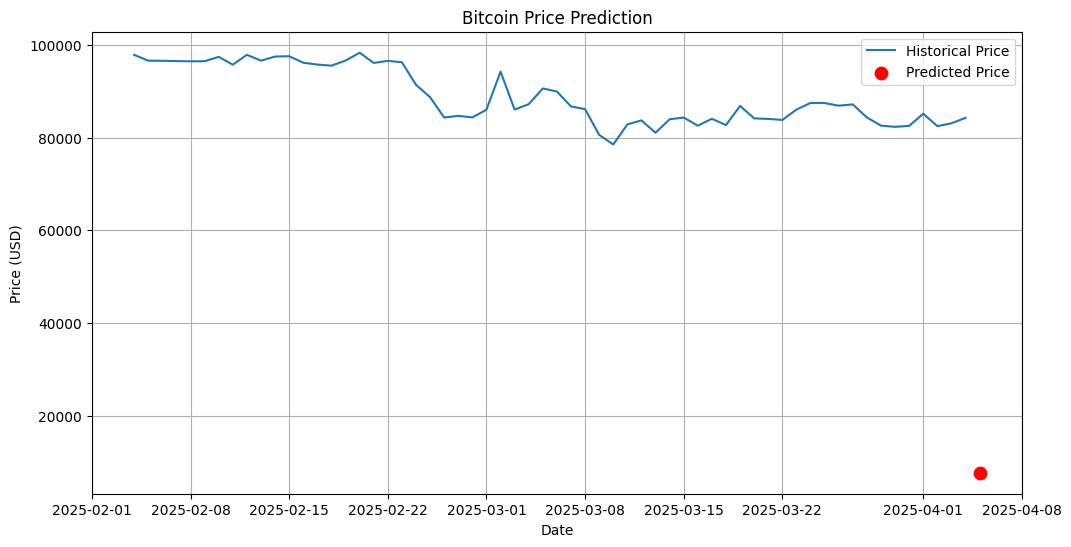

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 학습된 모델이 이미 있는 경우, 빠른 예측만 실행하는 스크립트

def quick_predict(model_file='final_bitcoin_prediction_model.h5',
                  data_file='btc_ohlcv.csv',
                  days=30):
    """
    저장된 모델을 사용하여 빠르게 예측 실행
    """
    if not os.path.exists(model_file):
        print(f"오류: {model_file} 모델 파일이 존재하지 않습니다.")
        return

    if not os.path.exists(data_file):
        print(f"오류: {data_file} 데이터 파일이 존재하지 않습니다.")
        return

    print(f"모델 로드 중: {model_file}")
    model = load_model(model_file)

    print(f"데이터 로드 중: {data_file}")
    data = pd.read_csv(data_file)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # 간단한 특성 선택 (실제론 model 훈련 시 사용한 특성과 일치해야 함)
    features = ['Close', 'Open', 'High', 'Low', 'Volume']
    features = [f for f in features if f in data.columns]

    # 최근 30일 데이터
    last_sequence = data.iloc[-30:][features].values

    # 스케일링
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Close 가격 스케일링 (y용)
    close_prices = data['Close'].values.reshape(-1, 1)
    scaler_y.fit(close_prices)

    # 입력 데이터 스케일링
    X_scaled = scaler_X.fit_transform(last_sequence)

    # 모델 입력 형태로 변환 (3D)
    X_pred = X_scaled.reshape(1, 30, len(features))

    # 예측
    y_pred_scaled = model.predict(X_pred)

    # 역스케일링
    next_price = scaler_y.inverse_transform(y_pred_scaled)[0, 0]

    print(f"\n다음 날 비트코인 예상 가격: ${next_price:.2f}")

    # 최근 가격 추세와 예측 시각화
    plt.figure(figsize=(12, 6))

    # 최근 60일 실제 가격
    recent_dates = data.index[-60:]
    recent_prices = data['Close'].values[-60:]
    plt.plot(recent_dates, recent_prices, label='Historical Price')

    # 다음 날 예측 가격
    next_date = recent_dates[-1] + pd.Timedelta(days=1)
    plt.scatter(next_date, next_price, color='red', s=80, marker='o', label='Predicted Price')

    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig('quick_prediction.png', dpi=300)
    plt.show()

    return next_price

if __name__ == "__main__":
    quick_predict()

## GRU + LSTM 하이브리드 모델

데이터 로드 중...
파일에서 OHLCV 데이터 로드: data/btc_ohlcv.csv
파일에서 공포/탐욕 지수 데이터 로드: data/fear_greed_index.csv
시가총액 데이터 파일이 없습니다. 가격 데이터로부터 추정할 예정입니다.
데이터 병합 중...
시가총액 데이터 생성 중...
기술적 지표 계산 중...
기술적 지표 계산 완료
누락값 처리 중...
누락값 수: Close                 0
High                  0
Low                   0
Open                  0
Volume                0
fear_greed_index      1
estimated_supply      0
market_cap            0
rsi_14               13
sma_20               19
sma_50               49
sma_200             199
MACD_12_26_9         25
MACDs_12_26_9        33
MACDh_12_26_9        33
BBM_20_2.0           19
BBU_20_2.0           19
BBL_20_2.0           19
return_1d             1
return_7d             7
return_30d           30
volatility_30d       30
ema_9                 8
volume_sma_20        19
volume_ratio         19
stoch_k              13
stoch_d              15
atr                   0
dtype: int64
이상치 처리 중...
특성 엔지니어링 중...
데이터 스케일링 중...
사용 가능한 특성: 25개
사용 특성 목록: ['Open', 'High', 'Low', 'Volume', 'r

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 30, 64)              │          17,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,729 (475.50 KB)

 Trainable params: 121,345 (474.00 KB)

 Non-trainable params: 384 (1.50 KB)

None

모델 학습 시작...
Epoch 1/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6277
Epoch 1: val_loss improved from inf to 0.13195, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.6134 - val_loss: 0.1320 - learning_rate: 0.0010
Epoch 2/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1265
Epoch 2: val_loss improved from 0.13195 to 0.11849, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1244 - val_loss: 0.1185 - learning_rate: 0.0010
Epoch 3/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0604
Epoch 3: val_loss improved from 0.11849 to 0.08858, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0605 - val_loss: 0.0886 - learning_rate: 0.0010
Epoch 4/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0450
Epoch 4: val_loss improved from 0.08858 to 0.05920, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0449 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0267
Epoch 5: val_loss improved from 0.05920 to 0.04092, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0267 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 6/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0246
Epoch 6: val_loss improved from 0.04092 to 0.03525, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0243 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 7/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0202
Epoch 7: val_loss improved from 0.03525 to 0.03464, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0201 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 8/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0145
Epoch 8: val_loss improved from 0.03464 to 0.03394, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0145 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 9/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117
Epoch 9: val_loss improved from 0.03394 to 0.02135, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0117 - val_loss: 0.0214 - learning_rate: 0.0010
Epoch 10/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 10: val_loss improved from 0.02135 to 0.01656, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0112 - val_loss: 0.0166 - learning_rate: 0.0010
Epoch 11/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106
Epoch 11: val_loss improved from 0.01656 to 0.01654, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0106 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 12/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088
Epoch 12: val_loss improved from 0.01654 to 0.01223, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0087 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 13/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071
Epoch 13: val_loss did not improve from 0.01223
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - val_loss: 0.0150 - learning_rate: 0.0010
Epoch 14/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064
Epoch 14: val_loss improved from 0.01223 to 0.01148, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0064 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 15/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086
Epoch 15: val_loss improved from 0.01148 to 0.00729, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0085 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 16/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060
Epoch 16: val_loss did not improve from 0.00729
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 17/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069
Epoch 17: val_loss improved from 0.00729 to 0.00675, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 18/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059
Epoch 18: val_loss did not improve from 0.00675
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 19/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043
Epoch 19: val_loss did not improve from 0.00675
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 20/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045
Epoch 20: val_loss did not improve from 0.00675
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 21/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042
Epoch 21: val_loss improved from 0.00675 to 0.00663, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 22/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050
Epoch 22: val_loss improved from 0.00663 to 0.00426, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0049 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 23/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0046
Epoch 23: val_loss did not improve from 0.00426
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0046 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 24/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059
Epoch 24: val_loss did not improve from 0.00426
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0058 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 25/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043
Epoch 25: val_loss improved from 0.00426 to 0.00386, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 26/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040
Epoch 26: val_loss improved from 0.00386 to 0.00373, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 27/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0038
Epoch 27: val_loss improved from 0.00373 to 0.00351, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0038 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 28/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0036
Epoch 28: val_loss improved from 0.00351 to 0.00338, saving model to saved_models/bitcoin_hybrid_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 29/100
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035
Epoch 29: val_loss did not improve from 0.00338
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 30/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034
Epoch 30: val_loss did not improve from 0.00338
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 31/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033
Epoch 31: val_loss did not improve from 0.00338
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 32/100
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031
Epoch 32: val_loss did not improve from 0.00338
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 33/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11m


모델 학습 완료
최상의 모델을 'saved_models/bitcoin_hybrid_model.h5'에서 로드했습니다.

모델 평가 중...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
평가 지표:
RMSE: $22016.20
MAE: $17510.15
MAPE: 19.88%
방향성 정확도: 48.81%


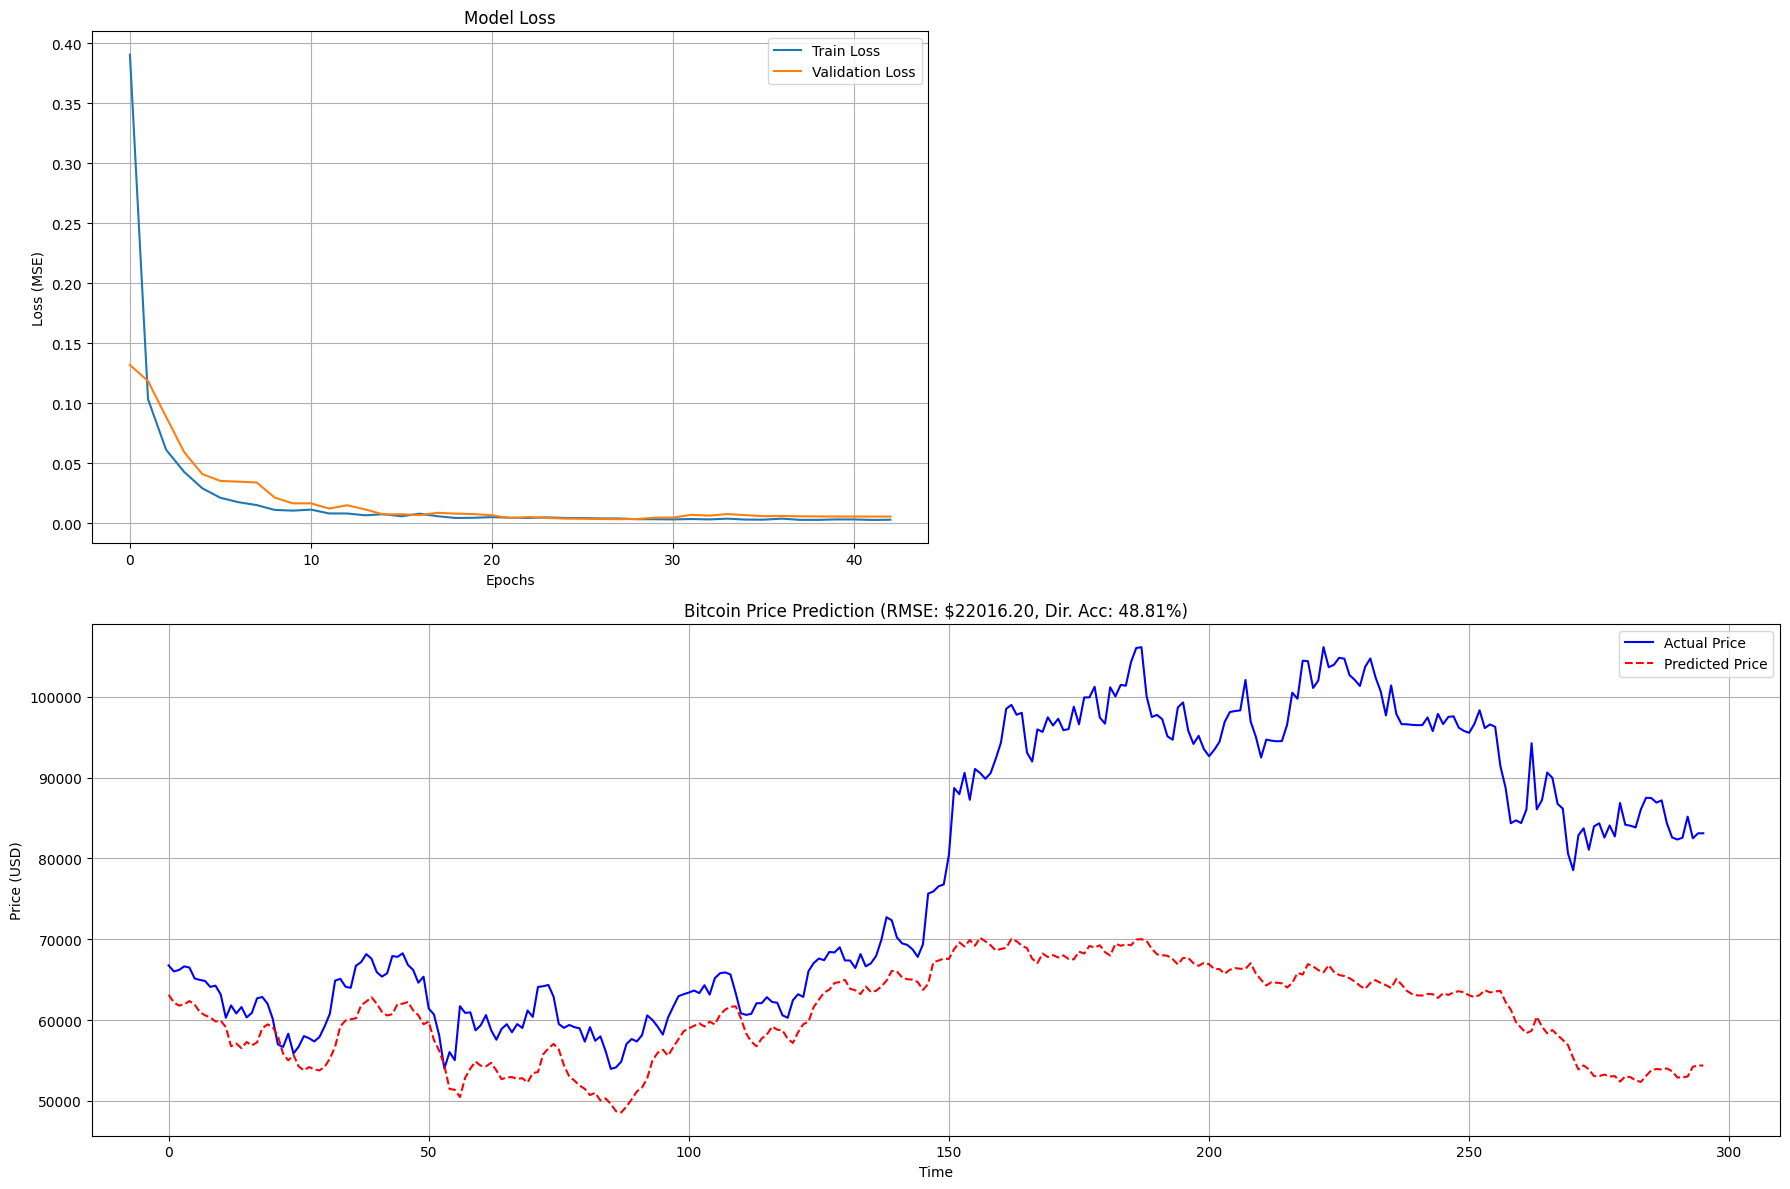

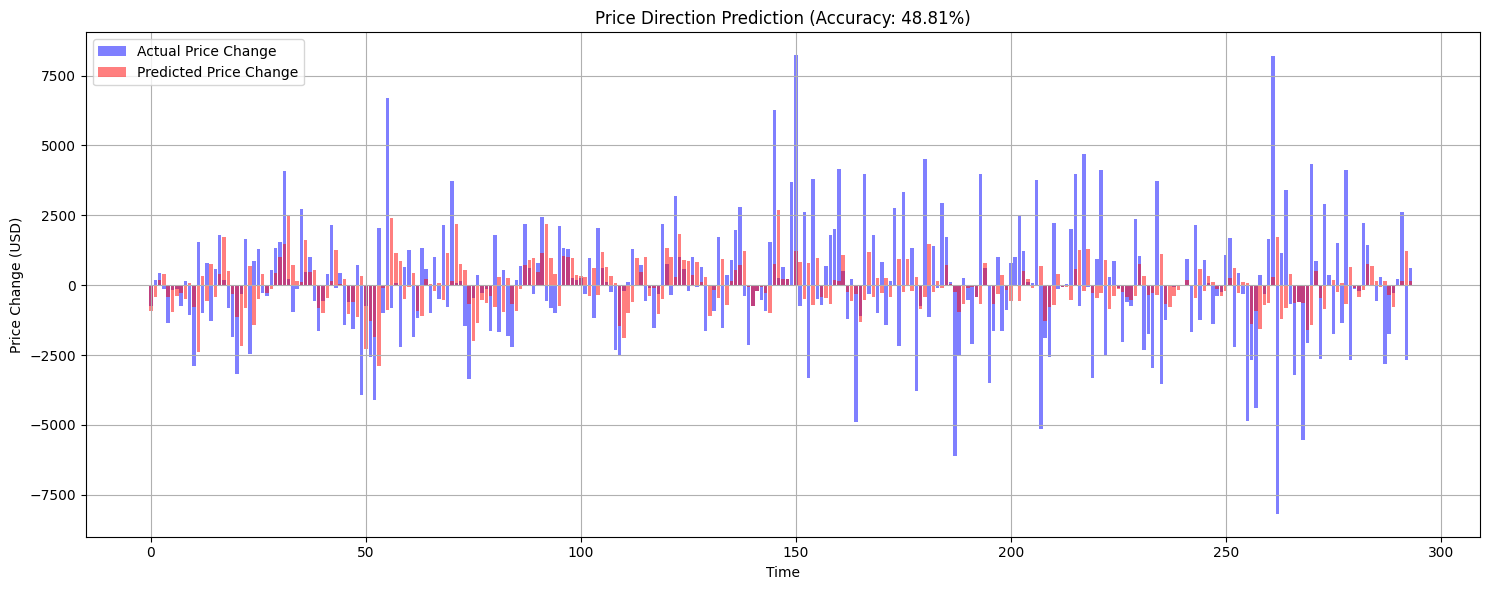


미래 30일 예측...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<ipython-input-4-3330db8c6e14>:618: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[target_idx] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

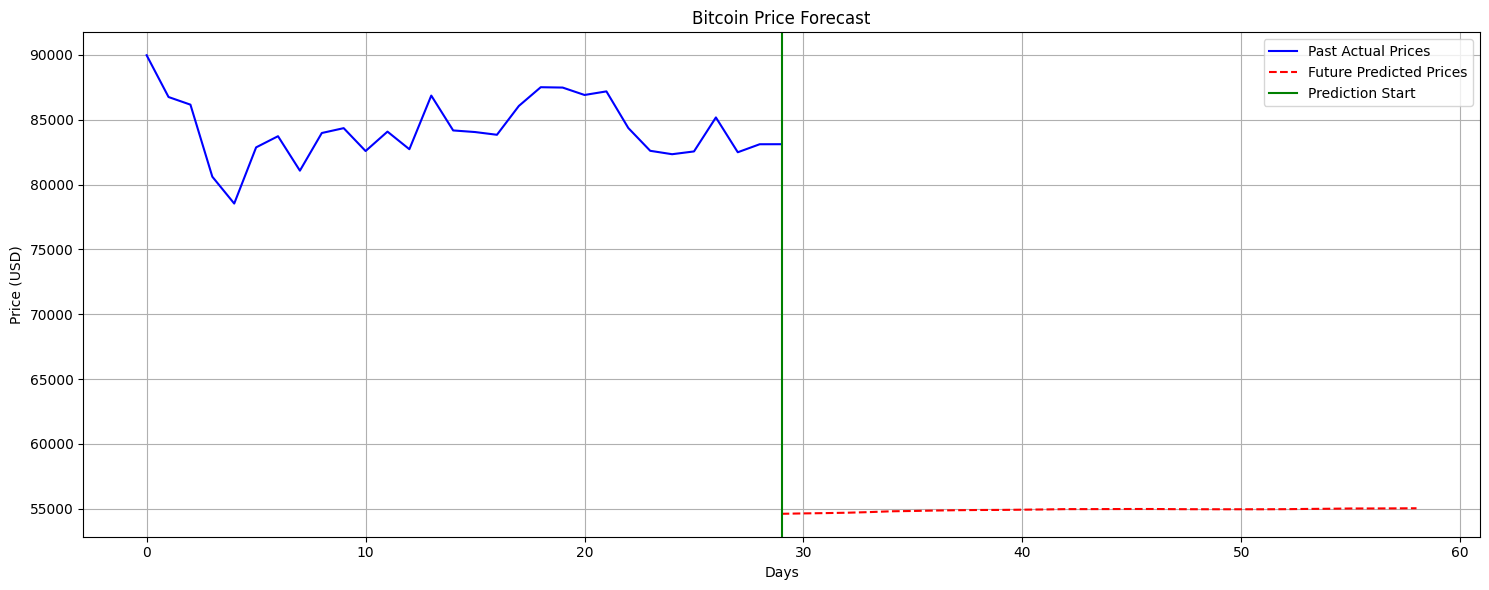


최종 결과 요약:
RMSE: $22016.20
MAE: $17510.15
MAPE: 19.88%
방향성 정확도: 48.81%

모델 훈련 및 평가 완료!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import json
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

# ------------------ 데이터 로드 및 준비 함수 ------------------

def load_btc_data(file_path=None):
    """
    OHLCV 데이터를 파일에서 로드하거나 없으면 yfinance로 다운로드
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 OHLCV 데이터 로드: {file_path}")
        btc_data = pd.read_csv(file_path)
        btc_data['Date'] = pd.to_datetime(btc_data['Date'])
        btc_data.set_index('Date', inplace=True)
        return btc_data.reset_index()
    else:
        print("yfinance에서 OHLCV 데이터 다운로드 중...")
        btc_ohlcv = yf.download("BTC-USD", period="5y", interval="1d")

        # DataFrame 구조 표준화
        if btc_ohlcv.columns.nlevels > 1:
            btc_ohlcv.columns = [col[0] for col in btc_ohlcv.columns]

        # 날짜 열 추가
        btc_ohlcv = btc_ohlcv.reset_index()

        # 데이터 저장 (선택적)
        if file_path:
            btc_ohlcv.to_csv(file_path, index=False)
            print(f"OHLCV 데이터가 {file_path}에 저장되었습니다")

        return btc_ohlcv

def load_fear_greed_data(file_path=None):
    """
    공포/탐욕 지수 데이터를 파일에서 로드하거나 없으면 API에서 다운로드
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 공포/탐욕 지수 데이터 로드: {file_path}")
        fg_data = pd.read_csv(file_path)
        fg_data['Date'] = pd.to_datetime(fg_data['Date'])
        return fg_data
    else:
        try:
            print("API에서 공포/탐욕 지수 데이터 다운로드 중...")
            import requests
            url = "https://api.alternative.me/fng/?limit=2000&format=json"
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()
                fg_data = pd.DataFrame(data['data'])
                fg_data['timestamp'] = fg_data['timestamp'].astype(int)
                fg_data['Date'] = pd.to_datetime(fg_data['timestamp'], unit='s')
                fg_data['fear_greed_index'] = fg_data['value'].astype(float)
                fg_data = fg_data[['Date', 'fear_greed_index']]

                # 데이터 저장 (선택적)
                if file_path:
                    fg_data.to_csv(file_path, index=False)
                    print(f"공포/탐욕 지수 데이터가 {file_path}에 저장되었습니다")

                return fg_data
            else:
                print(f"API 요청 실패: 상태 코드 {response.status_code}")
                return pd.DataFrame(columns=['Date', 'fear_greed_index'])
        except Exception as e:
            print(f"공포/탐욕 지수 수집 오류: {e}")
            return pd.DataFrame(columns=['Date', 'fear_greed_index'])

def load_market_cap_data(file_path=None):
    """
    시가총액 데이터를 파일에서 로드하거나 없으면 가격 데이터로부터 추정
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 시가총액 데이터 로드: {file_path}")
        market_cap_data = pd.read_csv(file_path)
        market_cap_data['Date'] = pd.to_datetime(market_cap_data['Date'])
        return market_cap_data
    else:
        # 시가총액 데이터가 없으면 빈 DataFrame 반환
        print("시가총액 데이터 파일이 없습니다. 가격 데이터로부터 추정할 예정입니다.")
        return pd.DataFrame(columns=['Date', 'market_cap'])

def estimate_market_cap(df):
    """
    가격 데이터로부터 시가총액 추정 (간단한 추정치)
    """
    if 'market_cap' not in df.columns or df['market_cap'].isna().all():
        print("시가총액 데이터 생성 중...")

        # 비트코인 유통량 추정 (각 날짜별로 다름)
        def estimate_btc_supply(date):
            """날짜에 따른 대략적인 비트코인 유통량 추정"""
            genesis_date = pd.to_datetime('2009-01-03')
            days_since_genesis = (date - genesis_date).days
            if days_since_genesis < 0:
                days_since_genesis = 0

            # 반감기 주기 기반 추정 (매우 대략적)
            blocks_per_day = 144  # 평균 10분당 1블록
            halvings = days_since_genesis // (210000 // blocks_per_day)
            reward = 50 / (2 ** halvings)

            # 최대 공급량 제한
            supply = min(21000000, days_since_genesis * blocks_per_day * reward / 2)
            return max(supply, 16000000)  # 2017년 이후로는 최소 1600만개 이상 유통

        # 각 날짜별 추정 공급량 계산
        df['estimated_supply'] = df['Date'].apply(estimate_btc_supply)

        # 시가총액 계산
        df['market_cap'] = df['Close'] * df['estimated_supply']

    return df

# ------------------ 데이터 전처리 함수 ------------------

def create_technical_indicators(df):
    """
    기술적 지표 계산
    """
    print("기술적 지표 계산 중...")

    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # 이동평균선
    df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['sma_50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
    df['sma_200'] = ta.trend.SMAIndicator(df['Close'], window=200).sma_indicator()

    # MACD
    macd_indicator = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD_12_26_9'] = macd_indicator.macd()
    df['MACDs_12_26_9'] = macd_indicator.macd_signal()
    df['MACDh_12_26_9'] = macd_indicator.macd_diff()

    # 볼린저 밴드
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['BBM_20_2.0'] = bollinger.bollinger_mavg()
    df['BBU_20_2.0'] = bollinger.bollinger_hband()
    df['BBL_20_2.0'] = bollinger.bollinger_lband()

    # 가격 모멘텀
    df['return_1d'] = df['Close'].pct_change(1)
    df['return_7d'] = df['Close'].pct_change(7)
    df['return_30d'] = df['Close'].pct_change(30)

    # 변동성 지표
    df['volatility_30d'] = df['return_1d'].rolling(window=30).std()

    # 추가 지표
    df['ema_9'] = ta.trend.EMAIndicator(df['Close'], window=9).ema_indicator()

    # 거래량 기반 지표
    df['volume_sma_20'] = ta.trend.SMAIndicator(df['Volume'], window=20).sma_indicator()
    df['volume_ratio'] = df['Volume'] / df['volume_sma_20']

    # 스토캐스틱 오실레이터
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # ATR (Average True Range)
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()

    print("기술적 지표 계산 완료")
    return df

def handle_missing_values(df):
    """
    누락값 처리
    """
    print("누락값 처리 중...")
    print("누락값 수:", df.isna().sum())

    # 기술적 지표로 인한 초기 누락값 제거
    df = df.dropna(subset=['sma_200', 'volatility_30d'])

    # 나머지 누락값은 전진 채우기
    df = df.ffill()

    # 여전히 남은 누락값이 있다면 후진 채우기
    df = df.bfill()

    return df

def handle_outliers(df):
    """
    이상치 처리
    """
    print("이상치 처리 중...")

    # 수치형 변수에 대해 IQR 방식으로 이상치 탐지 및 처리
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in ['Open', 'High', 'Low', 'Close', 'Volume']:  # 가격/거래량은 이상치 처리하지 않음
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 경계값으로 대체
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

def feature_engineering(df):
    """
    특성 엔지니어링
    """
    print("특성 엔지니어링 중...")

    # 시간 기반 특성
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # 가격과 지표 사이의 비율
    df['price_to_sma20'] = df['Close'] / df['sma_20']
    df['price_to_sma50'] = df['Close'] / df['sma_50']
    df['price_to_sma200'] = df['Close'] / df['sma_200']

    # 지연 변수 생성 (1일, 7일, 14일, 30일 전 종가)
    for lag in [1, 7, 14, 30]:
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)

    # 거래량과 가격 상호작용
    df['volume_price_change'] = df['Volume'] * df['return_1d'].abs()

    return df

def scale_features(df, target_col='Close'):
    """
    특성 스케일링
    """
    print("데이터 스케일링 중...")

    # 타겟 변수 분리
    y = df[target_col].values

    # 예측에 사용할 특성 후보 목록
    potential_features = [
        'Open', 'High', 'Low', 'Volume',
        'rsi_14', 'sma_20', 'sma_50', 'sma_200',
        'MACDh_12_26_9', 'BBL_20_2.0', 'BBU_20_2.0',
        'return_1d', 'return_7d', 'volatility_30d',
        'fear_greed_index',
        'day_of_week', 'month', 'price_to_sma20', 'price_to_sma50',
        'close_lag_1', 'close_lag_7', 'volume_price_change',
        'stoch_k', 'stoch_d', 'atr'
    ]

    # 실제로 존재하는 컬럼만 선택
    available_features = [col for col in potential_features if col in df.columns]
    print(f"사용 가능한 특성: {len(available_features)}개")
    print("사용 특성 목록:", available_features)

    X = df[available_features].values

    # 스케일링 (MinMaxScaler 사용)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler_X.fit_transform(X)

    # 타겟 변수도 스케일링
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    return X_scaled, y_scaled, scaler_X, scaler_y, available_features

def split_time_series_data(X, y, test_size=0.2, val_size=0.2):
    """
    시계열 데이터 분할 (학습/검증/테스트)
    """
    print("데이터 분할 중...")
    n_samples = len(X)

    # 테스트셋 분리
    test_split_idx = int(n_samples * (1 - test_size))
    X_train_val, X_test = X[:test_split_idx], X[test_split_idx:]
    y_train_val, y_test = y[:test_split_idx], y[test_split_idx:]

    # 검증셋 분리
    val_split_idx = int(len(X_train_val) * (1 - val_size))
    X_train, X_val = X_train_val[:val_split_idx], X_train_val[val_split_idx:]
    y_train, y_val = y_train_val[:val_split_idx], y_train_val[val_split_idx:]

    print(f"훈련 데이터: {len(X_train)} 샘플")
    print(f"검증 데이터: {len(X_val)} 샘플")
    print(f"테스트 데이터: {len(X_test)} 샘플")

    return X_train, X_val, X_test, y_train, y_val, y_test

def create_sequences(X, y, seq_length=30):
    """
    시퀀스 기반 모델(LSTM 등)을 위한 데이터 준비
    """
    X_seq, y_seq = [], []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])

    return np.array(X_seq), np.array(y_seq)

# ------------------ LSTM + GRU 하이브리드 모델 정의 ------------------

def create_hybrid_model(input_shape, lstm_units=128, gru_units=64, dropout_rate=0.3):
    """
    LSTM + GRU 하이브리드 모델 생성 함수

    Parameters:
    -----------
    input_shape : tuple
        입력 데이터 형태 (시퀀스 길이, 특성 수)
    lstm_units : int, default=128
        LSTM 레이어의 유닛 수
    gru_units : int, default=64
        GRU 레이어의 유닛 수
    dropout_rate : float, default=0.3
        드롭아웃 비율

    Returns:
    --------
    model : tensorflow.keras.Model
        컴파일된 하이브리드 모델
    """
    model = Sequential()

    # GRU 레이어
    model.add(GRU(gru_units,
                 return_sequences=True,
                 input_shape=input_shape,
                 recurrent_dropout=0.0))  # GPU 사용 시 recurrent_dropout=0 권장
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # LSTM 레이어
    model.add(LSTM(lstm_units,
                  return_sequences=False,
                  recurrent_dropout=0.0))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # 완전 연결 레이어
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))  # 출력 레이어

    # 모델 컴파일
    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # 그래디언트 클리핑 적용
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    print(model.summary())
    return model

# ------------------ 모델 학습 및 평가 함수 ------------------

def train_model(model, X_train_seq, y_train_seq, X_val_seq, y_val_seq,
                batch_size=32, epochs=100, patience=15):
    """
    모델 학습 함수
    """
    # 모델 저장 경로
    model_dir = "saved_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "bitcoin_hybrid_model.h5")

    # 텐서보드 로그 경로
    log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(log_dir, exist_ok=True)

    # 콜백 정의
    callbacks = [
        # 조기 종료
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        # 학습률 감소
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # 모델 체크포인트
        ModelCheckpoint(
            filepath=model_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        # 텐서보드
        TensorBoard(log_dir=log_dir)
    ]

    # 모델 학습
    print(f"\n{'='*50}\n모델 학습 시작...\n{'='*50}")
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    print(f"\n{'='*50}\n모델 학습 완료\n{'='*50}")

    # 최상의 모델 로드
    if os.path.exists(model_path):
        model = load_model(model_path)
        print(f"최상의 모델을 '{model_path}'에서 로드했습니다.")

    return model, history

def evaluate_model(model, X_test_seq, y_test_seq, scaler_y):
    """
    모델 평가 함수

    Parameters:
    -----------
    model : tensorflow.keras.Model
        평가할 모델
    X_test_seq, y_test_seq : numpy.ndarray
        테스트 시퀀스 데이터
    y_scaler : MinMaxScaler
        타겟 스케일러

    Returns:
    --------
    metrics : dict
        평가 지표 딕셔너리
    y_test_orig : numpy.ndarray
        원본 스케일 실제값
    y_pred_orig : numpy.ndarray
        원본 스케일 예측값
    """
    print(f"\n{'='*50}\n모델 평가 중...\n{'='*50}")

    # 예측
    y_pred = model.predict(X_test_seq)

    # 스케일링 역변환
    y_test_orig = scaler_y.inverse_transform(y_test_seq)
    y_pred_orig = scaler_y.inverse_transform(y_pred)

    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    # 방향성 정확도 계산
    y_test_diff = np.diff(y_test_orig.reshape(-1))
    y_pred_diff = np.diff(y_pred_orig.reshape(-1))
    direction_accuracy = np.mean((y_test_diff > 0) == (y_pred_diff > 0)) * 100

    metrics = {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'direction_accuracy': direction_accuracy
    }

    print(f"평가 지표:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"방향성 정확도: {direction_accuracy:.2f}%")

    return metrics, y_test_orig, y_pred_orig

# ------------------ 결과 시각화 함수 ------------------

def visualize_results(history, y_test_orig, y_pred_orig, metrics):
    """
    모델 결과 시각화 함수

    Parameters:
    -----------
    history : tensorflow.keras.callbacks.History
        학습 이력
    y_test_orig : numpy.ndarray
        원본 스케일 실제값
    y_pred_orig : numpy.ndarray
        원본 스케일 예측값
    metrics : dict
        평가 지표 딕셔너리
    """
    plt.figure(figsize=(18, 12))

    # 손실 곡선
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)

    # 학습률 변화 (있을 경우)
    if 'lr' in history.history:
        plt.subplot(2, 2, 2)
        plt.plot(history.history['lr'])
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
        plt.grid(True)

    # 예측 vs 실제 가격
    plt.subplot(2, 1, 2)
    plt.plot(y_test_orig, label='Actual Price', color='blue')
    plt.plot(y_pred_orig, label='Predicted Price', color='red', linestyle='--')
    plt.title(f'Bitcoin Price Prediction (RMSE: ${metrics["rmse"]:.2f}, Dir. Acc: {metrics["direction_accuracy"]:.2f}%)')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('bitcoin_prediction_results.png', dpi=300)
    plt.show()

    # 방향성 예측 시각화
    plt.figure(figsize=(15, 6))

    # 가격 변화
    y_test_diff = np.diff(y_test_orig.reshape(-1))
    y_pred_diff = np.diff(y_pred_orig.reshape(-1))

    plt.bar(range(len(y_test_diff)), y_test_diff, alpha=0.5, color='blue', label='Actual Price Change')
    plt.bar(range(len(y_pred_diff)), y_pred_diff, alpha=0.5, color='red', label='Predicted Price Change')
    plt.title(f'Price Direction Prediction (Accuracy: {metrics["direction_accuracy"]:.2f}%)')
    plt.xlabel('Time')
    plt.ylabel('Price Change (USD)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('bitcoin_direction_prediction.png', dpi=300)
    plt.show()

# ------------------ 미래 예측 함수 ------------------
def predict_future(model, last_sequence, n_future=30, X_scaler=None, y_scaler=None):
    """
    미래 가격 예측 함수

    Parameters:
    -----------
    model : tensorflow.keras.Model
        학습된 모델
    last_sequence : numpy.ndarray
        마지막 시퀀스 데이터
    n_future : int, default=30
        예측할 미래 일수
    X_scaler : MinMaxScaler
        특성 스케일러
    y_scaler : MinMaxScaler
        타겟 스케일러

    Returns:
    --------
    future_pred_orig : numpy.ndarray
        원본 스케일 미래 예측값
    """
    print(f"\n{'='*50}\n미래 {n_future}일 예측...\n{'='*50}")

    # 마지막 시퀀스 복사
    curr_sequence = last_sequence.copy()
    future_pred = []

    for _ in range(n_future):
        # 현재 시퀀스로 다음 값 예측
        pred = model.predict(curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1]))[0]
        future_pred.append(pred)

        # 시퀀스 업데이트 (첫 번째 행 제거, 예측 값 추가)
        # 예측 값을 포함한 새 행 생성 (마지막 행을 복사하고 예측값만 변경)
        new_row = curr_sequence[-1].copy()
        # target_idx는 y값에 해당하는 인덱스 (보통 'Close' 값 인덱스)
        # 여기서는 예시로 0번째 인덱스를 사용 (실제로는 적절한 인덱스를 지정해야 함)
        target_idx = 0  # Close 값 인덱스
        new_row[target_idx] = pred

        # 새 시퀀스 생성
        curr_sequence = np.vstack([curr_sequence[1:], new_row])

    # 역스케일링
    if y_scaler is not None:
        future_pred_orig = y_scaler.inverse_transform(np.array(future_pred))
    else:
        future_pred_orig = np.array(future_pred)

    return future_pred_orig

# ------------------ 메인 실행 함수 ------------------

def prepare_data(btc_file='btc_ohlcv.csv', fg_file='fear_greed_index.csv', market_cap_file='market_cap.csv'):
    """
    데이터 준비 파이프라인
    """
    # 1. 데이터 로드
    print("데이터 로드 중...")
    btc_data = load_btc_data(btc_file)
    fg_data = load_fear_greed_data(fg_file)
    market_cap_data = load_market_cap_data(market_cap_file)

    # 2. 데이터 병합
    print("데이터 병합 중...")
    data = btc_data.copy()

    # 공포/탐욕 지수 병합
    if not fg_data.empty:
        data['Date'] = pd.to_datetime(data['Date'])
        fg_data['Date'] = pd.to_datetime(fg_data['Date'])
        data = pd.merge(data, fg_data, on='Date', how='left')

    # 시가총액 데이터 병합
    if not market_cap_data.empty:
        data['Date'] = pd.to_datetime(data['Date'])
        market_cap_data['Date'] = pd.to_datetime(market_cap_data['Date'])
        data = pd.merge(data, market_cap_data, on='Date', how='left')

    # 시가총액 데이터가 없으면 추정
    data = estimate_market_cap(data)

    # 날짜를 인덱스로 설정
    data.set_index('Date', inplace=True)

    # 3. 기술적 지표 생성
    data = create_technical_indicators(data)

    # 4. 누락값 처리
    data = handle_missing_values(data)

    # 5. 이상치 처리
    data = handle_outliers(data)

    # 6. 특성 엔지니어링
    data = feature_engineering(data)

    # 7. 스케일링
    X_scaled, y_scaled, scaler_X, scaler_y, feature_cols = scale_features(data)

    # 8. 데이터 분할
    X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X_scaled, y_scaled)

    # 9. 시퀀스 생성
    seq_length = 30  # 30일간의 데이터로 다음 날 예측
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

    # NaN 값 처리
    X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
    X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)
    X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)
    y_train_seq = np.nan_to_num(y_train_seq, nan=0.0)
    y_val_seq = np.nan_to_num(y_val_seq, nan=0.0)
    y_test_seq = np.nan_to_num(y_test_seq, nan=0.0)

    print("데이터 준비 완료!")
    print(f"시퀀스 훈련 데이터 형태: {X_train_seq.shape}")
    print(f"시퀀스 검증 데이터 형태: {X_val_seq.shape}")
    print(f"시퀀스 테스트 데이터 형태: {X_test_seq.shape}")

    return {
        'df': data,
        'X_scaled': X_scaled,
        'y_scaled': y_scaled,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': feature_cols,
        'X_train_seq': X_train_seq,
        'y_train_seq': y_train_seq,
        'X_val_seq': X_val_seq,
        'y_val_seq': y_val_seq,
        'X_test_seq': X_test_seq,
        'y_test_seq': y_test_seq,
        'seq_length': seq_length
    }

def run_bitcoin_prediction(btc_file='btc_ohlcv.csv',
                          fg_file='fear_greed_index.csv',
                          market_cap_file='market_cap.csv',
                          batch_size=32,
                          epochs=100,
                          patience=15,
                          predict_days=30):
    """
    비트코인 가격 예측 파이프라인 실행

    Parameters:
    -----------
    btc_file : str, default='btc_ohlcv.csv'
        비트코인 OHLCV 데이터 파일 경로
    fg_file : str, default='fear_greed_index.csv'
        공포/탐욕 지수 데이터 파일 경로
    market_cap_file : str, default='market_cap.csv'
        시가총액 데이터 파일 경로
    batch_size : int, default=32
        훈련 배치 크기
    epochs : int, default=100
        최대 훈련 에포크 수
    patience : int, default=15
        조기 종료 인내심
    predict_days : int, default=30
        예측할 미래 일수

    Returns:
    --------
    results : dict
        모델, 평가 지표, 예측 결과 등을 포함하는 딕셔너리
    """
    # 1. 데이터 준비
    data_dict = prepare_data(btc_file, fg_file, market_cap_file)

    # 2. 하이브리드 모델 생성
    input_shape = (data_dict['X_train_seq'].shape[1], data_dict['X_train_seq'].shape[2])
    model = create_hybrid_model(input_shape, lstm_units=128, gru_units=64, dropout_rate=0.3)

    # 3. 모델 훈련
    model, history = train_model(
        model,
        data_dict['X_train_seq'],
        data_dict['y_train_seq'],
        data_dict['X_val_seq'],
        data_dict['y_val_seq'],
        batch_size=batch_size,
        epochs=epochs,
        patience=patience
    )

    # 4. 모델 평가
    metrics, y_test_orig, y_pred_orig = evaluate_model(
        model,
        data_dict['X_test_seq'],
        data_dict['y_test_seq'],
        data_dict['scaler_y']
    )

    # 5. 결과 시각화
    visualize_results(history, y_test_orig, y_pred_orig, metrics)

    # 6. 미래 가격 예측 (선택적)
    if predict_days > 0:
        last_sequence = data_dict['X_scaled'][-data_dict['seq_length']:]
        future_predictions = predict_future(
            model,
            last_sequence,
            n_future=predict_days,
            X_scaler=data_dict['scaler_X'],
            y_scaler=data_dict['scaler_y']
        )

        print(f"\n{'='*50}")
        print(f"다음 {predict_days}일 예측 가격 (USD):")
        for i, price in enumerate(future_predictions):
            print(f"일차 {i+1}: ${price[0]:.2f}")

        # 미래 예측 시각화
        plt.figure(figsize=(15, 6))

        # 과거 실제 가격 (마지막 30일)
        past_prices = data_dict['scaler_y'].inverse_transform(data_dict['y_scaled'][-30:])

        x_past = range(len(past_prices))
        x_future = range(len(past_prices) - 1, len(past_prices) + len(future_predictions) - 1)

        plt.plot(x_past, past_prices, label='Past Actual Prices', color='blue')
        plt.plot(x_future, future_predictions, label='Future Predicted Prices', color='red', linestyle='--')

        plt.axvline(x=len(past_prices)-1, color='green', linestyle='-', label='Prediction Start')
        plt.title('Bitcoin Price Forecast')
        plt.xlabel('Days')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('bitcoin_future_forecast.png', dpi=300)
        plt.show()

    # 7. 결과 반환
    results = {
        'model': model,
        'history': history,
        'metrics': metrics,
        'y_test_orig': y_test_orig,
        'y_pred_orig': y_pred_orig,
        'data_dict': data_dict
    }

    if predict_days > 0:
        results['future_predictions'] = future_predictions

    return results

# ------------------ 메인 실행 코드 ------------------

if __name__ == "__main__":
    # 파일 경로 설정 (존재하지 않으면 데이터를 다운로드함)
    btc_file = 'data/btc_ohlcv.csv'
    fg_file = 'data/fear_greed_index.csv'
    market_cap_file = 'data/market_cap.csv'

    # 디렉토리 생성
    os.makedirs('data', exist_ok=True)
    os.makedirs('saved_models', exist_ok=True)

    # 비트코인 가격 예측 실행
    results = run_bitcoin_prediction(
        btc_file=btc_file,
        fg_file=fg_file,
        market_cap_file=market_cap_file,
        batch_size=32,
        epochs=100,
        patience=15,
        predict_days=30
    )

    print("\n최종 결과 요약:")
    print(f"RMSE: ${results['metrics']['rmse']:.2f}")
    print(f"MAE: ${results['metrics']['mae']:.2f}")
    print(f"MAPE: {results['metrics']['mape']:.2f}%")
    print(f"방향성 정확도: {results['metrics']['direction_accuracy']:.2f}%")
    print("\n모델 훈련 및 평가 완료!")

# 1

데이터 로드 중...
파일에서 OHLCV 데이터 로드: data/btc_ohlcv.csv
파일에서 공포/탐욕 지수 데이터 로드: data/fear_greed_index.csv
시가총액 데이터 파일이 없습니다. 가격 데이터로부터 추정할 예정입니다.
데이터 병합 중...
시가총액 데이터 생성 중...
기술적 지표 계산 중...
기술적 지표 계산 완료
누락값 처리 중...
누락값 수: Close                 0
High                  0
Low                   0
Open                  0
Volume                0
fear_greed_index      1
estimated_supply      0
market_cap            0
rsi_14               13
sma_20               19
sma_50               49
sma_200             199
MACD_12_26_9         25
MACDs_12_26_9        33
MACDh_12_26_9        33
BBM_20_2.0           19
BBU_20_2.0           19
BBL_20_2.0           19
return_1d             1
return_7d             7
return_30d           30
volatility_30d       30
ema_9                 8
volume_sma_20        19
volume_ratio         19
stoch_k              13
stoch_d              15
atr                   0
dtype: int64
이상치 처리 중...
특성 엔지니어링 중...
데이터 스케일링 중...
사용 가능한 특성: 25개
사용 특성 목록: ['Open', 'High', 'Low', 'Volume', 'r

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.6660 - val_loss: 0.1417 - learning_rate: 0.0010
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1240 - val_loss: 0.1417 - learning_rate: 0.0010
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0806 - val_loss: 0.1315 - learning_rate: 0.0010
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0481 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0344 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0330 - val_loss: 0.0672 - learning_rate: 0.0010
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0295 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0207 - val_loss: 0.0642 - learning_rate: 0.0010
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0214 - val_loss: 0.0415 - learning_rate: 0.0010
Epoch 10/30
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0264 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0187 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0185 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0145 - val_loss: 0.0251 - learning_rate: 0.0010
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0137 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0108 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0097 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0101 - val_loss: 0.0180 - learning_r

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5323

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.5106 - val_loss: 0.1374 - learning_rate: 0.0020
Epoch 2/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1041

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1026 - val_loss: 0.0703 - learning_rate: 0.0020
Epoch 3/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0472 - val_loss: 0.0710 - learning_rate: 0.0020
Epoch 4/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0327

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0328 - val_loss: 0.0417 - learning_rate: 0.0020
Epoch 5/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0284 - val_loss: 0.0550 - learning_rate: 0.0020
Epoch 6/34
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0203

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0203 - val_loss: 0.0276 - learning_rate: 0.0020
Epoch 7/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0178

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0178 - val_loss: 0.0261 - learning_rate: 0.0020
Epoch 8/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0152 - val_loss: 0.0154 - learning_rate: 0.0020
Epoch 9/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0154

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0153 - val_loss: 0.0125 - learning_rate: 0.0020
Epoch 10/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107 - val_loss: 0.0125 - learning_rate: 0.0020
Epoch 11/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0076 - val_loss: 0.0117 - learning_rate: 0.0020
Epoch 12/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0078 - val_loss: 0.0176 - learning_rate: 0.0020
Epoch 13/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - val_loss: 0.0130 - learning_rate: 0.0020
Epoch 14/34
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0061

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061 - val_loss: 0.0090 - learning_rate: 0.0020
Epoch 15/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0062

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0062 - val_loss: 0.0080 - learning_rate: 0.0020
Epoch 16/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0049 - val_loss: 0.0087 - learning_rate: 0.0020
Epoch 17/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054 - val_loss: 0.0088 - learning_rate: 0.0020
Epoch 18/34
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043 - val_loss: 0.0069 - learning_rate: 0.0020
Epoch 19/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0043 - val_loss: 0.0067 - learning_rate: 0.0020
Epoch 20/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042 - val_loss: 0.0064 - learning_rate: 0.0020
Epoch 21/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0037 - val_loss: 0.0087 - learning_rate: 0.0020
Epoch 22/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - val_loss: 0.0076 - learning_rate: 0.0020
Epoch 23/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0067 - learning_rate: 0.0020
Epoch 24/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0038 - val_loss: 0.0087 - learning_rate: 0.0020
Epoch 25/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029 - val_loss: 0.0104 - learning_rate: 0.0020
Epoch 26/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0028 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 27/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0027 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 28/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0027 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 29/34
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 30/34
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 31/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 32/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 33/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0026 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 34/34
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0033 - learning_rate: 0.0010


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

테스트 성능 평가
RMSE: $21340.48
MAE: $16476.04
MAPE: 18.34%
방향성 정확도: 48.47%


<ipython-input-5-b24ca6aaeb42>:646: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_prediction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:646: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_prediction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:646: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_prediction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:646: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_prediction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:646: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_prediction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:646: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) Deja

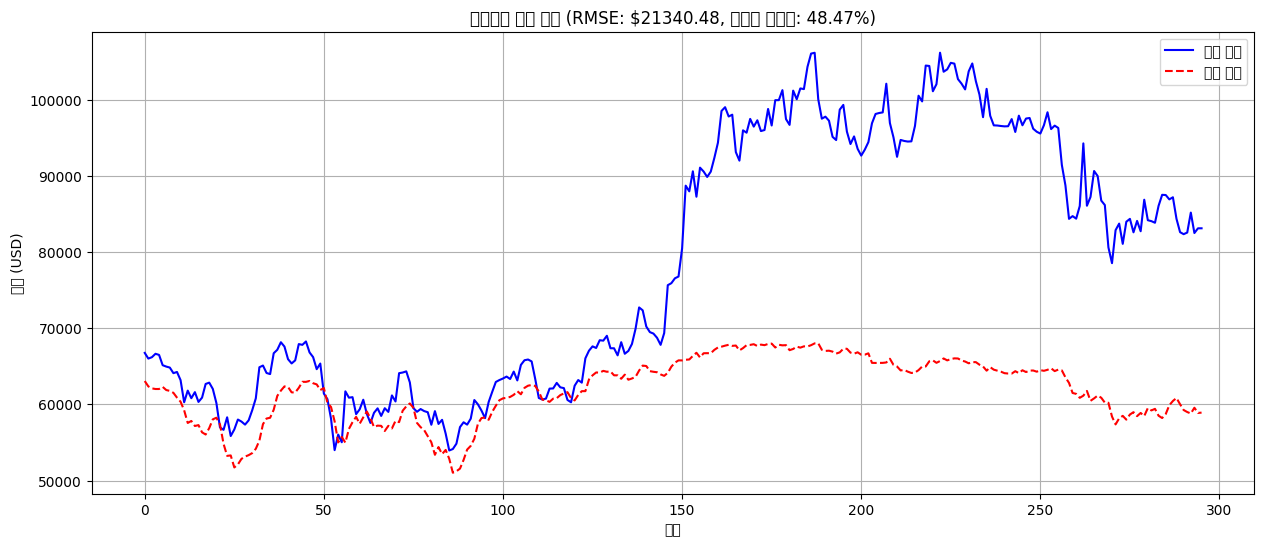

<ipython-input-5-b24ca6aaeb42>:658: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_direction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:658: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_direction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:658: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_direction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:658: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_direction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:658: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_direction_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:658: UserWarning: Glyph 54693 (\N{HANGUL SYLLABLE HYANG}) missing from font(s) D

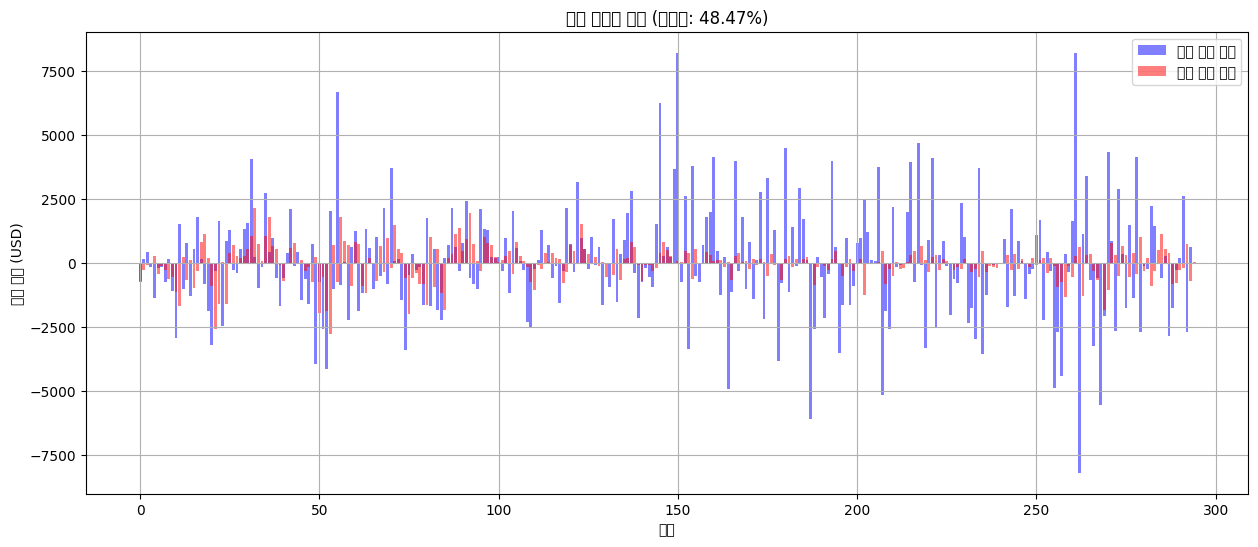

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-5-b24ca6aaeb42>:687: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_row[target_idx] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

<ipython-input-5-b24ca6aaeb42>:801: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_future_forecast_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:801: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_future_forecast_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:801: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_future_forecast_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:801: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_future_forecast_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:801: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  plt.savefig('bitcoin_future_forecast_optimal.png', dpi=300)
<ipython-input-5-b24ca6aaeb42>:801: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) 

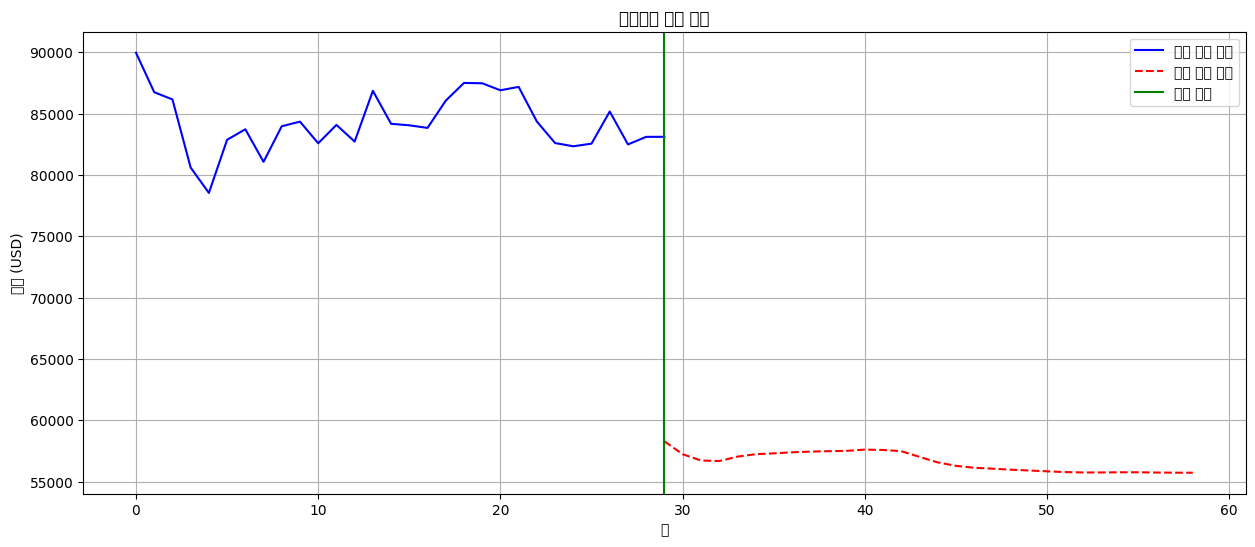


=============== 최종 결과 요약 ===============
최적 하이퍼파라미터:
  gru_units: 96
  lstm_units: 96
  dropout_rate: 0.3
  learning_rate: 0.002
  batch_size: 32
  optimizer: adam

테스트 성능:
RMSE: $21340.48
MAE: $16476.04
MAPE: 18.34%
방향성 정확도: 48.47%

향후 30일 예측 결과:
날짜 1: $58282.20
날짜 2: $57232.28
날짜 3: $56722.08
날짜 4: $56671.39
날짜 5: $57029.46
... (총 30일 예측)

모델 파일 저장 위치: optimal_bitcoin_model.h5


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import json
import os
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
import time

# ------------------ 데이터 로드 및 준비 함수 ------------------

def load_btc_data(file_path=None):
    """
    OHLCV 데이터를 파일에서 로드하거나 없으면 yfinance로 다운로드
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 OHLCV 데이터 로드: {file_path}")
        btc_data = pd.read_csv(file_path)
        btc_data['Date'] = pd.to_datetime(btc_data['Date'])
        btc_data.set_index('Date', inplace=True)
        return btc_data.reset_index()
    else:
        print("yfinance에서 OHLCV 데이터 다운로드 중...")
        btc_ohlcv = yf.download("BTC-USD", period="5y", interval="1d")

        # DataFrame 구조 표준화
        if btc_ohlcv.columns.nlevels > 1:
            btc_ohlcv.columns = [col[0] for col in btc_ohlcv.columns]

        # 날짜 열 추가
        btc_ohlcv = btc_ohlcv.reset_index()

        # 데이터 저장 (선택적)
        if file_path:
            btc_ohlcv.to_csv(file_path, index=False)
            print(f"OHLCV 데이터가 {file_path}에 저장되었습니다")

        return btc_ohlcv

def load_fear_greed_data(file_path=None):
    """
    공포/탐욕 지수 데이터를 파일에서 로드하거나 없으면 API에서 다운로드
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 공포/탐욕 지수 데이터 로드: {file_path}")
        fg_data = pd.read_csv(file_path)
        fg_data['Date'] = pd.to_datetime(fg_data['Date'])
        return fg_data
    else:
        try:
            print("API에서 공포/탐욕 지수 데이터 다운로드 중...")
            import requests
            url = "https://api.alternative.me/fng/?limit=2000&format=json"
            response = requests.get(url)

            if response.status_code == 200:
                data = response.json()
                fg_data = pd.DataFrame(data['data'])
                fg_data['timestamp'] = fg_data['timestamp'].astype(int)
                fg_data['Date'] = pd.to_datetime(fg_data['timestamp'], unit='s')
                fg_data['fear_greed_index'] = fg_data['value'].astype(float)
                fg_data = fg_data[['Date', 'fear_greed_index']]

                # 데이터 저장 (선택적)
                if file_path:
                    fg_data.to_csv(file_path, index=False)
                    print(f"공포/탐욕 지수 데이터가 {file_path}에 저장되었습니다")

                return fg_data
            else:
                print(f"API 요청 실패: 상태 코드 {response.status_code}")
                return pd.DataFrame(columns=['Date', 'fear_greed_index'])
        except Exception as e:
            print(f"공포/탐욕 지수 수집 오류: {e}")
            return pd.DataFrame(columns=['Date', 'fear_greed_index'])

def load_market_cap_data(file_path=None):
    """
    시가총액 데이터를 파일에서 로드하거나 없으면 가격 데이터로부터 추정
    """
    if file_path and os.path.exists(file_path):
        print(f"파일에서 시가총액 데이터 로드: {file_path}")
        market_cap_data = pd.read_csv(file_path)
        market_cap_data['Date'] = pd.to_datetime(market_cap_data['Date'])
        return market_cap_data
    else:
        # 시가총액 데이터가 없으면 빈 DataFrame 반환
        print("시가총액 데이터 파일이 없습니다. 가격 데이터로부터 추정할 예정입니다.")
        return pd.DataFrame(columns=['Date', 'market_cap'])

def estimate_market_cap(df):
    """
    가격 데이터로부터 시가총액 추정 (간단한 추정치)
    """
    if 'market_cap' not in df.columns or df['market_cap'].isna().all():
        print("시가총액 데이터 생성 중...")

        # 비트코인 유통량 추정 (각 날짜별로 다름)
        def estimate_btc_supply(date):
            """날짜에 따른 대략적인 비트코인 유통량 추정"""
            genesis_date = pd.to_datetime('2009-01-03')
            days_since_genesis = (date - genesis_date).days
            if days_since_genesis < 0:
                days_since_genesis = 0

            # 반감기 주기 기반 추정 (매우 대략적)
            blocks_per_day = 144  # 평균 10분당 1블록
            halvings = days_since_genesis // (210000 // blocks_per_day)
            reward = 50 / (2 ** halvings)

            # 최대 공급량 제한
            supply = min(21000000, days_since_genesis * blocks_per_day * reward / 2)
            return max(supply, 16000000)  # 2017년 이후로는 최소 1600만개 이상 유통

        # 각 날짜별 추정 공급량 계산
        df['estimated_supply'] = df['Date'].apply(estimate_btc_supply)

        # 시가총액 계산
        df['market_cap'] = df['Close'] * df['estimated_supply']

    return df

# ------------------ 데이터 전처리 함수 ------------------

def create_technical_indicators(df):
    """
    기술적 지표 계산
    """
    print("기술적 지표 계산 중...")

    # RSI
    df['rsi_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    # 이동평균선
    df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['sma_50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
    df['sma_200'] = ta.trend.SMAIndicator(df['Close'], window=200).sma_indicator()

    # MACD
    macd_indicator = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD_12_26_9'] = macd_indicator.macd()
    df['MACDs_12_26_9'] = macd_indicator.macd_signal()
    df['MACDh_12_26_9'] = macd_indicator.macd_diff()

    # 볼린저 밴드
    bollinger = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2)
    df['BBM_20_2.0'] = bollinger.bollinger_mavg()
    df['BBU_20_2.0'] = bollinger.bollinger_hband()
    df['BBL_20_2.0'] = bollinger.bollinger_lband()

    # 가격 모멘텀
    df['return_1d'] = df['Close'].pct_change(1)
    df['return_7d'] = df['Close'].pct_change(7)
    df['return_30d'] = df['Close'].pct_change(30)

    # 변동성 지표
    df['volatility_30d'] = df['return_1d'].rolling(window=30).std()

    # 추가 지표
    df['ema_9'] = ta.trend.EMAIndicator(df['Close'], window=9).ema_indicator()

    # 거래량 기반 지표
    df['volume_sma_20'] = ta.trend.SMAIndicator(df['Volume'], window=20).sma_indicator()
    df['volume_ratio'] = df['Volume'] / df['volume_sma_20']

    # 스토캐스틱 오실레이터
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # ATR (Average True Range)
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()

    print("기술적 지표 계산 완료")
    return df

def handle_missing_values(df):
    """
    누락값 처리
    """
    print("누락값 처리 중...")
    print("누락값 수:", df.isna().sum())

    # 기술적 지표로 인한 초기 누락값 제거
    df = df.dropna(subset=['sma_200', 'volatility_30d'])

    # 나머지 누락값은 전진 채우기
    df = df.ffill()

    # 여전히 남은 누락값이 있다면 후진 채우기
    df = df.bfill()

    return df

def handle_outliers(df):
    """
    이상치 처리
    """
    print("이상치 처리 중...")

    # 수치형 변수에 대해 IQR 방식으로 이상치 탐지 및 처리
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        if col in ['Open', 'High', 'Low', 'Close', 'Volume']:  # 가격/거래량은 이상치 처리하지 않음
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 경계값으로 대체
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

def feature_engineering(df):
    """
    특성 엔지니어링
    """
    print("특성 엔지니어링 중...")

    # 시간 기반 특성
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # 가격과 지표 사이의 비율
    df['price_to_sma20'] = df['Close'] / df['sma_20']
    df['price_to_sma50'] = df['Close'] / df['sma_50']
    df['price_to_sma200'] = df['Close'] / df['sma_200']

    # 지연 변수 생성 (1일, 7일, 14일, 30일 전 종가)
    for lag in [1, 7, 14, 30]:
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)

    # 거래량과 가격 상호작용
    df['volume_price_change'] = df['Volume'] * df['return_1d'].abs()

    return df

def scale_features(df, target_col='Close'):
    """
    특성 스케일링
    """
    print("데이터 스케일링 중...")

    # 타겟 변수 분리
    y = df[target_col].values

    # 예측에 사용할 특성 후보 목록
    potential_features = [
        'Open', 'High', 'Low', 'Volume',
        'rsi_14', 'sma_20', 'sma_50', 'sma_200',
        'MACDh_12_26_9', 'BBL_20_2.0', 'BBU_20_2.0',
        'return_1d', 'return_7d', 'volatility_30d',
        'fear_greed_index',
        'day_of_week', 'month', 'price_to_sma20', 'price_to_sma50',
        'close_lag_1', 'close_lag_7', 'volume_price_change',
        'stoch_k', 'stoch_d', 'atr'
    ]

    # 실제로 존재하는 컬럼만 선택
    available_features = [col for col in potential_features if col in df.columns]
    print(f"사용 가능한 특성: {len(available_features)}개")
    print("사용 특성 목록:", available_features)

    X = df[available_features].values

    # 스케일링 (MinMaxScaler 사용)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler_X.fit_transform(X)

    # 타겟 변수도 스케일링
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    return X_scaled, y_scaled, scaler_X, scaler_y, available_features

def split_time_series_data(X, y, test_size=0.2, val_size=0.2):
    """
    시계열 데이터 분할 (학습/검증/테스트)
    """
    print("데이터 분할 중...")
    n_samples = len(X)

    # 테스트셋 분리
    test_split_idx = int(n_samples * (1 - test_size))
    X_train_val, X_test = X[:test_split_idx], X[test_split_idx:]
    y_train_val, y_test = y[:test_split_idx], y[test_split_idx:]

    # 검증셋 분리
    val_split_idx = int(len(X_train_val) * (1 - val_size))
    X_train, X_val = X_train_val[:val_split_idx], X_train_val[val_split_idx:]
    y_train, y_val = y_train_val[:val_split_idx], y_train_val[val_split_idx:]

    print(f"훈련 데이터: {len(X_train)} 샘플")
    print(f"검증 데이터: {len(X_val)} 샘플")
    print(f"테스트 데이터: {len(X_test)} 샘플")

    return X_train, X_val, X_test, y_train, y_val, y_test

def create_sequences(X, y, seq_length=30):
    """
    시퀀스 기반 모델(LSTM 등)을 위한 데이터 준비
    """
    X_seq, y_seq = [], []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])

    return np.array(X_seq), np.array(y_seq)

def prepare_data(btc_file='btc_ohlcv.csv', fg_file='fear_greed_index.csv', market_cap_file='market_cap.csv'):
    """
    데이터 준비 파이프라인
    """
    # 1. 데이터 로드
    print("데이터 로드 중...")
    btc_data = load_btc_data(btc_file)
    fg_data = load_fear_greed_data(fg_file)
    market_cap_data = load_market_cap_data(market_cap_file)

    # 2. 데이터 병합
    print("데이터 병합 중...")
    data = btc_data.copy()

    # 공포/탐욕 지수 병합
    if not fg_data.empty:
        data['Date'] = pd.to_datetime(data['Date'])
        fg_data['Date'] = pd.to_datetime(fg_data['Date'])
        data = pd.merge(data, fg_data, on='Date', how='left')

    # 시가총액 데이터 병합
    if not market_cap_data.empty:
        data['Date'] = pd.to_datetime(data['Date'])
        market_cap_data['Date'] = pd.to_datetime(market_cap_data['Date'])
        data = pd.merge(data, market_cap_data, on='Date', how='left')

    # 시가총액 데이터가 없으면 추정
    data = estimate_market_cap(data)

    # 날짜를 인덱스로 설정
    data.set_index('Date', inplace=True)

    # 3. 기술적 지표 생성
    data = create_technical_indicators(data)

    # 4. 누락값 처리
    data = handle_missing_values(data)

    # 5. 이상치 처리
    data = handle_outliers(data)

    # 6. 특성 엔지니어링
    data = feature_engineering(data)

    # 7. 스케일링
    X_scaled, y_scaled, scaler_X, scaler_y, feature_cols = scale_features(data)

    # 8. 데이터 분할
    X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X_scaled, y_scaled)

    # 9. 시퀀스 생성
    seq_length = 30  # 30일간의 데이터로 다음 날 예측
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

    # NaN 값 처리
    X_train_seq = np.nan_to_num(X_train_seq, nan=0.0)
    X_val_seq = np.nan_to_num(X_val_seq, nan=0.0)
    X_test_seq = np.nan_to_num(X_test_seq, nan=0.0)
    y_train_seq = np.nan_to_num(y_train_seq, nan=0.0)
    y_val_seq = np.nan_to_num(y_val_seq, nan=0.0)
    y_test_seq = np.nan_to_num(y_test_seq, nan=0.0)

    print("데이터 준비 완료!")
    print(f"시퀀스 훈련 데이터 형태: {X_train_seq.shape}")
    print(f"시퀀스 검증 데이터 형태: {X_val_seq.shape}")
    print(f"시퀀스 테스트 데이터 형태: {X_test_seq.shape}")

    return {
        'df': data,
        'X_scaled': X_scaled,
        'y_scaled': y_scaled,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'feature_cols': feature_cols,
        'X_train_seq': X_train_seq,
        'y_train_seq': y_train_seq,
        'X_val_seq': X_val_seq,
        'y_val_seq': y_val_seq,
        'X_test_seq': X_test_seq,
        'y_test_seq': y_test_seq,
        'seq_length': seq_length
    }

# ------------------ 하이퍼파라미터 튜닝 함수 ------------------

def create_tunable_hybrid_model(input_shape, gru_units, lstm_units, dropout_rate, learning_rate, optimizer_name):
    """
    튜닝 가능한 하이퍼파라미터를 받는 LSTM + GRU 하이브리드 모델 생성 함수
    """
    model = Sequential()

    # GRU 레이어
    model.add(GRU(gru_units,
                return_sequences=True,
                input_shape=input_shape,
                recurrent_dropout=0.0))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # LSTM 레이어
    model.add(LSTM(lstm_units,
                return_sequences=False,
                recurrent_dropout=0.0))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # 완전 연결 레이어
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate/2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    else:
        raise ValueError(f"지원되지 않는 옵티마이저: {optimizer_name}")

    # 모델 컴파일
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

def hyperparameter_tuning(X_train_seq, y_train_seq, X_val_seq, y_val_seq, param_grid,
                         max_epochs=100, patience=10, results_file='tuning_results.csv'):
    """
    하이퍼파라미터 튜닝 함수
    """
    # 결과 저장용 리스트
    results = []

    # 모델 입력 형태
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

    # 파라미터 그리드 생성
    grid = list(ParameterGrid(param_grid))

    print(f"총 {len(grid)}개의 하이퍼파라미터 조합 테스트 예정")

    # 그리드 서치 시작
    for i, params in enumerate(grid):
        start_time = time.time()

        print(f"\n조합 {i+1}/{len(grid)}: {params}")

        # 모델 생성
        model = create_tunable_hybrid_model(
            input_shape=input_shape,
            gru_units=params['gru_units'],
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            optimizer_name=params['optimizer']
        )

        # 콜백 정의
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]

        # 모델 훈련
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=max_epochs,
            batch_size=params['batch_size'],
            callbacks=callbacks,
            verbose=1
        )

        # 훈련 시간 계산
        train_time = time.time() - start_time

        # 최적 검증 손실 및 에포크
        best_epoch = np.argmin(history.history['val_loss']) + 1
        best_val_loss = min(history.history['val_loss'])

        # 결과 저장
        result = {
            'gru_units': params['gru_units'],
            'lstm_units': params['lstm_units'],
            'dropout_rate': params['dropout_rate'],
            'learning_rate': params['learning_rate'],
            'batch_size': params['batch_size'],
            'optimizer': params['optimizer'],
            'val_loss': best_val_loss,
            'best_epoch': best_epoch,
            'train_time_seconds': train_time
        }

        results.append(result)

        # 중간 결과 저장
        pd.DataFrame(results).to_csv(results_file, index=False)

        print(f"검증 손실: {best_val_loss:.6f}, 최적 에포크: {best_epoch}, 훈련 시간: {train_time:.2f}초")

    # 결과를 데이터프레임으로 변환
    results_df = pd.DataFrame(results)

    # 검증 손실 기준으로 정렬
    results_df = results_df.sort_values('val_loss')

    print("\n===== 하이퍼파라미터 튜닝 결과 =====")
    print(results_df.head().to_string())

    # 최적 하이퍼파라미터 반환
    best_params = results_df.iloc[0].to_dict()

    print(f"\n최적 하이퍼파라미터:")
    for key, value in best_params.items():
        if key not in ['val_loss', 'best_epoch', 'train_time_seconds']:
            print(f"  {key}: {value}")

    return best_params, results_df

def train_optimal_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq, best_params,
                       save_path='best_bitcoin_model.h5'):
    """
    최적의 하이퍼파라미터로 최종 모델 학습
    """
    # 최적 하이퍼파라미터 추출
    gru_units = best_params['gru_units']
    lstm_units = best_params['lstm_units']
    dropout_rate = best_params['dropout_rate']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    optimizer_name = best_params['optimizer']

    # 입력 형태
    input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

    # 최적 모델 생성
    optimal_model = create_tunable_hybrid_model(
        input_shape=input_shape,
        gru_units=gru_units,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        optimizer_name=optimizer_name
    )

    # 콜백 정의
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint(save_path, save_best_only=True, monitor='val_loss')
    ]

    # 최적 에포크 수는 최적 하이퍼파라미터 조합의 best_epoch에 여유를 더한 값
    max_epochs = min(int(best_params['best_epoch'] * 1.5), 150)

    print(f"\n{'='*50}")
    print(f"최적 하이퍼파라미터를 사용하여 최종 모델 학습")
    print(f"최대 에포크 수: {max_epochs}")
    print(f"{'='*50}")

# 모델 학습
    history = optimal_model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # 최상의 모델 로드
    optimal_model = tf.keras.models.load_model(save_path)

    return optimal_model, history

def predict_with_optimal_model(model, X_test_seq, y_test_seq, scaler_y):
    """
    최적 모델로 비트코인 가격 예측 및 평가
    """
    # 예측
    y_pred = model.predict(X_test_seq)

    # 스케일링 역변환
    y_test_orig = scaler_y.inverse_transform(y_test_seq)
    y_pred_orig = scaler_y.inverse_transform(y_pred)

    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100

    # 방향성 정확도 계산
    y_test_diff = np.diff(y_test_orig.reshape(-1))
    y_pred_diff = np.diff(y_pred_orig.reshape(-1))
    direction_accuracy = np.mean((y_test_diff > 0) == (y_pred_diff > 0)) * 100

    # 결과 출력
    print(f"\n{'='*50}")
    print("테스트 성능 평가")
    print(f"{'='*50}")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"방향성 정확도: {direction_accuracy:.2f}%")

    # 예측 vs 실제 가격 시각화
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_orig, label='실제 가격', color='blue')
    plt.plot(y_pred_orig, label='예측 가격', color='red', linestyle='--')
    plt.title(f'비트코인 가격 예측 (RMSE: ${rmse:.2f}, 방향성 정확도: {direction_accuracy:.2f}%)')
    plt.xlabel('시간')
    plt.ylabel('가격 (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig('bitcoin_prediction_optimal.png', dpi=300)
    plt.show()

    # 방향성 예측 시각화
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(y_test_diff)), y_test_diff, alpha=0.5, color='blue', label='실제 가격 변화')
    plt.bar(range(len(y_pred_diff)), y_pred_diff, alpha=0.5, color='red', label='예측 가격 변화')
    plt.title(f'가격 방향성 예측 (정확도: {direction_accuracy:.2f}%)')
    plt.xlabel('시간')
    plt.ylabel('가격 변화 (USD)')
    plt.legend()
    plt.grid(True)
    plt.savefig('bitcoin_direction_optimal.png', dpi=300)
    plt.show()

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'direction_accuracy': direction_accuracy,
        'y_test_orig': y_test_orig,
        'y_pred_orig': y_pred_orig
    }

def predict_future_prices(model, last_sequence, n_days=30, X_scaler=None, y_scaler=None):
    """
    최적 모델로 미래 비트코인 가격 예측
    """
    # 마지막 시퀀스 복사
    curr_sequence = last_sequence.copy()
    future_pred = []

    # n일 동안 순차적으로 예측
    for i in range(n_days):
        # 현재 시퀀스로 다음 날 가격 예측
        pred = model.predict(curr_sequence.reshape(1, curr_sequence.shape[0], curr_sequence.shape[1]))[0]
        future_pred.append(pred)

        # 시퀀스 업데이트
        new_row = curr_sequence[-1].copy()
        target_idx = 0  # Close 값 인덱스 (필요에 따라 조정)
        new_row[target_idx] = pred

        # 새 시퀀스 생성 (마지막 값 제거 후 새 예측값 추가)
        curr_sequence = np.vstack([curr_sequence[1:], new_row])

    # 예측 스케일 역변환
    if y_scaler is not None:
        future_pred_orig = y_scaler.inverse_transform(np.array(future_pred))
    else:
        future_pred_orig = np.array(future_pred)

    # 결과 출력
    print(f"\n{'='*50}")
    print(f"향후 {n_days}일 비트코인 가격 예측")
    print(f"{'='*50}")

    for i, price in enumerate(future_pred_orig):
        print(f"날짜 {i+1}: ${price[0]:.2f}")

    return future_pred_orig

# ------------------ 하이퍼파라미터 그리드 정의 ------------------

# 하이퍼파라미터 탐색 공간 (전체)
param_grid = {
    'gru_units': [32, 64, 128],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop']
}

# 효율적인 그리드 서치를 위한 축소된 파라미터 그리드
reduced_param_grid = {
    'gru_units': [64, 128],
    'lstm_units': [64, 128],
    'dropout_rate': [0.3],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['adam']
}

# ------------------ 전체 하이퍼파라미터 튜닝 및 예측 프로세스 ------------------

def run_hyperparameter_tuning_process(data_dict, tuning_params=None):
    """
    전체 하이퍼파라미터 튜닝 및 예측 프로세스 실행
    """
    # 데이터 추출
    X_train_seq = data_dict['X_train_seq']
    y_train_seq = data_dict['y_train_seq']
    X_val_seq = data_dict['X_val_seq']
    y_val_seq = data_dict['y_val_seq']
    X_test_seq = data_dict['X_test_seq']
    y_test_seq = data_dict['y_test_seq']
    scaler_y = data_dict['scaler_y']
    X_scaled = data_dict['X_scaled']
    seq_length = data_dict['seq_length']

    # 하이퍼파라미터 튜닝 수행 또는 사전 정의된 파라미터 사용
    if tuning_params is None:
        print("하이퍼파라미터 튜닝 시작...")
        # 축소된 그리드로 시작 (시간 효율성)
        best_params, results_df = hyperparameter_tuning(
            X_train_seq, y_train_seq, X_val_seq, y_val_seq,
            reduced_param_grid,  # 축소된 그리드 사용
            max_epochs=50,  # 초기 에포크 제한
            patience=10,
            results_file='tuning_results_initial.csv'
        )
    else:
        print("사전 정의된 하이퍼파라미터 사용...")
        best_params = tuning_params

    # 최적 모델 학습
    optimal_model, history = train_optimal_model(
        X_train_seq, y_train_seq, X_val_seq, y_val_seq,
        best_params,
        save_path='optimal_bitcoin_model.h5'
    )

    # 테스트 데이터로 평가
    test_results = predict_with_optimal_model(
        optimal_model, X_test_seq, y_test_seq, scaler_y
    )

    # 미래 가격 예측
    last_sequence = X_scaled[-seq_length:]
    future_predictions = predict_future_prices(
        optimal_model, last_sequence, n_days=30, y_scaler=scaler_y
    )

    # 미래 예측 시각화
    plt.figure(figsize=(15, 6))

    # 과거 실제 가격 (마지막 30일)
    past_prices = scaler_y.inverse_transform(data_dict['y_scaled'][-30:])

    # 날짜 인덱스 생성
    x_past = range(len(past_prices))
    x_future = range(len(past_prices) - 1, len(past_prices) + len(future_predictions) - 1)

    # 그래프 그리기
    plt.plot(x_past, past_prices, label='과거 실제 가격', color='blue')
    plt.plot(x_future, future_predictions, label='미래 예측 가격', color='red', linestyle='--')

    plt.axvline(x=len(past_prices)-1, color='green', linestyle='-', label='예측 시작')
    plt.title('비트코인 가격 전망')
    plt.xlabel('일')
    plt.ylabel('가격 (USD)')
    plt.legend()
    plt.grid(True)

    plt.savefig('bitcoin_future_forecast_optimal.png', dpi=300)
    plt.show()

    # 결과 반환
    return {
        'model': optimal_model,
        'best_params': best_params,
        'test_results': test_results,
        'future_predictions': future_predictions,
        'history': history
    }

# ------------------ 단계별 튜닝 전략 함수 ------------------

def run_staged_hyperparameter_tuning(data_dict):
    """
    단계별 하이퍼파라미터 튜닝 전략
    """
    # 데이터 추출
    X_train_seq = data_dict['X_train_seq']
    y_train_seq = data_dict['y_train_seq']
    X_val_seq = data_dict['X_val_seq']
    y_val_seq = data_dict['y_val_seq']

    # 1단계: 초기 탐색 (빠른 비교)
    print("\n1단계: 초기 하이퍼파라미터 탐색")
    initial_param_grid = {
        'gru_units': [64, 128],
        'lstm_units': [64, 128],
        'dropout_rate': [0.3],
        'learning_rate': [0.001, 0.0001],
        'batch_size': [32, 64],
        'optimizer': ['adam']
    }

    best_params_initial, results_df_initial = hyperparameter_tuning(
        X_train_seq, y_train_seq, X_val_seq, y_val_seq,
        initial_param_grid,
        max_epochs=30,  # 빠른 탐색을 위해 적은 에포크
        patience=7,
        results_file='tuning_results_stage1.csv'
    )

    # 최고 성능 파라미터 기준으로 2단계 탐색 범위 설정
    best_gru = best_params_initial['gru_units']
    best_lstm = best_params_initial['lstm_units']
    best_lr = best_params_initial['learning_rate']
    best_batch = best_params_initial['batch_size']

    # 2단계: 세부 탐색 (좁은 범위로 세밀하게)
    print("\n2단계: 세부 하이퍼파라미터 탐색")

    # 초기 최적값 주변을 더 세밀하게 탐색
    fine_tune_param_grid = {
        'gru_units': [max(32, best_gru - 32), best_gru, min(256, best_gru + 32)],
        'lstm_units': [max(32, best_lstm - 32), best_lstm, min(256, best_lstm + 32)],
        'dropout_rate': [0.25, 0.3, 0.35],
        'learning_rate': [best_lr / 2, best_lr, best_lr * 2],
        'batch_size': [best_batch],
        'optimizer': ['adam']
    }

    best_params_fine, results_df_fine = hyperparameter_tuning(
        X_train_seq, y_train_seq, X_val_seq, y_val_seq,
        fine_tune_param_grid,
        max_epochs=50,
        patience=10,
        results_file='tuning_results_stage2.csv'
    )

    # 최종 최적 파라미터 결정
    return best_params_fine, results_df_fine

# ------------------ 메인 실행 코드 ------------------

if __name__ == "__main__":
    # 디렉토리 생성
    os.makedirs('data', exist_ok=True)
    os.makedirs('saved_models', exist_ok=True)
    os.makedirs('tuning_results', exist_ok=True)

    # 파일 경로 설정
    btc_file = 'data/btc_ohlcv.csv'
    fg_file = 'data/fear_greed_index.csv'
    market_cap_file = 'data/market_cap.csv'

    # 1. 데이터 준비
    data_dict = prepare_data(btc_file, fg_file, market_cap_file)

    # 2. 하이퍼파라미터 튜닝 (선택사항)
    # 옵션 1: 빠른 튜닝 (사전 정의된 파라미터로 바로 진행)
    predefined_best_params = {
        'gru_units': 128,
        'lstm_units': 128,
        'dropout_rate': 0.3,
        'learning_rate': 0.0001,
        'batch_size': 32,
        'optimizer': 'adam',
        'best_epoch': 50  # 예상 최적 에포크 수
    }

    use_predefined_params = False  # True로 설정하면 사전 정의된 파라미터 사용

    if use_predefined_params:
        # 사전 정의된 파라미터로 진행
        tuning_results = run_hyperparameter_tuning_process(data_dict, tuning_params=predefined_best_params)
    else:
        # 옵션 2: 자동 튜닝 - 단계별 전략 사용
        use_staged_tuning = True  # True로 설정하면 단계별 튜닝 전략 사용

        if use_staged_tuning:
            best_params, _ = run_staged_hyperparameter_tuning(data_dict)
            tuning_results = run_hyperparameter_tuning_process(data_dict, tuning_params=best_params)
        else:
            # 옵션 3: 자동 튜닝 - 기본 전략 사용
            tuning_results = run_hyperparameter_tuning_process(data_dict)

    # 3. 최종 결과 요약
    print("\n=============== 최종 결과 요약 ===============")
    print(f"최적 하이퍼파라미터:")
    for key, value in tuning_results['best_params'].items():
        if key not in ['val_loss', 'best_epoch', 'train_time_seconds']:
            print(f"  {key}: {value}")

    print("\n테스트 성능:")
    print(f"RMSE: ${tuning_results['test_results']['rmse']:.2f}")
    print(f"MAE: ${tuning_results['test_results']['mae']:.2f}")
    print(f"MAPE: {tuning_results['test_results']['mape']:.2f}%")
    print(f"방향성 정확도: {tuning_results['test_results']['direction_accuracy']:.2f}%")

    print("\n향후 30일 예측 결과:")
    for i, price in enumerate(tuning_results['future_predictions'][:5]):
        print(f"날짜 {i+1}: ${price[0]:.2f}")
    print("... (총 30일 예측)")

    print("\n모델 파일 저장 위치: optimal_bitcoin_model.h5")
    print("==============================================")

# 예측결과 시각화

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats

def visualize_prediction_results(y_test_orig, y_pred_orig, date_index=None):
    """
    예측 결과를 다양한 방식으로 시각화하는 함수

    Parameters:
    -----------
    y_test_orig : numpy.ndarray
        실제 비트코인 가격 데이터
    y_pred_orig : numpy.ndarray
        예측 비트코인 가격 데이터
    date_index : pandas.DatetimeIndex, optional
        날짜 인덱스 (있으면 x축에 날짜 표시)
    """
    # 데이터 준비
    y_test_flat = y_test_orig.flatten()
    y_pred_flat = y_pred_orig.flatten()

    # 잔차 계산
    residuals = y_test_flat - y_pred_flat

    # 날짜 인덱스가 없으면 데이터 포인트 인덱스 사용
    if date_index is None:
        date_index = pd.RangeIndex(start=0, stop=len(y_test_flat), step=1)

    # 결과 데이터프레임 생성
    results_df = pd.DataFrame({
        'Date': date_index,
        'Actual': y_test_flat,
        'Predicted': y_pred_flat,
        'Residual': residuals,
        'Abs_Residual': np.abs(residuals),
        'Squared_Residual': residuals**2,
        'Percent_Error': np.abs(residuals / y_test_flat) * 100
    })

    # 1. 시계열 그래프: 실제 가격 vs 예측 가격
    plt.figure(figsize=(15, 8))
    plt.plot(results_df['Date'], results_df['Actual'], label='실제 가격', color='blue')
    plt.plot(results_df['Date'], results_df['Predicted'], label='예측 가격', color='red', linestyle='--')
    plt.title('비트코인 가격: 실제 vs 예측', fontsize=16)
    plt.xlabel('날짜', fontsize=12)
    plt.ylabel('가격 (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('time_series_plot.png', dpi=300)
    plt.show()

    # 2. Scatter Plot: 실제 가격 vs 예측 가격
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)

    # 회귀선 추가
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='이상적인 예측')

    # R² 값 계산 및 표시
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        results_df['Actual'], results_df['Predicted']
    )
    plt.annotate(f"R² = {r2:.4f}\ny = {slope:.4f}x + {intercept:.2f}",
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('실제 가격 vs 예측 가격 산점도', fontsize=16)
    plt.xlabel('실제 가격 (USD)', fontsize=12)
    plt.ylabel('예측 가격 (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()

    # 3. 잔차 플롯
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Date'], results_df['Residual'], color='green')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('시간에 따른 잔차 (예측 오차)', fontsize=16)
    plt.ylabel('잔차 (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 4. 잔차 히스토그램
    plt.subplot(2, 1, 2)
    sns.histplot(results_df['Residual'], kde=True, bins=30)
    plt.title('잔차 분포', fontsize=16)
    plt.xlabel('잔차 (USD)', fontsize=12)
    plt.ylabel('빈도', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('residual_analysis.png', dpi=300)
    plt.show()

    # 5. 잔차의 자기상관 함수(ACF) 플롯
    plt.figure(figsize=(12, 6))
    plot_acf(results_df['Residual'], lags=40, alpha=0.05)
    plt.title('잔차의 자기상관함수(ACF)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('residual_acf.png', dpi=300)
    plt.show()

    # 6. 백분율 오차 시각화
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Date'], results_df['Percent_Error'], color='purple')
    plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='5% 오차')
    plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% 오차')
    plt.title('시간에 따른 백분율 오차', fontsize=16)
    plt.ylabel('백분율 오차 (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    sns.histplot(results_df['Percent_Error'], kde=True, bins=30)
    plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='5% 오차')
    plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='10% 오차')
    plt.title('백분율 오차 분포', fontsize=16)
    plt.xlabel('백분율 오차 (%)', fontsize=12)
    plt.ylabel('빈도', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('percent_error.png', dpi=300)
    plt.show()

    # 7. 실제 vs 예측 방향성 비교
    actual_diff = np.diff(y_test_flat)
    pred_diff = np.diff(y_pred_flat)
    direction_match = (actual_diff > 0) == (pred_diff > 0)

    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.bar(range(len(actual_diff)), actual_diff, alpha=0.5, color='blue', label='실제 변화')
    plt.bar(range(len(pred_diff)), pred_diff, alpha=0.5, color='red', label='예측 변화')
    plt.title('가격 변화 방향 비교', fontsize=16)
    plt.ylabel('가격 변화 (USD)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(range(len(direction_match)), direction_match.astype(int), 'g-')
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    plt.title('방향성 예측 정확도 (1=정확, 0=틀림)', fontsize=16)
    plt.xlabel('시간', fontsize=12)
    plt.ylabel('정확도', fontsize=12)
    plt.yticks([0, 1], ['틀림', '정확'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('direction_accuracy.png', dpi=300)
    plt.show()

    # 8. 오차가 가장 큰 기간 식별 및 분석
    n_largest = min(10, len(results_df))
    largest_errors = results_df.nlargest(n_largest, 'Abs_Residual')

    print(f"\n===== 오차가 가장 큰 {n_largest}개 시점 =====")
    for i, row in largest_errors.iterrows():
        print(f"날짜: {row['Date']}, 실제: ${row['Actual']:.2f}, 예측: ${row['Predicted']:.2f}, 오차: ${row['Residual']:.2f}, 백분율 오차: {row['Percent_Error']:.2f}%")

    # 오차가 큰 시점 시각화
    plt.figure(figsize=(15, 8))
    plt.plot(results_df['Date'], results_df['Actual'], label='실제 가격', color='blue')
    plt.plot(results_df['Date'], results_df['Predicted'], label='예측 가격', color='red', linestyle='--')

    # 오차가 큰 포인트 강조
    plt.scatter(largest_errors['Date'], largest_errors['Actual'], color='green', s=100, alpha=0.7, label='오차가 큰 시점')

    plt.title('오차가 큰 시점 분석', fontsize=16)
    plt.xlabel('날짜', fontsize=12)
    plt.ylabel('가격 (USD)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('largest_errors.png', dpi=300)
    plt.show()

    # 9. 모델 평가 지표 출력
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mape = np.mean(np.abs((y_test_flat - y_pred_flat) / y_test_flat)) * 100

    # 방향성 정확도
    direction_accuracy = np.mean(direction_match) * 100

    print("\n===== 모델 성능 지표 =====")
    print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
    print(f"MAE (Mean Absolute Error): ${mae:.2f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"R² (결정계수): {r2:.4f}")
    print(f"방향성 정확도: {direction_accuracy:.2f}%")

    # 오차 통계 출력
    print("\n===== 오차 통계 =====")
    print(f"평균 오차: ${np.mean(residuals):.2f}")
    print(f"오차 표준편차: ${np.std(residuals):.2f}")
    print(f"최대 오차: ${np.max(np.abs(residuals)):.2f}")
    print(f"중앙값 오차: ${np.median(np.abs(residuals)):.2f}")
    print(f"5% 이하 오차 비율: {np.mean(results_df['Percent_Error'] <= 5) * 100:.2f}%")
    print(f"10% 이하 오차 비율: {np.mean(results_df['Percent_Error'] <= 10) * 100:.2f}%")

    return results_df

In [8]:
def analyze_prediction_errors(results_df, window_size=7):
    """
    예측 오차를 분석하고 패턴을 찾는 함수

    Parameters:
    -----------
    results_df : pandas.DataFrame
        visualize_prediction_results 함수에서 반환된 결과 데이터프레임
    window_size : int, default=7
        롤링 평균 계산을 위한 윈도우 크기
    """
    # 결과 복사
    df = results_df.copy()

    # 롤링 변동성 계산
    df['rolling_volatility'] = df['Actual'].pct_change().rolling(window=window_size).std() * 100

    # 예측 오차와 변동성 간의 관계 분석
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['rolling_volatility'], color='purple', label='변동성 (7일)')
    plt.plot(df['Date'], df['Abs_Residual'] / df['Actual'] * 100, color='orange', label='백분율 오차', alpha=0.6)
    plt.title('변동성과 예측 오차 간의 관계', fontsize=16)
    plt.ylabel('백분율 (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # 산점도로 변동성 vs 오차 관계 확인
    plt.subplot(2, 1, 2)
    sns.scatterplot(x='rolling_volatility', y='Percent_Error', data=df, alpha=0.6)

    # 회귀선 추가
    sns.regplot(x='rolling_volatility', y='Percent_Error', data=df, scatter=False, color='red')

    # 상관계수 계산 및 표시
    corr = df['rolling_volatility'].corr(df['Percent_Error'])
    plt.annotate(f"상관계수: {corr:.4f}",
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('변동성 vs 백분율 오차 산점도', fontsize=16)
    plt.xlabel('7일 롤링 변동성 (%)', fontsize=12)
    plt.ylabel('백분율 오차 (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('volatility_vs_error.png', dpi=300)
    plt.show()

    # 특정 임계값 이상의 오차를 보이는 구간 식별
    error_threshold = np.percentile(df['Percent_Error'], 90)  # 상위 10% 오차
    high_error_periods = df[df['Percent_Error'] > error_threshold]

    print(f"\n===== 오차가 큰 구간 분석 (상위 10%, 임계값: {error_threshold:.2f}%) =====")

    # 연속된 고오차 구간 식별
    if len(high_error_periods) > 0:
        high_error_periods['group'] = (high_error_periods.index.to_series().diff() > 1).cumsum()
        error_clusters = high_error_periods.groupby('group')

        for group_id, group in error_clusters:
            if len(group) >= 3:  # 3일 이상 연속된 구간만 고려
                start_date = group['Date'].iloc[0]
                end_date = group['Date'].iloc[-1]
                avg_error = group['Percent_Error'].mean()
                avg_volatility = group['rolling_volatility'].mean()
                print(f"구간: {start_date} ~ {end_date} ({len(group)}일)")
                print(f"평균 오차: {avg_error:.2f}%, 평균 변동성: {avg_volatility:.2f}%")
                print(f"실제 가격 변화: ${group['Actual'].iloc[-1] - group['Actual'].iloc[0]:.2f}")
                print("---")

    # 특정 이벤트나 뉴스와 연관성 분석을 위한 팁
    print("\n예측 오차가 큰 구간에 대한 추가 분석 방법:")
    print("1. 해당 기간의 주요 암호화폐 뉴스 및 이벤트 확인")
    print("2. 해당 기간의 거래량 패턴 확인")
    print("3. 비트코인 네트워크 지표(해시레이트, 활성 주소 수 등) 변화 확인")
    print("4. 거시경제적 요인(금리, 인플레이션 데이터 발표 등) 점검")

    return high_error_periods

In [9]:
def analyze_residuals(results_df):
    """
    잔차(residual)의 특성을 자세히 분석하는 함수

    Parameters:
    -----------
    results_df : pandas.DataFrame
        visualize_prediction_results 함수에서 반환된 결과 데이터프레임
    """
    # 잔차 추출
    residuals = results_df['Residual'].values

    # 1. QQ 플롯 (정규성 확인)
    plt.figure(figsize=(12, 6))
    stats.probplot(residuals, plot=plt)
    plt.title('잔차의 QQ 플롯 (정규성 검정)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('residual_qq_plot.png', dpi=300)
    plt.show()

    # 2. 잔차의 시간적 패턴 분석 (런 테스트)
    runs, n1, n2 = stats.runstest_1samp(residuals, correction=False)
    p_value = stats.runstest_1samp(residuals, correction=False)[2]

    print("\n===== 잔차의 무작위성 검정 (런 테스트) =====")
    print(f"런 통계량: {runs:.4f}")
    print(f"p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("결과: 잔차에 유의미한 패턴이 있습니다 (귀무가설 기각)")
    else:
        print("결과: 잔차가 무작위적으로 분포합니다 (귀무가설 유지)")

    # 3. 잔차와 예측값 간의 관계 분석
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Predicted', y='Residual', data=results_df, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

    # 추세선 추가
    sns.regplot(x='Predicted', y='Residual', data=results_df, scatter=False, color='red')

    plt.title('예측값 vs 잔차 (이분산성 확인)', fontsize=16)
    plt.xlabel('예측 가격 (USD)', fontsize=12)
    plt.ylabel('잔차 (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('predicted_vs_residual.png', dpi=300)
    plt.show()

    # 4. 잔차 자기상관 테스트 (Ljung-Box 검정)
    from statsmodels.stats.diagnostic import acorr_ljungbox

    lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30])

    print("\n===== 잔차의 자기상관 검정 (Ljung-Box 검정) =====")
    for i, lag in enumerate([10, 20, 30]):
        lb_stat = lb_test.iloc[i, 0]
        lb_pvalue = lb_test.iloc[i, 1]
        print(f"시차 {lag}에서의 Ljung-Box 통계량: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
        if lb_pvalue < 0.05:
            print(f"결과: 시차 {lag}에서 자기상관이 존재합니다")
        else:
            print(f"결과: 시차 {lag}에서 자기상관이 없습니다")

    # 5. 잔차의 ARCH 효과 검정 (변동성 클러스터링)
    from statsmodels.stats.diagnostic import het_arch

    arch_test = het_arch(residuals, nlags=5)

    print("\n===== 잔차의 ARCH 효과 검정 =====")
    print(f"LM 통계량: {arch_test[0]:.4f}")
    print(f"p-value: {arch_test[1]:.4f}")
    if arch_test[1] < 0.05:
        print("결과: 잔차에 ARCH 효과(변동성 클러스터링)가 있습니다")
    else:
        print("결과: 잔차에 ARCH 효과가 없습니다")

    # 6. 추가 분석 및 제안 출력
    print("\n===== 잔차 분석 결과에 따른 개선 방안 =====")

    # 비정규성 확인
    if stats.shapiro(residuals)[1] < 0.05:
        print("- 잔차가 정규분포를 따르지 않습니다:")
        print("  → 로그 변환 또는 다른 변환을 적용하여 타겟 변수의 분포를 정규화해 보세요")
        print("  → 로버스트한 손실 함수(예: Huber 손실)를 사용해 보세요")

    # 자기상관 확인
    if lb_test.iloc[0, 1] < 0.05:
        print("- 잔차에 자기상관이 있습니다:")
        print("  → 시퀀스 길이(context window)를 늘려 보세요")
        print("  → 더 복잡한 모델 아키텍처를 시도해 보세요")
        print("  → 어텐션 메커니즘을 추가해 보세요")

    # 이분산성 확인
    if np.abs(np.corrcoef(results_df['Predicted'], results_df['Residual'])[0, 1]) > 0.1:
        print("- 예측값과 잔차 간에 상관관계가 있습니다(이분산성):")
        print("  → 특성 스케일링 방법을 개선해 보세요")
        print("  → 가격 수준에 따른 별도의 모델을 고려해 보세요")

    # ARCH 효과 확인
    if arch_test[1] < 0.05:
        print("- 잔차에 변동성 클러스터링(ARCH 효과)이 있습니다:")
        print("  → 변동성 예측 모델(GARCH 등)을 별도로 구축하여 결합해 보세요")
        print("  → 변동성이 높은 기간과 낮은 기간에 대해 별도의 모델을 학습해 보세요")

    return {
        'shapiro_test': stats.shapiro(residuals),
        'runs_test': (runs, p_value),
        'ljung_box_test': lb_test,
        'arch_test': arch_test
    }

In [11]:
def interpret_model_performance(y_test_orig, y_pred_orig, results_df=None):
   """
   모델 성능 지표를 종합적으로 해석하는 함수

   Parameters:
   -----------
   y_test_orig : numpy.ndarray
       실제 비트코인 가격 데이터
   y_pred_orig : numpy.ndarray
       예측 비트코인 가격 데이터
   results_df : pandas.DataFrame, optional
       시각화 함수에서 생성된 결과 데이터프레임
   """
   # 데이터 평탄화
   y_test_flat = y_test_orig.flatten()
   y_pred_flat = y_pred_orig.flatten()

   # 기본 평가 지표 계산
   mse = mean_squared_error(y_test_flat, y_pred_flat)
   rmse = np.sqrt(mse)
   mae = mean_absolute_error(y_test_flat, y_pred_flat)
   mape = np.mean(np.abs((y_test_flat - y_pred_flat) / y_test_flat)) * 100
   r2 = r2_score(y_test_flat, y_pred_flat)

   # 방향성 정확도
   actual_diff = np.diff(y_test_flat)
   pred_diff = np.diff(y_pred_flat)
   direction_match = (actual_diff > 0) == (pred_diff > 0)
   direction_accuracy = np.mean(direction_match) * 100

   # 추가 평가 지표
   # 1. 틸트(Theil) U 통계량
   from sklearn.metrics import mean_squared_error

   # 단순 예측 모델(이전 값 그대로 예측) 생성
   naive_pred = np.roll(y_test_flat, 1)
   naive_pred[0] = naive_pred[1]  # 첫 값 처리

   # 제안 모델과 단순 모델의 MSE 비교
   model_mse = mean_squared_error(y_test_flat, y_pred_flat)
   naive_mse = mean_squared_error(y_test_flat, naive_pred)
   theil_u = np.sqrt(model_mse) / np.sqrt(naive_mse)

   # 2. 양수/음수 방향 별 정확도
   up_accuracy = np.mean(direction_match[actual_diff > 0]) * 100 if np.any(actual_diff > 0) else 0
   down_accuracy = np.mean(direction_match[actual_diff < 0]) * 100 if np.any(actual_diff < 0) else 0

   # 3. 이익 기반 지표 (간단한 거래 전략 시뮬레이션)
   # 방향 예측에 따라 거래하는 전략
   # 상승 예측 시 매수, 하락 예측 시 매도
   strategy_returns = []
   for i in range(len(pred_diff)):
       if pred_diff[i] > 0:  # 상승 예측
           strategy_returns.append(actual_diff[i])  # 실제 변화만큼 수익 발생
       else:  # 하락 예측
           strategy_returns.append(-actual_diff[i])  # 실제 변화의 반대 방향으로 수익 발생

   strategy_returns = np.array(strategy_returns)
   cumulative_return = np.cumsum(strategy_returns)

   # 4. 정밀도, 재현율, F1 점수 (방향성 예측에 적용)
   true_positives = np.sum((pred_diff > 0) & (actual_diff > 0))
   false_positives = np.sum((pred_diff > 0) & (actual_diff <= 0))
   true_negatives = np.sum((pred_diff <= 0) & (actual_diff <= 0))
   false_negatives = np.sum((pred_diff <= 0) & (actual_diff > 0))

   precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
   recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
   f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

   # 결과 해석 및 출력
   print("\n===== 모델 성능 종합 평가 =====")
   print(f"1. 기본 예측 정확도 지표:")
   print(f"   - RMSE: ${rmse:.2f}")
   print(f"   - MAE: ${mae:.2f}")
   print(f"   - MAPE: {mape:.2f}%")
   print(f"   - R² (결정계수): {r2:.4f}")

   print(f"\n2. 방향성 예측 지표:")
   print(f"   - 전체 방향성 정확도: {direction_accuracy:.2f}%")
   print(f"   - 상승 방향 정확도: {up_accuracy:.2f}%")
   print(f"   - 하락 방향 정확도: {down_accuracy:.2f}%")
   print(f"   - 정밀도(Precision): {precision:.4f}")
   print(f"   - 재현율(Recall): {recall:.4f}")
   print(f"   - F1 점수: {f1:.4f}")

   print(f"\n3. 비교 기준 지표:")
   print(f"   - Theil's U 통계량: {theil_u:.4f} (1보다 작으면 단순 예측보다 우수)")

   print(f"\n4. 거래 전략 기반 평가:")
   print(f"   - 누적 수익(달러): ${cumulative_return[-1]:.2f}")
   print(f"   - 평균 수익률: {np.mean(strategy_returns):.4f}")
   print(f"   - 수익 변동성: {np.std(strategy_returns):.4f}")
   print(f"   - 샤프 비율: {np.mean(strategy_returns)/np.std(strategy_returns) if np.std(strategy_returns) > 0 else 0:.4f}")

   # 성능 해석
   print("\n===== 평가 지표 해석 =====")

   # RMSE 해석
   avg_price = np.mean(y_test_flat)
   rmse_percent = (rmse / avg_price) * 100
   print(f"1. RMSE 해석:")
   print(f"   - RMSE(${rmse:.2f})는 평균 가격(${avg_price:.2f})의 {rmse_percent:.2f}%입니다.")

   if rmse_percent < 1:
       print("   - 매우 우수: 평균 가격의 1% 미만 오차")
   elif rmse_percent < 3:
       print("   - 우수: 평균 가격의 1-3% 오차")
   elif rmse_percent < 5:
       print("   - 양호: 평균 가격의 3-5% 오차")
   elif rmse_percent < 10:
       print("   - 보통: 평균 가격의 5-10% 오차")
   else:
       print("   - 개선 필요: 평균 가격의 10% 이상 오차")

   # MAPE 해석
   print(f"\n2. MAPE 해석:")
   if mape < 5:
       print("   - 매우 우수: 5% 미만의 평균 오차율")
   elif mape < 10:
       print("   - 우수: 5-10% 평균 오차율")
   elif mape < 15:
       print("   - 양호: 10-15% 평균 오차율")
   elif mape < 20:
       print("   - 보통: 15-20% 평균 오차율")
   else:
       print("   - 개선 필요: 20% 이상의 평균 오차율")

   # 방향성 정확도 해석
   print(f"\n3. 방향성 정확도 해석:")
   if direction_accuracy > 65:
       print("   - 매우 우수: 65% 이상의 방향성 정확도")
   elif direction_accuracy > 60:
       print("   - 우수: 60-65% 방향성 정확도")
   elif direction_accuracy > 55:
       print("   - 양호: 55-60% 방향성 정확도")
   elif direction_accuracy > 50:
       print("   - 보통: 50-55% 방향성 정확도")
   else:
       print("   - 개선 필요: 50% 미만의 방향성 정확도 (랜덤 예측보다 낮음)")

   # R² 해석
   print(f"\n4. R² 해석:")
   if r2 > 0.8:
       print("   - 매우 우수: 0.8 이상의 R² 값")
   elif r2 > 0.6:
       print("   - 우수: 0.6-0.8 R² 값")
   elif r2 > 0.4:
       print("   - 양호: 0.4-0.6 R² 값")
   elif r2 > 0.2:
       print("   - 보통: 0.2-0.4 R² 값")
   else:
       print("   - 개선 필요: 0.2 미만의 R² 값")

   # Theil's U 해석
   print(f"\n5. Theil's U 해석:")
   if theil_u < 0.5:
       print("   - 매우 우수: 단순 예측보다 50% 이상 개선")
   elif theil_u < 0.8:
       print("   - 우수: 단순 예측보다 20-50% 개선")
   elif theil_u < 1:
       print("   - 양호: 단순 예측보다 개선됨")
   else:
       print("   - 개선 필요: 단순 예측보다 성능이 낮음")

   # 종합 평가
   print("\n===== 종합 평가 및 활용 방안 =====")

   # 평균 점수 계산 (각 지표별 상대적 점수)
   rmse_score = max(0, min(5, 5 * (1 - rmse_percent/20)))  # 0-5점
   mape_score = max(0, min(5, 5 * (1 - mape/30)))  # 0-5점
   dir_score = max(0, min(5, 5 * (direction_accuracy - 50) / 25))  # 0-5점
   r2_score_val = max(0, min(5, 5 * r2))  # 0-5점
   theil_score = max(0, min(5, 5 * (1 - theil_u)))  # 0-5점

   avg_score = (rmse_score + mape_score + dir_score + r2_score_val + theil_score) / 5

   if avg_score > 4:
       print("이 모델은 매우 우수한 성능을 보여줍니다.")
       print("→ 실제 거래 전략에 활용 가능하며, 다양한 시장 상황에서 견고한 예측을 기대할 수 있습니다.")
   elif avg_score > 3:
       print("이 모델은 우수한 성능을 보여줍니다.")
       print("→ 보조 지표로 활용하거나, 다른 기술적/기본적 분석과 결합하여 거래 결정에 도움이 될 수 있습니다.")
   elif avg_score > 2:
       print("이 모델은 양호한 성능을 보여줍니다.")
       print("→ 장기적인 추세 파악이나 참고용으로 활용할 수 있으나, 단독으로 거래 결정에 사용하기에는 제한적입니다.")
   else:
       print("이 모델은 개선이 필요합니다.")
       print("→ 현재 상태로는 실전 거래에 활용하기 어려우며, 모델 구조 및 입력 데이터 재검토가 필요합니다.")

   # 추가 개선 방안
   print("\n모델 성능 개선을 위한 추가 권장 사항:")

   # 잔차 분석 기반 제안
   if results_df is not None:
       residuals = results_df['Residual'].values

       # 자기상관 확인
       from statsmodels.stats.diagnostic import acorr_ljungbox
       lb_test = acorr_ljungbox(residuals, lags=[10])

       if lb_test.iloc[0, 1] < 0.05:
           print("1. 잔차에 자기상관이 감지됨:")
           print("   → 시퀀스 길이(looback window)를 증가시키거나")
           print("   → 추가 특성(글로벌 시장 지표, 온체인 메트릭 등)을 모델에 포함해 보세요")

       # 이분산성 확인
       if np.abs(np.corrcoef(results_df['Predicted'], results_df['Residual'])[0, 1]) > 0.1:
           print("2. 예측값에 따른 오차 패턴 감지됨:")
           print("   → 가격 수준별로 별도의 모델 구축 또는")
           print("   → 로그 변환 등을 통한 데이터 정규화를 시도해 보세요")

   # 방향성 예측 관련 제안
   if direction_accuracy < 55:
       print("3. 방향성 예측 개선 필요:")
       print("   → 별도의 분류 모델(방향성 전용)을 구축하거나")
       print("   → 방향성에 더 민감한 손실 함수를 설계해 보세요")

   # 거래 전략 관련 제안
   if np.mean(strategy_returns) <= 0:
       print("4. 거래 전략 수익성 개선 필요:")
       print("   → 예측 확신도(confidence)를 고려한 포지션 사이징 또는")
       print("   → 시장 조건(변동성, 추세 강도)에 따른 선택적 거래를 구현해 보세요")

   return {
       'rmse': rmse,
       'mae': mae,
       'mape': mape,
       'r2': r2,
       'direction_accuracy': direction_accuracy,
       'up_direction_accuracy': up_accuracy,
       'down_direction_accuracy': down_accuracy,
       'precision': precision,
       'recall': recall,
       'f1': f1,
       'theil_u': theil_u,
       'cumulative_return': cumulative_return[-1],
       'avg_score': avg_score
   }

In [12]:
def evaluate_bitcoin_prediction_model(y_test_orig, y_pred_orig, date_index=None):
    """
    비트코인 가격 예측 모델 평가 및 결과 해석 종합 함수

    Parameters:
    -----------
    y_test_orig : numpy.ndarray
        실제 비트코인 가격 데이터
    y_pred_orig : numpy.ndarray
        예측 비트코인 가격 데이터
    date_index : pandas.DatetimeIndex, optional
        날짜 인덱스 (있으면 x축에 날짜 표시)

    Returns:
    --------
    summary : dict
        평가 결과 요약 정보
    """
    print("===== 비트코인 가격 예측 모델 평가 시작 =====\n")

    # 1. 예측 결과 시각화
    print("1. 예측 결과 시각화 및 기본 분석\n")
    results_df = visualize_prediction_results(y_test_orig, y_pred_orig, date_index)

    # 2. 오류 분석
    print("\n2. 예측 오차 분석\n")
    high_error_periods = analyze_prediction_errors(results_df)

    # 3. 잔차 분석
    print("\n3. 잔차 분석\n")
    residual_stats = analyze_residuals(results_df)

    # 4. 성능 해석
    print("\n4. 모델 성능 종합 평가\n")
    performance_metrics = interpret_model_performance(y_test_orig, y_pred_orig, results_df)

    # 5. 요약 보고서 작성
    summary = {
        'performance_metrics': performance_metrics,
        'residual_stats': residual_stats,
        'high_error_periods': high_error_periods,
        'results_df': results_df
    }

    print("\n===== 비트코인 가격 예측 모델 평가 완료 =====")

    return summary

### 모델평가최종

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
===== 비트코인 가격 예측 모델 평가 =====


<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:109: UserWarning: Glyph 53076 (\N{HANGUL SYLLABLE KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


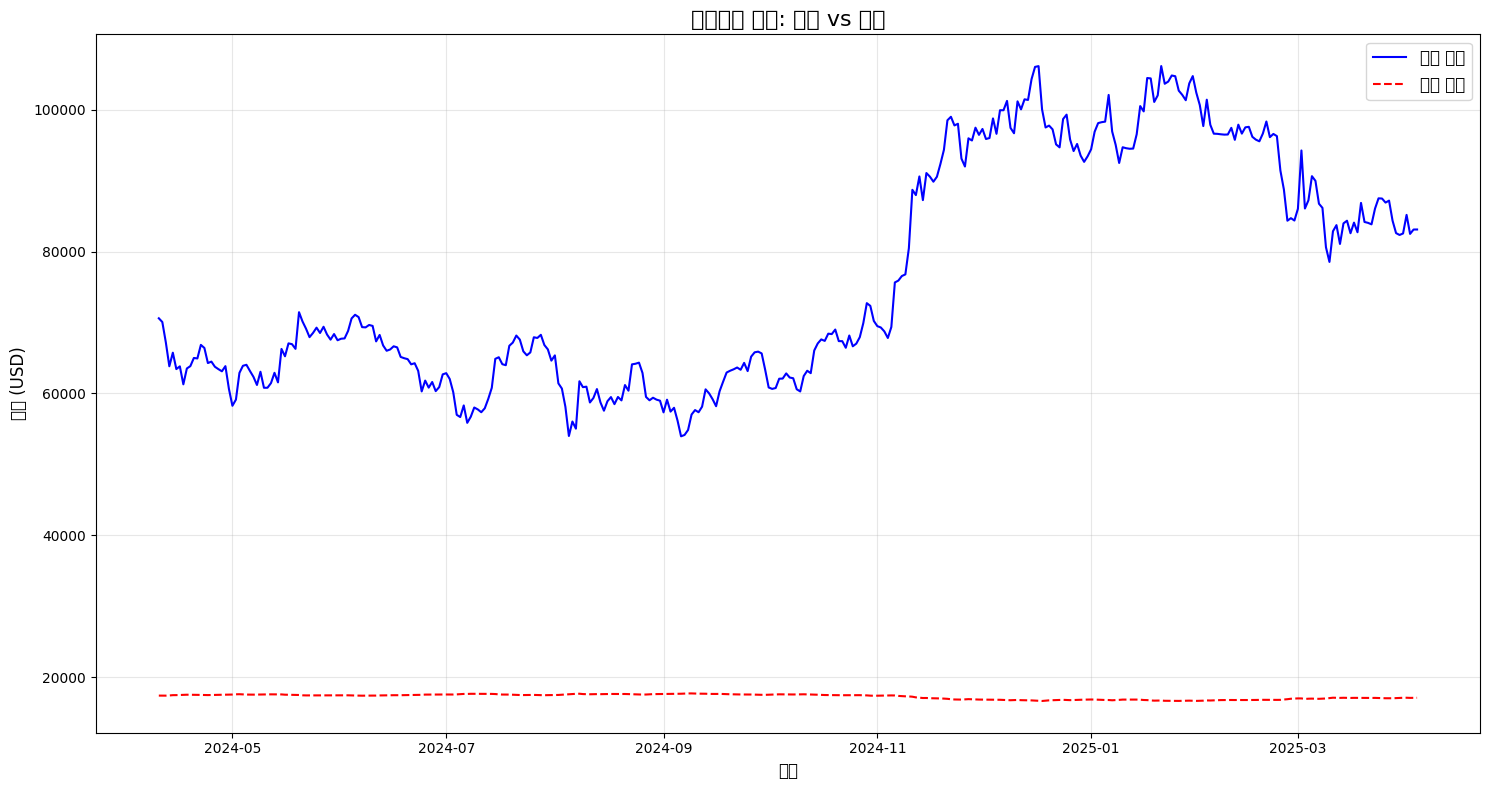

<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:135: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

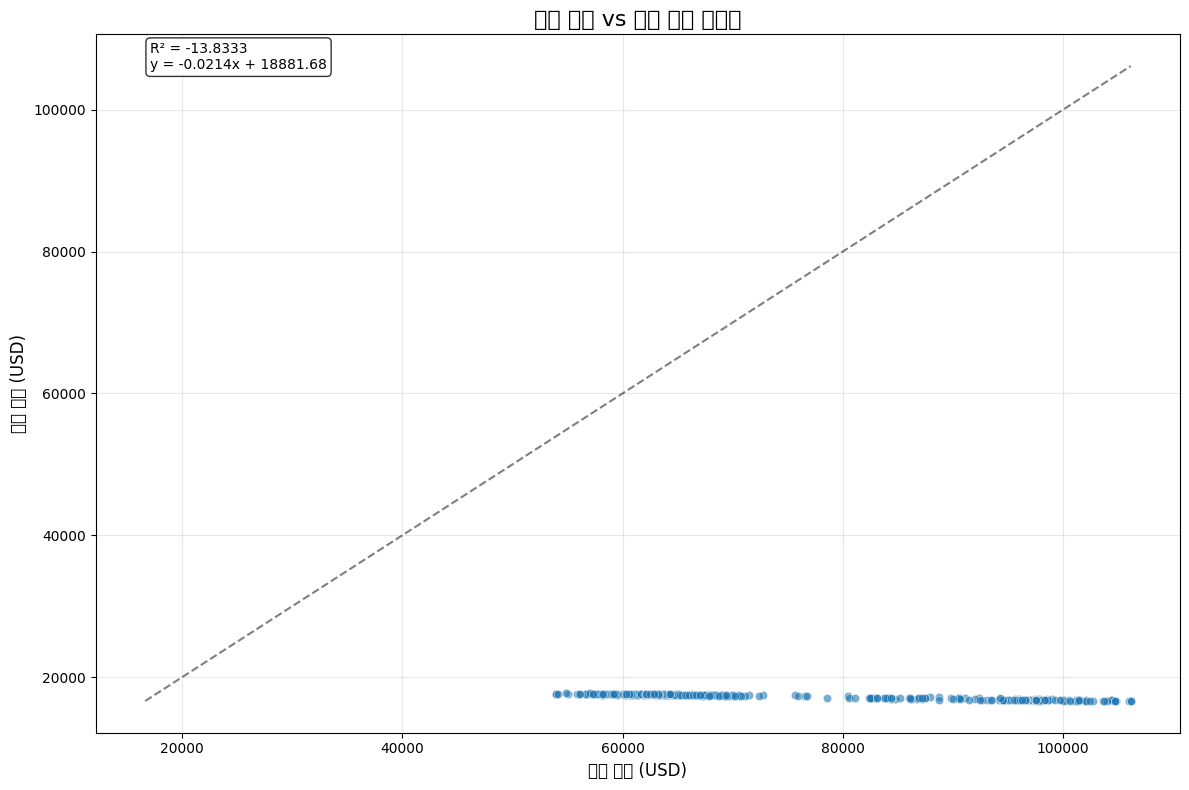

<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:155: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<i

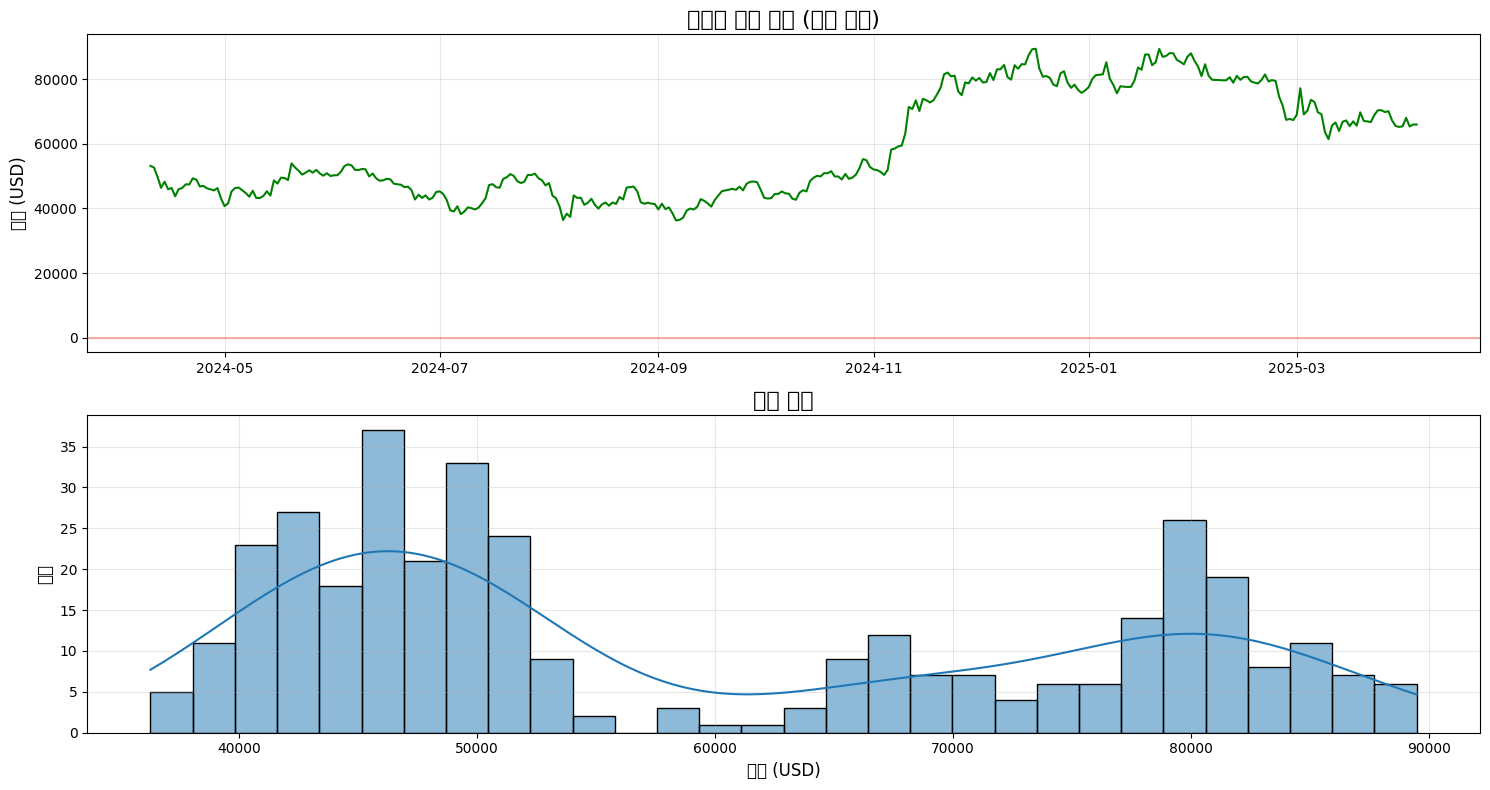

<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:164: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<

<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

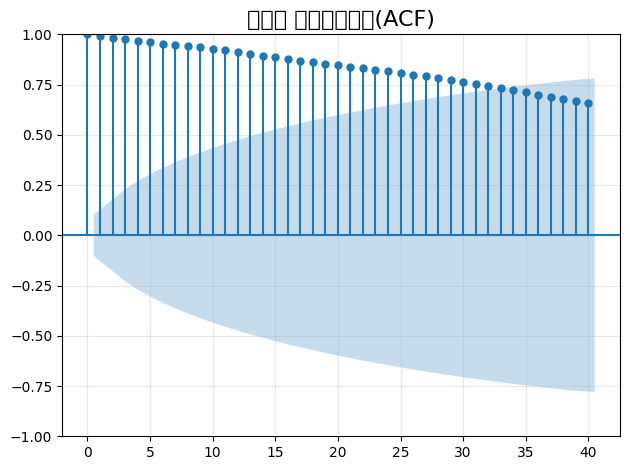

<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-24-a7f843d4af7d>:207: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_la

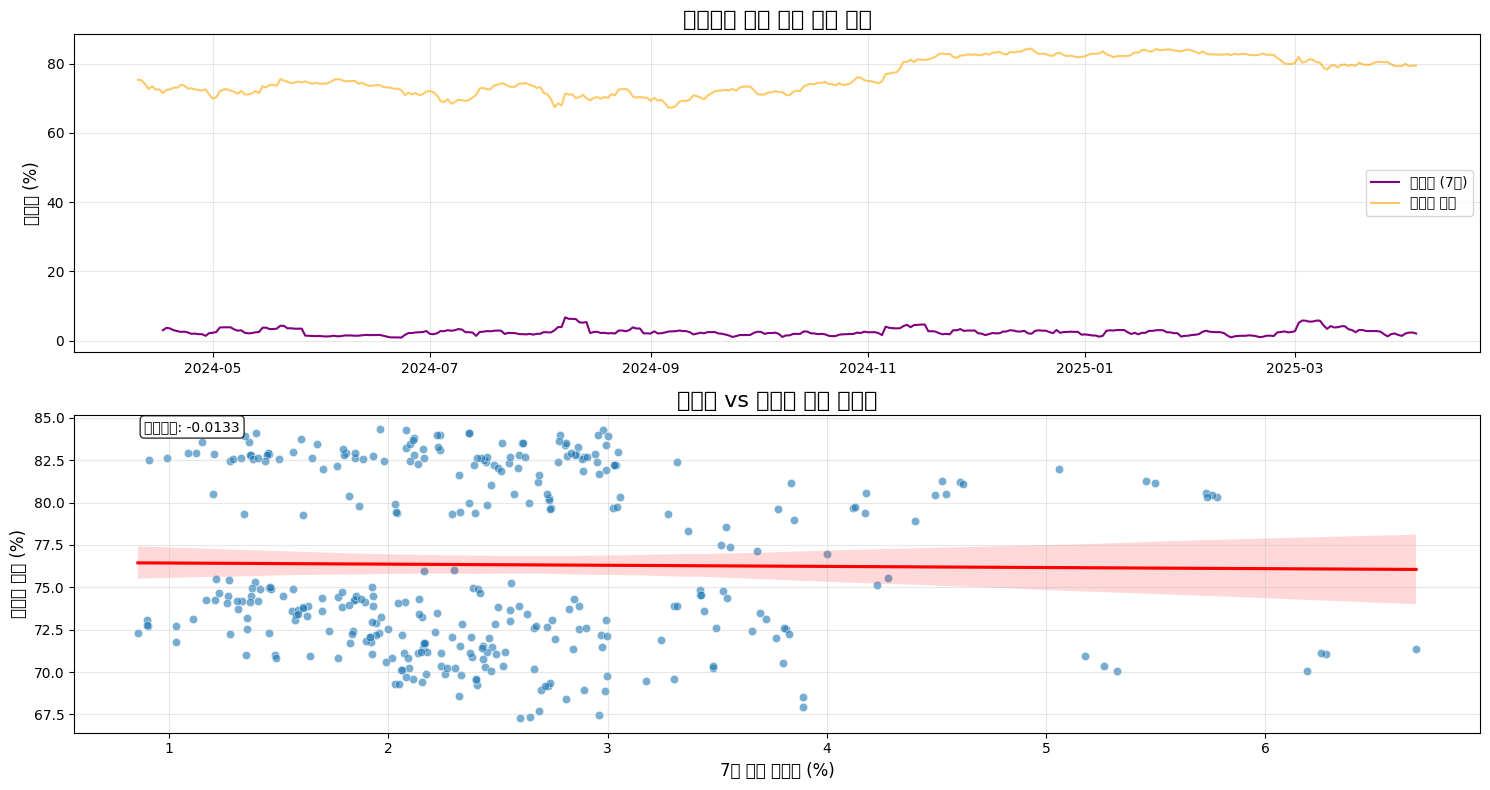


===== 모델 성능 종합 평가 =====
1. 기본 예측 정확도 지표:
   - RMSE: $61015.70
   - MAE: $58830.79
   - MAPE: 76.28%
   - R² (결정계수): -13.8333

2. 방향성 예측 지표:
   - 전체 방향성 정확도: 51.81%
   - 상승 방향 정확도: 51.98%
   - 하락 방향 정확도: 51.65%

3. Theil's U 통계량: 30.0916
   - 개선 필요: 단순 예측보다 성능이 낮음

===== 종합 평가 =====
모델 성능: 개선 필요
→ 모델 구조와 입력 데이터 재검토 필요


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import os
import datetime
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

def prepare_data(btc_file='data/btc_ohlcv.csv', fg_file='data/fear_greed_index.csv'):
    """
    데이터 로드 및 전처리 함수
    """
    # BTC 데이터 로드
    btc_data = pd.read_csv(btc_file)
    btc_data['Date'] = pd.to_datetime(btc_data['Date'])
    btc_data.set_index('Date', inplace=True)

    # 종가 데이터 추출 및 스케일링
    close_prices = btc_data['Close'].values.reshape(-1, 1)

    # MinMax 스케일러
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(close_prices)

    # 시퀀스 데이터 생성 (예: 30일 시퀀스)
    seq_length = 30
    X, y = [], []
    for i in range(len(scaled_prices) - seq_length):
        X.append(scaled_prices[i:i+seq_length])
        y.append(scaled_prices[i+seq_length])

    X = np.array(X)
    y = np.array(y)

    # 데이터 분할
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return {
        'X_test_seq': X_test,
        'y_test_seq': y_test,
        'scaler_y': scaler,
        'btc_data': btc_data,
        'test_dates': btc_data.index[len(btc_data) - len(y_test):]
    }

def load_and_predict(model_path, data_dict):
    """
    모델 로드 및 예측 함수
    """
    # 모델 로드
    model = load_model(model_path)

    # 데이터 추출
    X_test_seq = data_dict['X_test_seq']
    y_test_seq = data_dict['y_test_seq']
    scaler_y = data_dict['scaler_y']
    test_dates = data_dict['test_dates']

    # 예측
    y_pred = model.predict(X_test_seq)

    # 스케일링 역변환
    y_test_orig = scaler_y.inverse_transform(y_test_seq)
    y_pred_orig = scaler_y.inverse_transform(y_pred)

    return y_test_orig, y_pred_orig, test_dates

def visualize_prediction_results(y_test_orig, y_pred_orig, date_index=None):
    """
    예측 결과를 다양한 방식으로 시각화하는 함수
    """
    # 데이터 준비
    y_test_flat = y_test_orig.flatten()
    y_pred_flat = y_pred_orig.flatten()

    # 잔차 계산
    residuals = y_test_flat - y_pred_flat

    # 날짜 인덱스가 없으면 데이터 포인트 인덱스 사용
    if date_index is None:
        date_index = pd.RangeIndex(start=0, stop=len(y_test_flat), step=1)

    # 결과 데이터프레임 생성
    results_df = pd.DataFrame({
        'Date': date_index,
        'Actual': y_test_flat,
        'Predicted': y_pred_flat,
        'Residual': residuals,
        'Abs_Residual': np.abs(residuals),
        'Squared_Residual': residuals**2,
        'Percent_Error': np.abs(residuals / y_test_flat) * 100
    })

    # 1. 시계열 그래프: 실제 가격 vs 예측 가격
    plt.figure(figsize=(15, 8))
    plt.plot(results_df['Date'], results_df['Actual'], label='실제 가격', color='blue')
    plt.plot(results_df['Date'], results_df['Predicted'], label='예측 가격', color='red', linestyle='--')
    plt.title('비트코인 가격: 실제 vs 예측', fontsize=16)
    plt.xlabel('날짜', fontsize=12)
    plt.ylabel('가격 (USD)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('time_series_plot.png', dpi=300)
    plt.show()

    # 2. Scatter Plot: 실제 가격 vs 예측 가격
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Actual', y='Predicted', data=results_df, alpha=0.6)

    # 회귀선 추가
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='이상적인 예측')

    # R² 값 계산 및 표시
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        results_df['Actual'], results_df['Predicted']
    )
    plt.annotate(f"R² = {r2:.4f}\ny = {slope:.4f}x + {intercept:.2f}",
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('실제 가격 vs 예측 가격 산점도', fontsize=16)
    plt.xlabel('실제 가격 (USD)', fontsize=12)
    plt.ylabel('예측 가격 (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()

    # 3. 잔차 플롯
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Date'], results_df['Residual'], color='green')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('시간에 따른 잔차 (예측 오차)', fontsize=16)
    plt.ylabel('잔차 (USD)', fontsize=12)
    plt.grid(True, alpha=0.3)

    # 4. 잔차 히스토그램
    plt.subplot(2, 1, 2)
    sns.histplot(results_df['Residual'], kde=True, bins=30)
    plt.title('잔차 분포', fontsize=16)
    plt.xlabel('잔차 (USD)', fontsize=12)
    plt.ylabel('빈도', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('residual_analysis.png', dpi=300)
    plt.show()

    # 5. 잔차의 자기상관 함수(ACF) 플롯
    plt.figure(figsize=(12, 6))
    plot_acf(results_df['Residual'], lags=40, alpha=0.05)
    plt.title('잔차의 자기상관함수(ACF)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('residual_acf.png', dpi=300)
    plt.show()

    return results_df

def analyze_prediction_errors(results_df, window_size=7):
    """
    예측 오차를 분석하고 패턴을 찾는 함수
    """
    # 결과 복사
    df = results_df.copy()

    # 롤링 변동성 계산
    df['rolling_volatility'] = df['Actual'].pct_change().rolling(window=window_size).std() * 100

    # 예측 오차와 변동성 간의 관계 분석
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['rolling_volatility'], color='purple', label='변동성 (7일)')
    plt.plot(df['Date'], df['Abs_Residual'] / df['Actual'] * 100, color='orange', label='백분율 오차', alpha=0.6)
    plt.title('변동성과 예측 오차 간의 관계', fontsize=16)
    plt.ylabel('백분율 (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    # 산점도로 변동성 vs 오차 관계 확인
    plt.subplot(2, 1, 2)
    sns.scatterplot(x='rolling_volatility', y='Percent_Error', data=df, alpha=0.6)

    # 회귀선 추가
    sns.regplot(x='rolling_volatility', y='Percent_Error', data=df, scatter=False, color='red')

    # 상관계수 계산 및 표시
    corr = df['rolling_volatility'].corr(df['Percent_Error'])
    plt.annotate(f"상관계수: {corr:.4f}",
                 xy=(0.05, 0.95), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('변동성 vs 백분율 오차 산점도', fontsize=16)
    plt.xlabel('7일 롤링 변동성 (%)', fontsize=12)
    plt.ylabel('백분율 오차 (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('volatility_vs_error.png', dpi=300)
    plt.show()

    return df

def interpret_model_performance(y_test_orig, y_pred_orig, results_df=None):
    """
    모델 성능 지표를 종합적으로 해석하는 함수
    """
    # 데이터 평탄화
    y_test_flat = y_test_orig.flatten()
    y_pred_flat = y_pred_orig.flatten()

    # 기본 평가 지표 계산
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mape = np.mean(np.abs((y_test_flat - y_pred_flat) / y_test_flat)) * 100
    r2 = r2_score(y_test_flat, y_pred_flat)

    # 방향성 정확도
    actual_diff = np.diff(y_test_flat)
    pred_diff = np.diff(y_pred_flat)
    direction_match = (actual_diff > 0) == (pred_diff > 0)
    direction_accuracy = np.mean(direction_match) * 100

    # 추가 평가 지표
    # 1. 틸트(Theil) U 통계량
    # 단순 예측 모델(이전 값 그대로 예측) 생성
    naive_pred = np.roll(y_test_flat, 1)
    naive_pred[0] = naive_pred[1]  # 첫 값 처리

    # 제안 모델과 단순 모델의 MSE 비교
    model_mse = mean_squared_error(y_test_flat, y_pred_flat)
    naive_mse = mean_squared_error(y_test_flat, naive_pred)
    theil_u = np.sqrt(model_mse) / np.sqrt(naive_mse)

    # 2. 양수/음수 방향 별 정확도
    up_accuracy = np.mean(direction_match[actual_diff > 0]) * 100 if np.any(actual_diff > 0) else 0
    down_accuracy = np.mean(direction_match[actual_diff < 0]) * 100 if np.any(actual_diff < 0) else 0

    # 결과 해석 및 출력
    print("\n===== 모델 성능 종합 평가 =====")
    print(f"1. 기본 예측 정확도 지표:")
    print(f"   - RMSE: ${rmse:.2f}")
    print(f"   - MAE: ${mae:.2f}")
    print(f"   - MAPE: {mape:.2f}%")
    print(f"   - R² (결정계수): {r2:.4f}")

    print(f"\n2. 방향성 예측 지표:")
    print(f"   - 전체 방향성 정확도: {direction_accuracy:.2f}%")
    print(f"   - 상승 방향 정확도: {up_accuracy:.2f}%")
    print(f"   - 하락 방향 정확도: {down_accuracy:.2f}%")

    # Theil's U 해석
    print(f"\n3. Theil's U 통계량: {theil_u:.4f}")
    if theil_u < 0.5:
        print("   - 매우 우수: 단순 예측보다 50% 이상 개선")
    elif theil_u < 0.8:
        print("   - 우수: 단순 예측보다 20-50% 개선")
    elif theil_u < 1:
        print("   - 양호: 단순 예측보다 개선됨")
    else:
        print("   - 개선 필요: 단순 예측보다 성능이 낮음")

    # 성능 해석 및 점수화
    avg_score = 0

    # RMSE 점수
    avg_price = np.mean(y_test_flat)
    rmse_percent = (rmse / avg_price) * 100
    rmse_score = max(0, min(5, 5 * (1 - rmse_percent/20)))  # 0-5점

    # MAPE 점수
    mape_score = max(0, min(5, 5 * (1 - mape/30)))  # 0-5점

    # 방향성 정확도 점수
    dir_score = max(0, min(5, 5 * (direction_accuracy - 50) / 25))  # 0-5점

    # R² 점수
    r2_score_val = max(0, min(5, 5 * r2))  # 0-5점

    # Theil's U 점수
    theil_score = max(0, min(5, 5 * (1 - theil_u)))  # 0-5점

    # 평균 점수 계산
    avg_score = (rmse_score + mape_score + dir_score + r2_score_val + theil_score) / 5

    print("\n===== 종합 평가 =====")
    if avg_score > 4:
        print("모델 성능: 매우 우수")
        print("→ 실제 거래 전략에 직접 활용 가능")
    elif avg_score > 3:
        print("모델 성능: 우수")
        print("→ 보조 지표로 활용 가능")
    elif avg_score > 2:
        print("모델 성능: 양호")
        print("→ 장기 추세 파악에 참고 가능")
    else:
        print("모델 성능: 개선 필요")
        print("→ 모델 구조와 입력 데이터 재검토 필요")

    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'direction_accuracy': direction_accuracy,
        'up_accuracy': up_accuracy,
        'down_accuracy': down_accuracy,
        'theil_u': theil_u,
        'avg_score': avg_score
    }

def evaluate_bitcoin_prediction_model(y_test_orig, y_pred_orig, test_dates):
   """
   비트코인 가격 예측 모델 평가 통합 함수
   """
   print("===== 비트코인 가격 예측 모델 평가 =====")

   # 1. 예측 결과 시각화
   results_df = visualize_prediction_results(y_test_orig, y_pred_orig, test_dates)

   # 2. 예측 오차 분석
   analyze_prediction_errors(results_df)

   # 3. 모델 성능 해석
   performance_metrics = interpret_model_performance(y_test_orig, y_pred_orig)

   # 최종 결과 반환
   return {
       'results_df': results_df,
       'performance_metrics': performance_metrics
   }

# 메인 실행 코드
def main():
   # 모델 경로
   model_path = 'optimal_bitcoin_model.h5'

   # 데이터 준비
   data_dict = prepare_data()

   # 모델 로드 및 예측
   y_test_orig, y_pred_orig, test_dates = load_and_predict(model_path, data_dict)

   # 모델 평가
   evaluation_summary = evaluate_bitcoin_prediction_model(y_test_orig, y_pred_orig, test_dates)

if __name__ == "__main__":
   main()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
